# CNN

## Import Statements

In [ ]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import scipy.stats as stats
from numpy import ndarray

#tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras import callbacks
import tensorboard as tb
print(tf.__version__)

##model matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

import joblib
import pickle

import os

2.9.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/HAPT Data Set"

Mounted at /content/drive
/content/drive/MyDrive/HAPT Data Set


## Load and process the dataset

outcome of these cells are x_train, x_test, y_train, y_test;

In [ ]:
## Load labels
columns = ['user', 'activity', 'time', 'ax','ay','az', 'gx', 'gy', 'gz']
label_dict = {1: "WALKING",
              2: "WALKING_UPSTAIRS",
              3: "WALKING_DOWNSTAIRS",
              4: "SITTING",
              5: "STANDING",
              6: "LAYING",
              7: "STAND_TO_SIT",
              8: "SIT_TO_STAND", 
              9: "SIT_TO_LIE", 
              10: "LIE_TO_SIT",
              11: "STAND_TO_LIE",
              12: "LIE_TO_STAND"}
label_dict_rev = {v: k for k, v in label_dict.items()}
label_list = list(label_dict.values())

In [ ]:
##Change this as necessary
processed = False

### For pre-processed data

In [ ]:
if processed:
    x_train = pd.read_csv(r'Train/X_train.txt', header = None, sep=" ")
    y_train = pd.read_csv(r'Train/y_train.txt', header = None)
    x_test = pd.read_csv(r'Test/X_test.txt', header = None, sep=" ")
    y_test = pd.read_csv(r'Test/y_test.txt', header = None)

    x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)
    
##Change accordingly the file name :\

### For raw data

In [ ]:
##function to put dataset into frames
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 6

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        ax = df['ax'].values[i: i + frame_size]
        ay = df['ay'].values[i: i + frame_size]
        az = df['az'].values[i: i + frame_size]
        gx = df['gx'].values[i: i + frame_size]
        gy = df['gy'].values[i: i + frame_size]
        gz = df['gz'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size], keepdims = True)[0][0]
        frames.append([ax, ay, az, gx, gy, gz])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [ ]:
if not processed:
    ##Read files
    files = os.listdir('./RawData/')
    files.sort()
    raw_labels = pd.read_csv('RawData\labels.txt', sep = ' ', header = None)
    acc_file = []
    gyro_file = []
    for file in files:
        if file.startswith('acc'):
            acc_file.append(pd.read_csv('RawData\\' + file, sep=' ', header=None))
        elif file.startswith('gyro'):
            gyro_file.append(pd.read_csv('RawData\\' + file, sep=' ', header=None))
            
    ##Putting all into a dataframe
    data = []
    for exper, user, label, start, end in raw_labels.values:
        temp = [user, label_dict[label]]
        for i in range(end-start):
            a = acc_file[exper-1].values[start+i-1]
            b = gyro_file[exper-1].values[start+i-1]
            temp.append(start+i-1)
            temp.extend([a[0], a[1], a[2]])
            temp.extend([b[0], b[1], b[2]])
            data.append(temp)
            temp = [user, label_dict[label]]
            
    ##converting to dataframe
    data = pd.DataFrame(data = data, columns = columns)
    
    

In [ ]:
if not processed:
    ##adding label
    data['label'] = data['activity'].apply(lambda x: label_dict_rev[x])
    
    # These are users used in the test data of the processed dataset
    test_users = [2, 4, 9, 10, 12, 13, 18, 20, 24]
    data_train = data[~data["user"].isin(test_users)]
    data_train.reset_index(drop=True, inplace=True)
    data_test = data[data["user"].isin(test_users)]
    data_test.reset_index(drop=True, inplace=True)
    
    #extract the cols for standardization
    x_train = data_train[['ax','ay','az', 'gx', 'gy', 'gz']]
    x_test = data_test[['ax','ay','az', 'gx', 'gy', 'gz']]
    
    ##standardization
    scalar = StandardScaler()
    x_train = scalar.fit_transform(x_train)
    x_test = scalar.transform(x_test)

    x_train = pd.DataFrame(data = x_train, columns = ['ax','ay','az', 'gx', 'gy', 'gz'])
    x_test = pd.DataFrame(data = x_test, columns = ['ax','ay','az', 'gx', 'gy', 'gz'])
    
    ##adding back the removed labels
    x_train = pd.concat([x_train, data_train[["user", "time", "activity", "label"]]], axis="columns")
    x_test = pd.concat([x_test, data_test[["user", "time", "activity", "label"]]], axis="columns")
    
    ##Split into frames
    ### >>Change as needed<<
    Fs = 50
    frame_size = Fs * 4 #200
    hop_size = Fs * 2 #100

    x_train, y_train = get_frames(x_train, frame_size, hop_size)
    x_test, y_test = get_frames(x_test, frame_size, hop_size)
    
    ## Reshaping data for CNN
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
        

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

##For Fs = 50, frame_size = 200, hopsize = 100
## pre-processed should be ((7767, 561, 1), (3162, 561, 1), (7767, 1), (3162, 1))
## raw should be ((5771, 200, 6, 1), (5771,), (2370, 200, 6, 1), (2370,))

((5771, 200, 6, 1), (5771,), (2370, 200, 6, 1), (2370,))

## Testing CNN

In [ ]:
## For earlystopping
callback = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True)

In [ ]:
def plot_learningCurve(results):
    plt.figure(figsize=(16,10))
    plt.plot(np.array(results.history['loss']),"r--",label="Train loss")
    plt.plot(np.array(results.history['accuracy']),"g--",label="Train accuracy")
    plt.plot(np.array(results.history['val_loss']),"r-",label="Validation loss")
    plt.plot(np.array(results.history['val_accuracy']),"g-",label="Validation accuracy")
    plt.title("Training session's progress over iterations")
    plt.legend(loc='lower left')
    plt.ylabel('Training Progress (Loss/Accuracy)')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.show()

In [ ]:
def show_confusion_mat(fitted_model):
    y_pred = np.argmax(fitted_model.predict(x_test), axis=-1)
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', ax=ax, display_labels=list(label_dict_rev.keys()))
    plt.show()
    print(classification_report(y_test, y_pred, target_names=label_dict_rev.keys()))

In [ ]:
## setting constants
epoch = 20
lr = 0.001

### Base Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 199, 5, 16)        80        
                                                                 
 flatten (Flatten)           (None, 15920)             0         
                                                                 
 dense (Dense)               (None, 13)                206973    
                                                                 
Total params: 207,053
Trainable params: 207,053
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
145/145 [==============================] - 4s 7ms/step - loss: 0.6516 - accuracy: 0.7849 - val_loss: 0.4634 - val_accuracy: 0.8338
Epoch 2/20
145/145 [==============================] - 1s 4ms/step - loss: 0.2795 - accuracy: 0.9060 - val_loss: 0.4996 - val_accuracy: 0.8563
Epoch 3/20
145/145 [=====

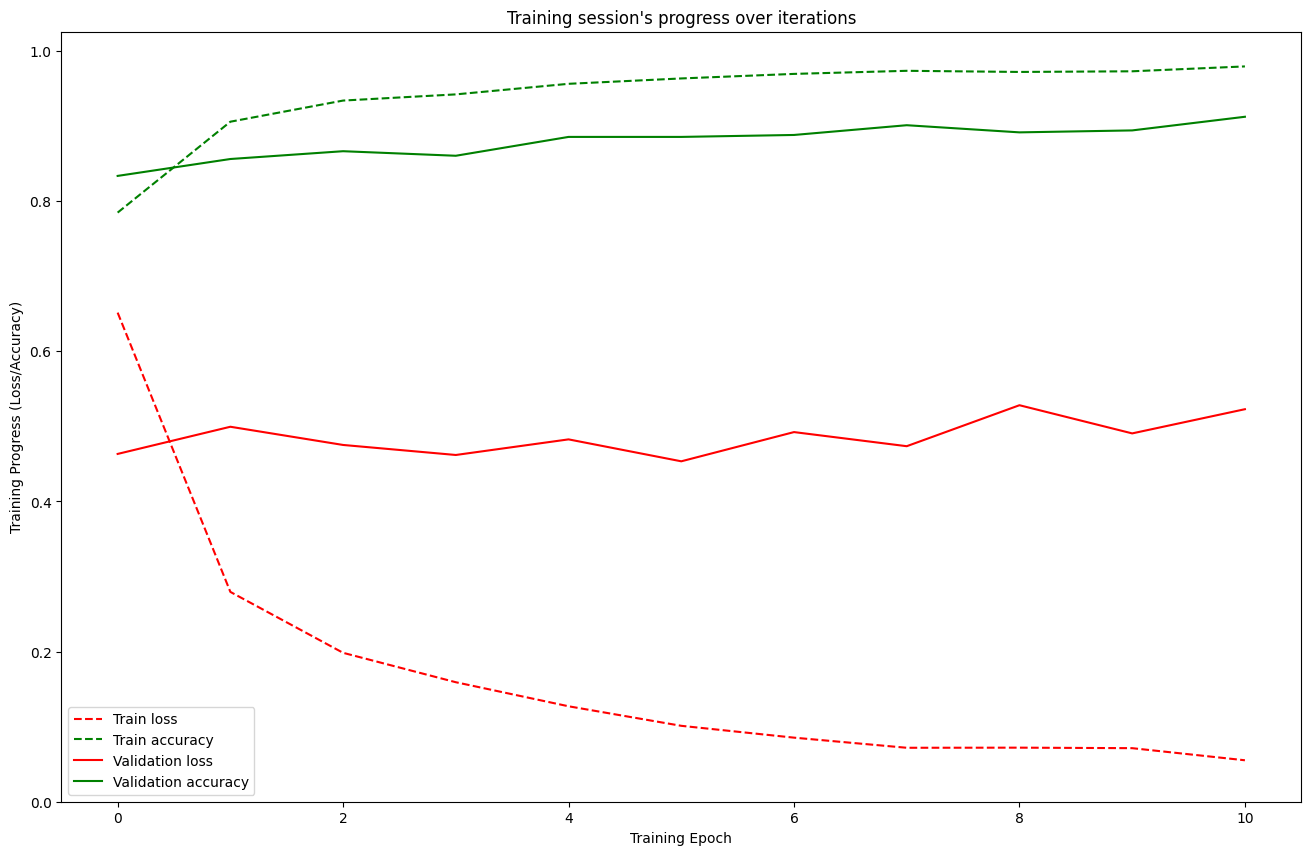

75/75 [==============================] - 0s 2ms/step


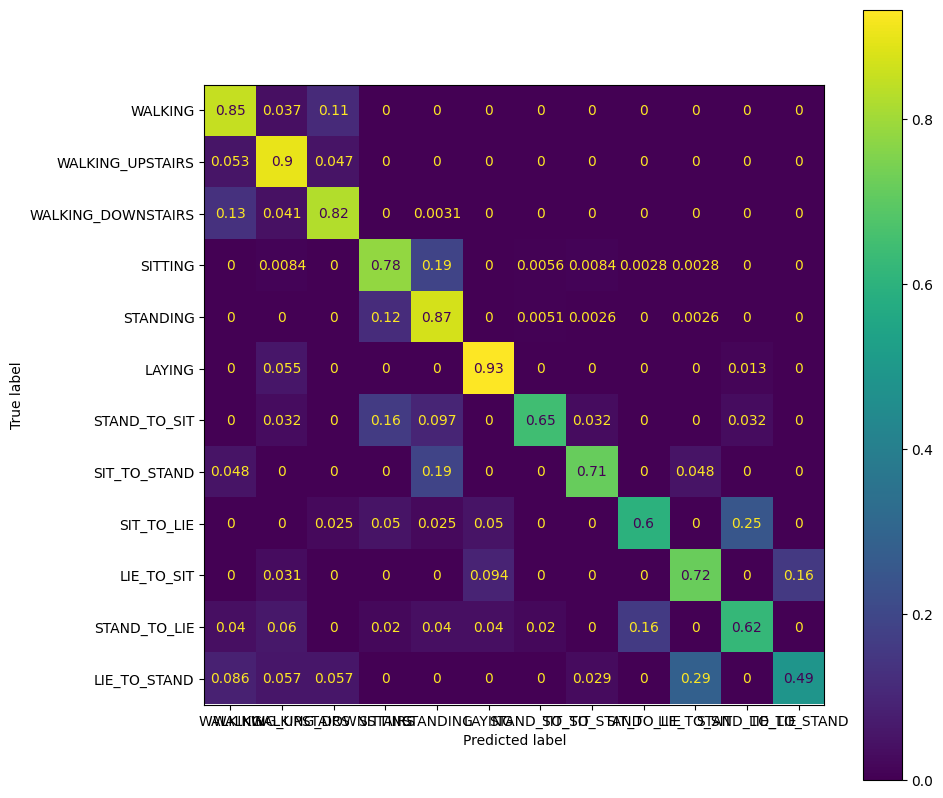

                    precision    recall  f1-score   support

           WALKING       0.82      0.85      0.83       350
  WALKING_UPSTAIRS       0.85      0.90      0.87       359
WALKING_DOWNSTAIRS       0.82      0.82      0.82       320
           SITTING       0.84      0.78      0.81       358
          STANDING       0.81      0.87      0.84       392
            LAYING       0.98      0.93      0.96       382
      STAND_TO_SIT       0.80      0.65      0.71        31
      SIT_TO_STAND       0.71      0.71      0.71        21
        SIT_TO_LIE       0.73      0.60      0.66        40
        LIE_TO_SIT       0.64      0.72      0.68        32
      STAND_TO_LIE       0.66      0.62      0.64        50
      LIE_TO_STAND       0.77      0.49      0.60        35

          accuracy                           0.84      2370
         macro avg       0.79      0.75      0.76      2370
      weighted avg       0.84      0.84      0.84      2370



In [ ]:
## Base model
#-----Copy and modify layers and value----
CNN_Base = Sequential()

CNN_Base.add(Conv2D(filters=16, kernel_size=(2,2), activation='relu', input_shape=x_train[0].shape))

CNN_Base.add(Flatten())

CNN_Base.add(Dense(13, activation='softmax'))

CNN_Base.compile(loss='sparse_categorical_crossentropy',optimizer='adam',
                metrics=['accuracy'])
print(CNN_Base.summary())

#----------------------------------
history = CNN_Base.fit(x_train, y_train, epochs=epoch, validation_split=0.2, verbose=1, callbacks = callback)
plot_learningCurve(history)
show_confusion_mat(CNN_Base)

### Testing different hyperparameters

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 198, 4, 16)        160       
                                                                 
 flatten_1 (Flatten)         (None, 12672)             0         
                                                                 
 dense_1 (Dense)             (None, 13)                164749    
                                                                 
Total params: 164,909
Trainable params: 164,909
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
145/145 [==============================] - 1s 5ms/step - loss: 0.6009 - accuracy: 0.8024 - val_loss: 0.4775 - val_accuracy: 0.8459
Epoch 2/20
145/145 [==============================] - 1s 4ms/step - loss: 0.2623 - accuracy: 0.9142 - val_loss: 0.4648 - val_accuracy: 0.8779
Epoch 3/20
145/145 [===

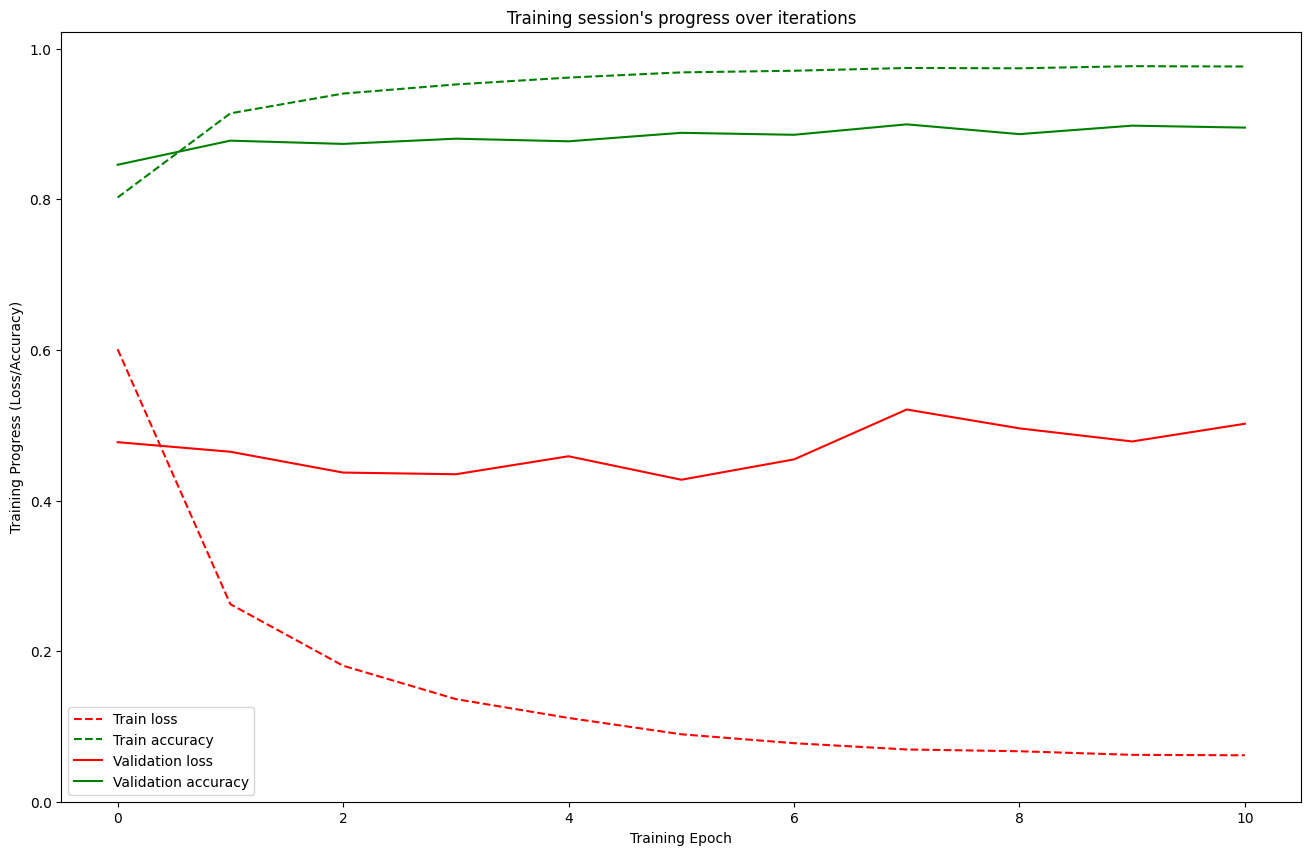

75/75 [==============================] - 0s 2ms/step


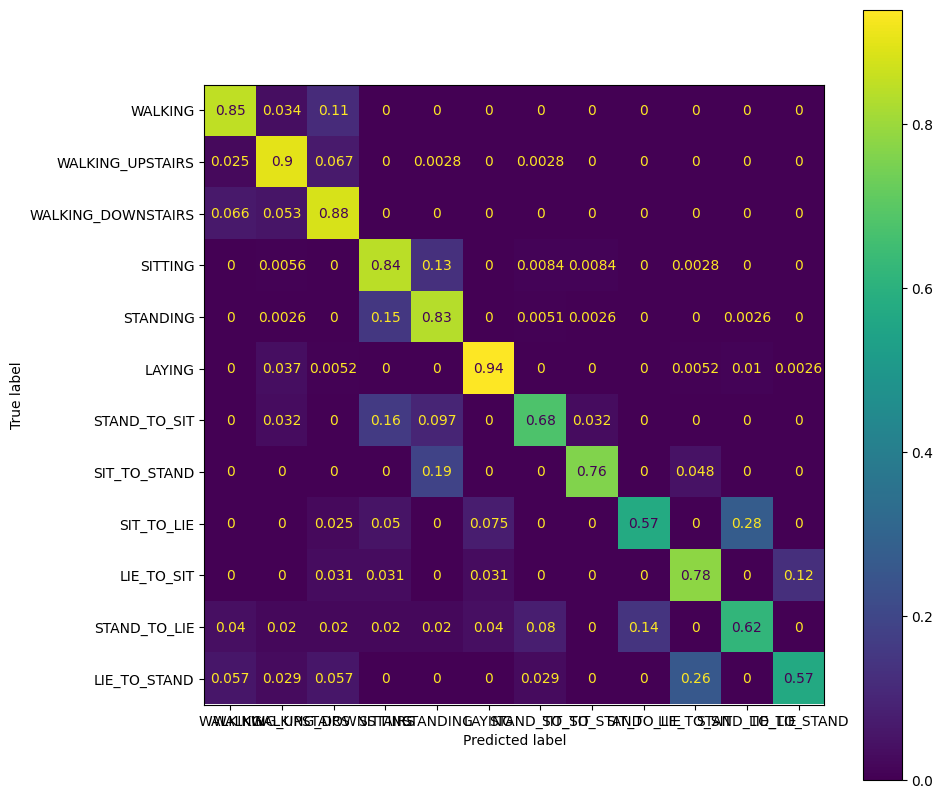

                    precision    recall  f1-score   support

           WALKING       0.90      0.85      0.87       350
  WALKING_UPSTAIRS       0.87      0.90      0.89       359
WALKING_DOWNSTAIRS       0.80      0.88      0.84       320
           SITTING       0.81      0.84      0.83       358
          STANDING       0.85      0.83      0.84       392
            LAYING       0.98      0.94      0.96       382
      STAND_TO_SIT       0.66      0.68      0.67        31
      SIT_TO_STAND       0.76      0.76      0.76        21
        SIT_TO_LIE       0.77      0.57      0.66        40
        LIE_TO_SIT       0.66      0.78      0.71        32
      STAND_TO_LIE       0.66      0.62      0.64        50
      LIE_TO_STAND       0.80      0.57      0.67        35

          accuracy                           0.86      2370
         macro avg       0.79      0.77      0.78      2370
      weighted avg       0.86      0.86      0.86      2370



In [ ]:
#-----Copy and modify layers and value----
CNN_3by3 = Sequential()

CNN_3by3.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=x_train[0].shape))

CNN_3by3.add(Flatten())

CNN_3by3.add(Dense(13, activation='softmax'))

CNN_3by3.compile(loss='sparse_categorical_crossentropy',optimizer='adam',
                metrics=['accuracy'])
print(CNN_3by3.summary())

#----------------------------------
history = CNN_3by3.fit(x_train, y_train, epochs=epoch, validation_split=0.2, verbose=1, callbacks = callback)
plot_learningCurve(history)
show_confusion_mat(CNN_3by3)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 197, 3, 16)        272       
                                                                 
 flatten_2 (Flatten)         (None, 9456)              0         
                                                                 
 dense_2 (Dense)             (None, 13)                122941    
                                                                 
Total params: 123,213
Trainable params: 123,213
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
145/145 [==============================] - 1s 5ms/step - loss: 0.6241 - accuracy: 0.7866 - val_loss: 0.4481 - val_accuracy: 0.8710
Epoch 2/20
145/145 [==============================] - 1s 5ms/step - loss: 0.2513 - accuracy: 0.9216 - val_loss: 0.3935 - val_accuracy: 0.8840
Epoch 3/20
145/145 [===

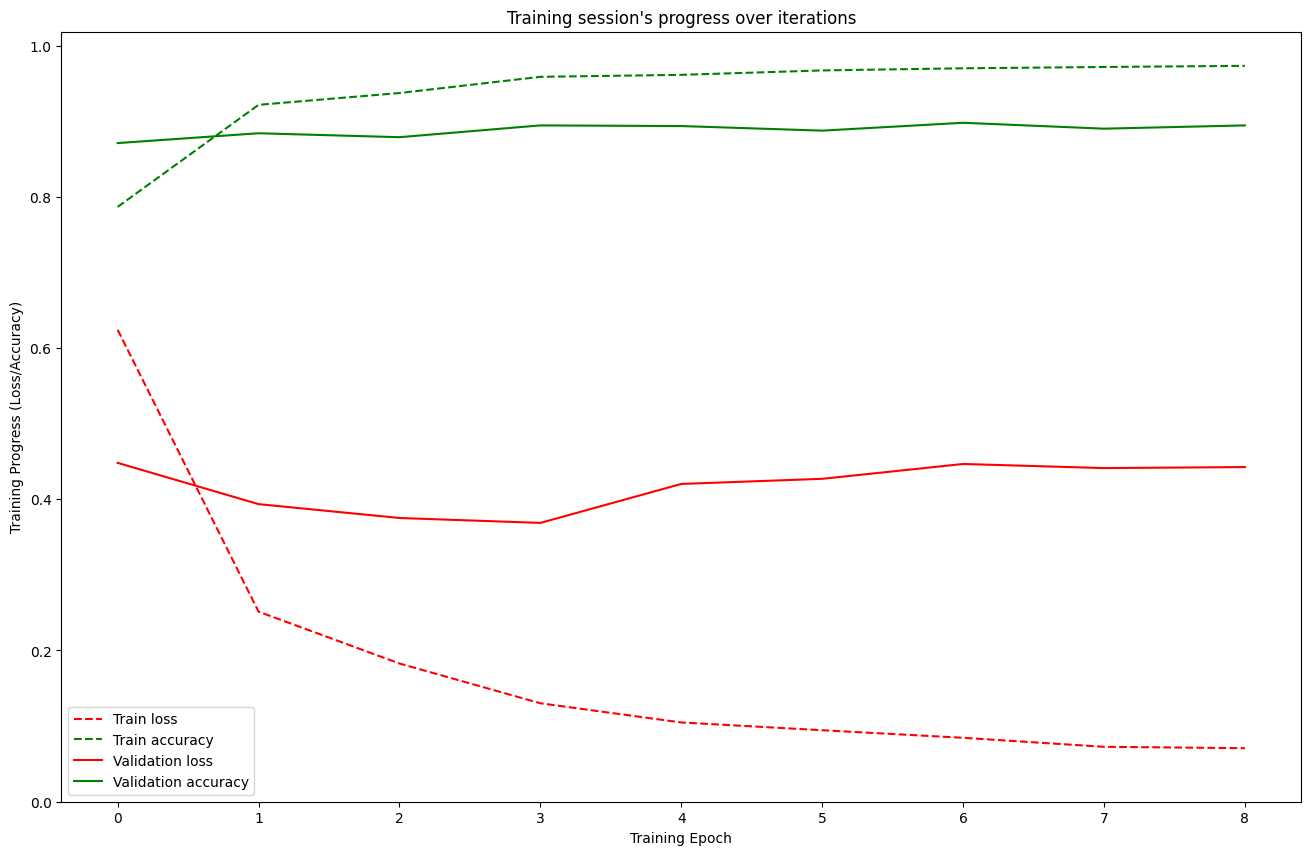

75/75 [==============================] - 0s 2ms/step


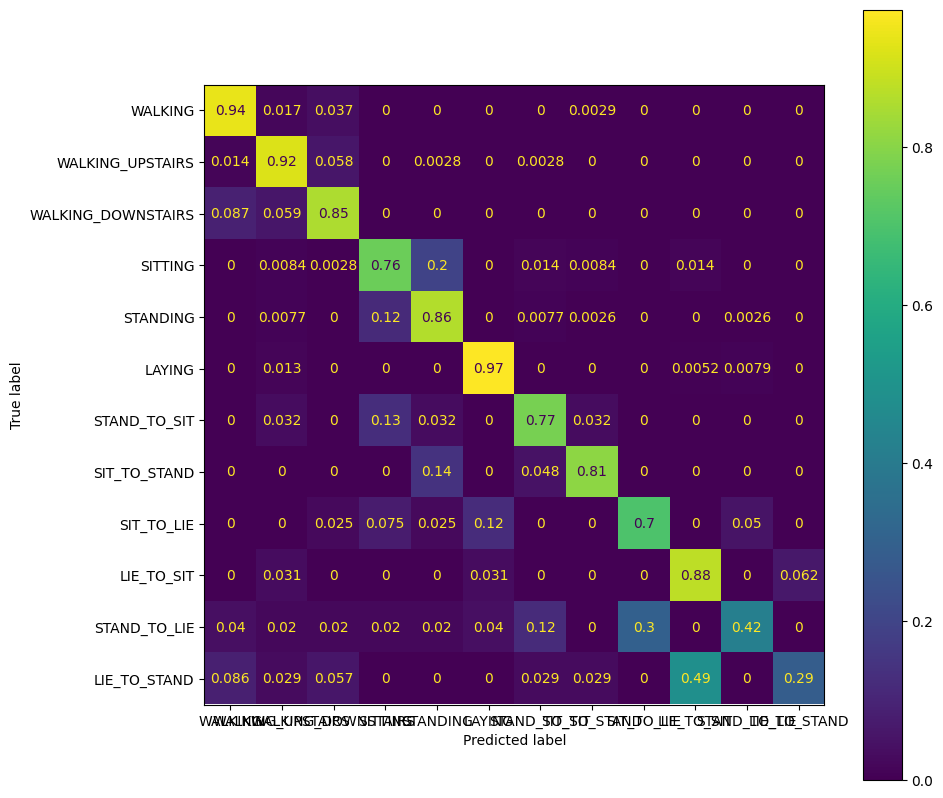

                    precision    recall  f1-score   support

           WALKING       0.90      0.94      0.92       350
  WALKING_UPSTAIRS       0.89      0.92      0.91       359
WALKING_DOWNSTAIRS       0.88      0.85      0.86       320
           SITTING       0.83      0.76      0.79       358
          STANDING       0.81      0.86      0.84       392
            LAYING       0.98      0.97      0.98       382
      STAND_TO_SIT       0.59      0.77      0.67        31
      SIT_TO_STAND       0.71      0.81      0.76        21
        SIT_TO_LIE       0.65      0.70      0.67        40
        LIE_TO_SIT       0.54      0.88      0.67        32
      STAND_TO_LIE       0.78      0.42      0.55        50
      LIE_TO_STAND       0.83      0.29      0.43        35

          accuracy                           0.86      2370
         macro avg       0.78      0.76      0.75      2370
      weighted avg       0.87      0.86      0.86      2370



In [ ]:
#-----Copy and modify layers and value----
CNN_4by4 = Sequential()

CNN_4by4.add(Conv2D(filters=16, kernel_size=(4,4), activation='relu', input_shape=x_train[0].shape))

CNN_4by4.add(Flatten())

CNN_4by4.add(Dense(13, activation='softmax'))

CNN_4by4.compile(loss='sparse_categorical_crossentropy',optimizer='adam',
                metrics=['accuracy'])
print(CNN_4by4.summary())

#----------------------------------
history = CNN_4by4.fit(x_train, y_train, epochs=epoch, validation_split=0.2, verbose=1, callbacks = callback)
plot_learningCurve(history)
show_confusion_mat(CNN_4by4)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 197, 3, 16)        272       
                                                                 
 flatten_3 (Flatten)         (None, 9456)              0         
                                                                 
 dense_3 (Dense)             (None, 13)                122941    
                                                                 
Total params: 123,213
Trainable params: 123,213
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
145/145 [==============================] - 1s 6ms/step - loss: 0.5965 - accuracy: 0.8039 - val_loss: 0.3795 - val_accuracy: 0.8814
Epoch 2/20
145/145 [==============================] - 1s 5ms/step - loss: 0.2411 - accuracy: 0.9205 - val_loss: 0.3580 - val_accuracy: 0.8996
Epoch 3/20
145/145 [===

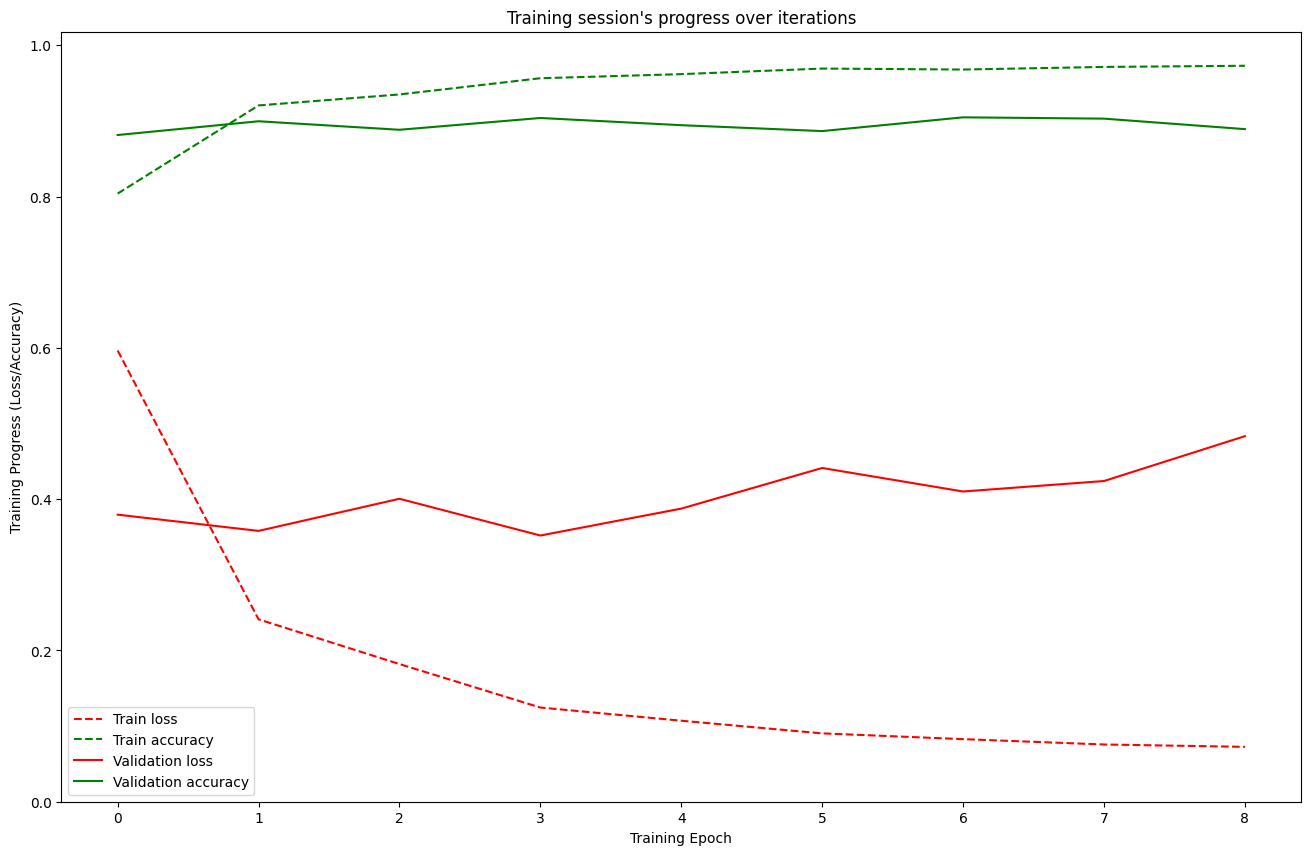

75/75 [==============================] - 0s 2ms/step


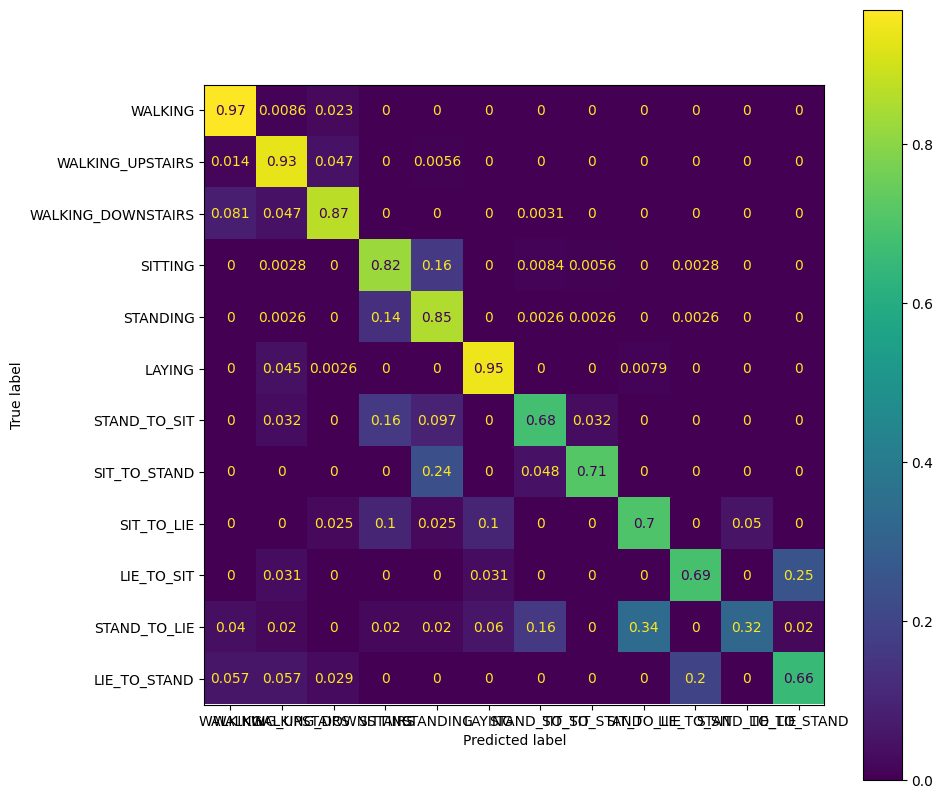

                    precision    recall  f1-score   support

           WALKING       0.91      0.97      0.94       350
  WALKING_UPSTAIRS       0.89      0.93      0.91       359
WALKING_DOWNSTAIRS       0.91      0.87      0.89       320
           SITTING       0.82      0.82      0.82       358
          STANDING       0.83      0.85      0.84       392
            LAYING       0.98      0.95      0.96       382
      STAND_TO_SIT       0.60      0.68      0.64        31
      SIT_TO_STAND       0.79      0.71      0.75        21
        SIT_TO_LIE       0.58      0.70      0.64        40
        LIE_TO_SIT       0.71      0.69      0.70        32
      STAND_TO_LIE       0.89      0.32      0.47        50
      LIE_TO_STAND       0.72      0.66      0.69        35

          accuracy                           0.87      2370
         macro avg       0.80      0.76      0.77      2370
      weighted avg       0.87      0.87      0.87      2370



In [ ]:
#-----Copy and modify layers and value----
CNN_5by5 = Sequential()

CNN_5by5.add(Conv2D(filters=16, kernel_size=(4,4), activation='relu', input_shape=x_train[0].shape))

CNN_5by5.add(Flatten())

CNN_5by5.add(Dense(13, activation='softmax'))

CNN_5by5.compile(loss='sparse_categorical_crossentropy',optimizer='adam',
                metrics=['accuracy'])
print(CNN_5by5.summary())

#----------------------------------
history = CNN_5by5.fit(x_train, y_train, epochs=epoch, validation_split=0.2, verbose=1, callbacks = callback)
plot_learningCurve(history)
show_confusion_mat(CNN_5by5)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 199, 5, 4)         20        
                                                                 
 dropout (Dropout)           (None, 199, 5, 4)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 198, 4, 4)         68        
                                                                 
 dropout_1 (Dropout)         (None, 198, 4, 4)         0         
                                                                 
 flatten_4 (Flatten)         (None, 3168)              0         
                                                                 
 dense_4 (Dense)             (None, 13)                41197     
                                                                 
Total params: 41,285
Trainable params: 41,285
Non-trai

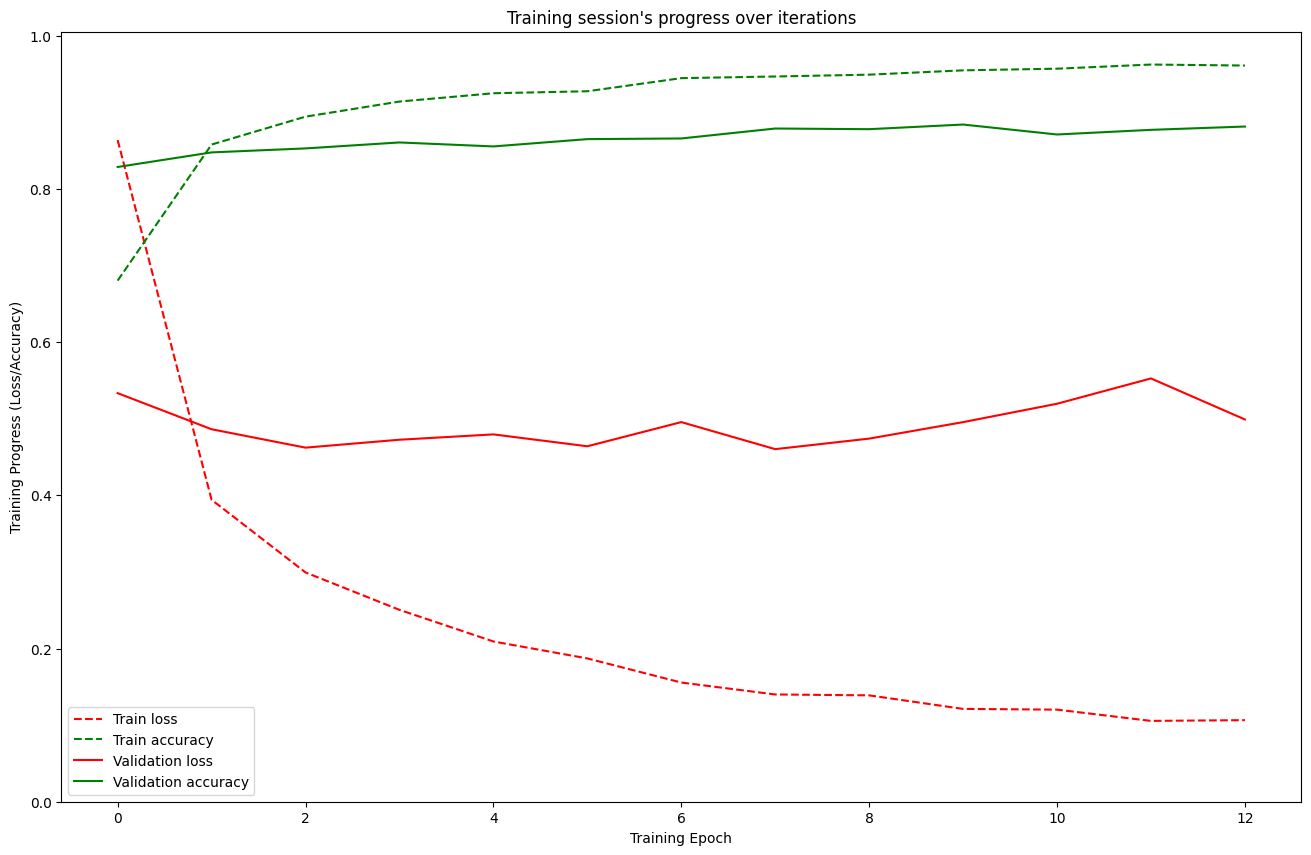

75/75 [==============================] - 0s 3ms/step


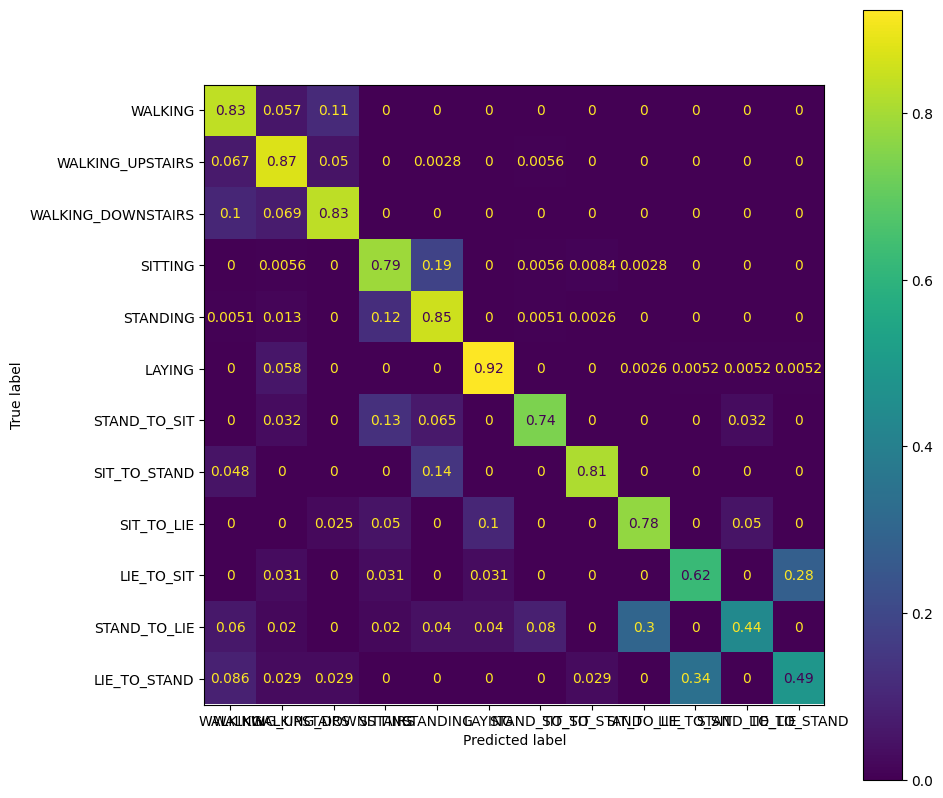

                    precision    recall  f1-score   support

           WALKING       0.82      0.83      0.83       350
  WALKING_UPSTAIRS       0.81      0.87      0.84       359
WALKING_DOWNSTAIRS       0.82      0.83      0.83       320
           SITTING       0.83      0.79      0.81       358
          STANDING       0.82      0.85      0.83       392
            LAYING       0.98      0.92      0.95       382
      STAND_TO_SIT       0.70      0.74      0.72        31
      SIT_TO_STAND       0.77      0.81      0.79        21
        SIT_TO_LIE       0.65      0.78      0.70        40
        LIE_TO_SIT       0.59      0.62      0.61        32
      STAND_TO_LIE       0.81      0.44      0.57        50
      LIE_TO_STAND       0.61      0.49      0.54        35

          accuracy                           0.83      2370
         macro avg       0.77      0.75      0.75      2370
      weighted avg       0.83      0.83      0.83      2370



In [ ]:
## conv2d(4,(2,2), relu) + drop(0.1) + conv2d(4,(2,2), relu) + drop(0.1) + flat() + output()
## base+1a
base1a = Sequential()
base1a.add(Conv2D(filters=4, kernel_size=(2,2), activation='relu', input_shape=x_train[0].shape))
base1a.add(Dropout(0.1))

base1a.add(Conv2D(4, (2, 2), activation='relu'))
base1a.add(Dropout(0.1))

base1a.add(Flatten())

base1a.add(Dense(13, activation='softmax'))

base1a.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(base1a.summary())
#------------------------------------------
history = base1a.fit(x_train, y_train, epochs=epoch, validation_split=0.2, verbose=1, callbacks = callback)
plot_learningCurve(history)
show_confusion_mat(base1a)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 199, 5, 16)        80        
                                                                 
 dropout_2 (Dropout)         (None, 199, 5, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 198, 4, 4)         260       
                                                                 
 dropout_3 (Dropout)         (None, 198, 4, 4)         0         
                                                                 
 flatten_5 (Flatten)         (None, 3168)              0         
                                                                 
 dense_5 (Dense)             (None, 13)                41197     
                                                                 
Total params: 41,537
Trainable params: 41,537
Non-trai

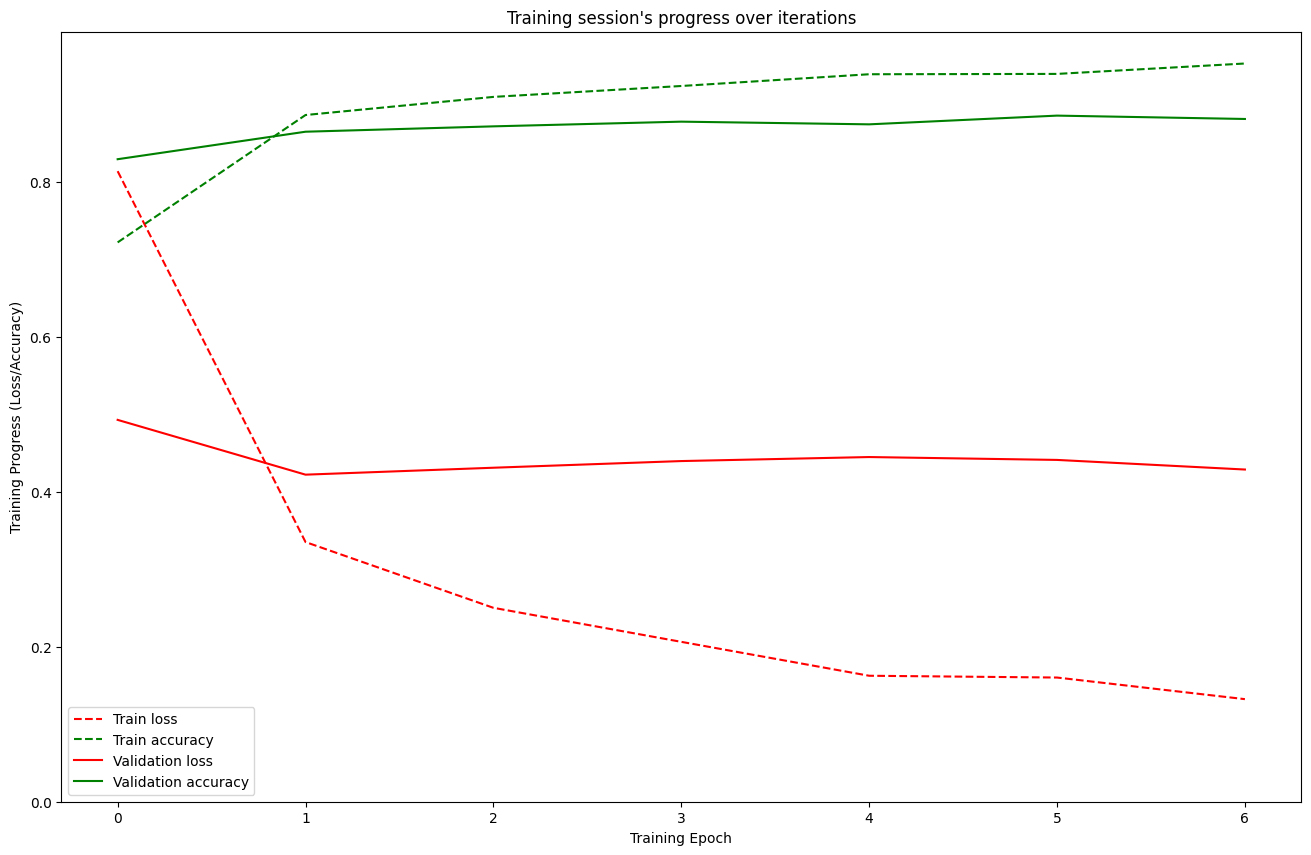

75/75 [==============================] - 0s 2ms/step


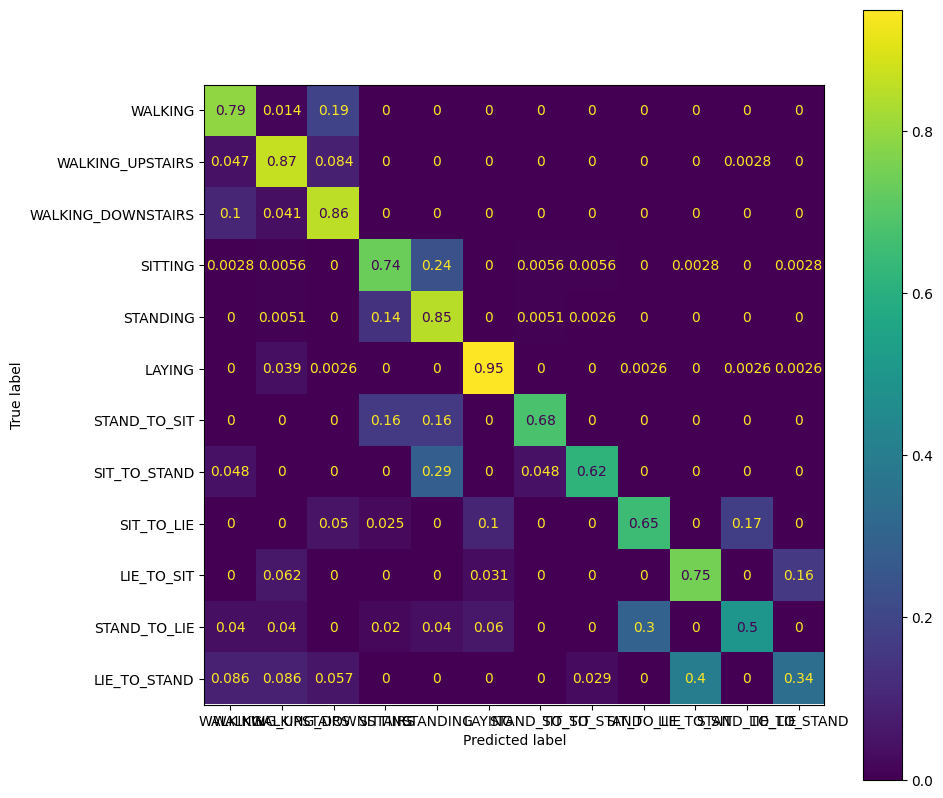

                    precision    recall  f1-score   support

           WALKING       0.83      0.79      0.81       350
  WALKING_UPSTAIRS       0.88      0.87      0.87       359
WALKING_DOWNSTAIRS       0.73      0.86      0.79       320
           SITTING       0.81      0.74      0.77       358
          STANDING       0.77      0.85      0.81       392
            LAYING       0.98      0.95      0.96       382
      STAND_TO_SIT       0.81      0.68      0.74        31
      SIT_TO_STAND       0.76      0.62      0.68        21
        SIT_TO_LIE       0.62      0.65      0.63        40
        LIE_TO_SIT       0.62      0.75      0.68        32
      STAND_TO_LIE       0.74      0.50      0.60        50
      LIE_TO_STAND       0.63      0.34      0.44        35

          accuracy                           0.82      2370
         macro avg       0.76      0.72      0.73      2370
      weighted avg       0.82      0.82      0.82      2370



In [ ]:
## conv2d(16,(2,2), relu) + drop(0.1) + conv2d(4,(2,2), relu) + drop(0.1) + flat() + output()
## base+1a
base1a = Sequential()
base1a.add(Conv2D(filters=16, kernel_size=(2,2), activation='relu', input_shape=x_train[0].shape))
base1a.add(Dropout(0.1))

base1a.add(Conv2D(4, (2, 2), activation='relu'))
base1a.add(Dropout(0.1))

base1a.add(Flatten())

base1a.add(Dense(13, activation='softmax'))

base1a.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(base1a.summary())
#------------------------------------------
history = base1a.fit(x_train, y_train, epochs=epoch, validation_split=0.2, verbose=1, callbacks = callback)
plot_learningCurve(history)
show_confusion_mat(base1a)

-----(2, 2)------
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 199, 5, 16)        80        
                                                                 
 flatten_6 (Flatten)         (None, 15920)             0         
                                                                 
 dense_6 (Dense)             (None, 13)                206973    
                                                                 
Total params: 207,053
Trainable params: 207,053
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
145/145 [==============================] - 1s 7ms/step - loss: 0.5852 - accuracy: 0.8059 - val_loss: 0.4755 - val_accuracy: 0.8641
Epoch 2/20
145/145 [==============================] - 1s 6ms/step - loss: 0.2764 - accuracy: 0.9066 - val_loss: 0.4136 - val_accuracy: 0.8805
Epoch

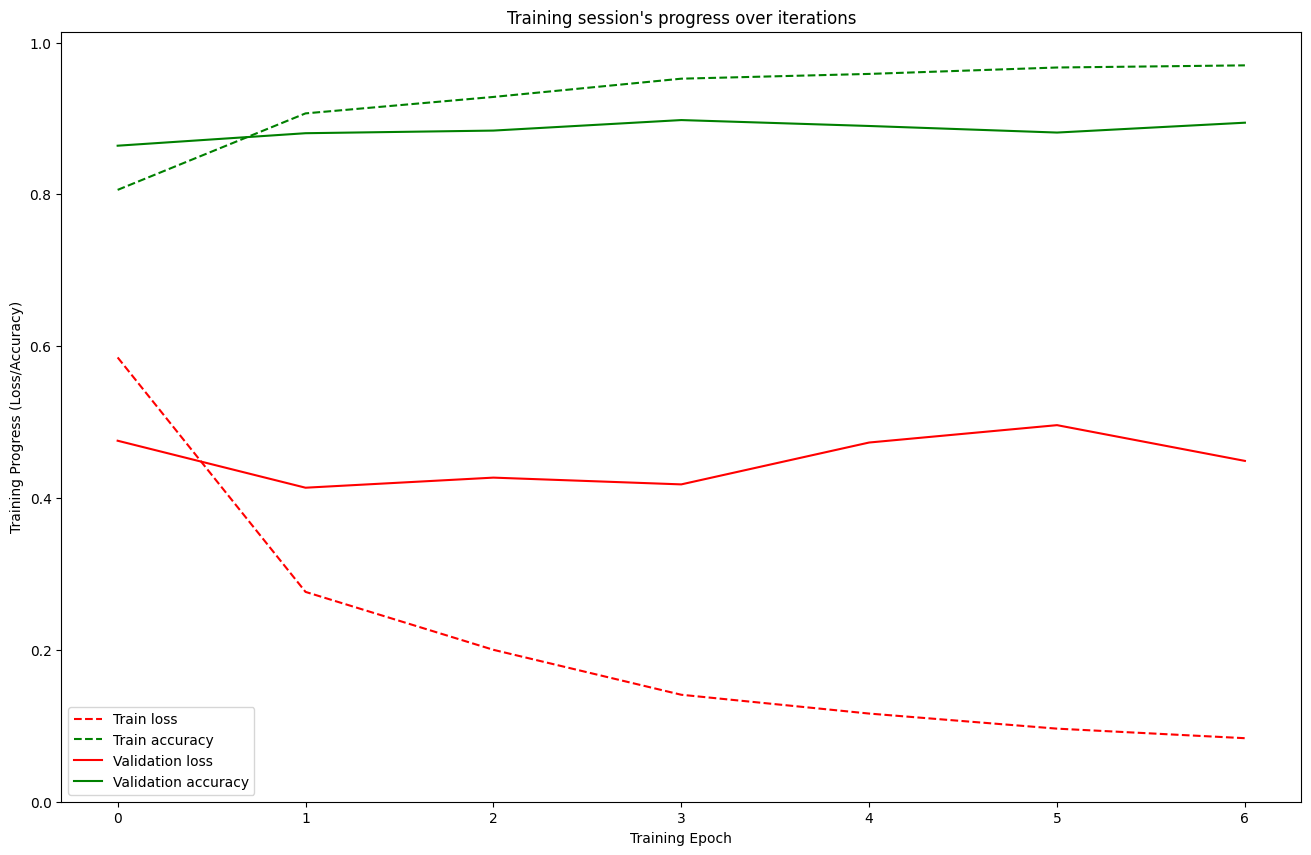

75/75 [==============================] - 0s 2ms/step


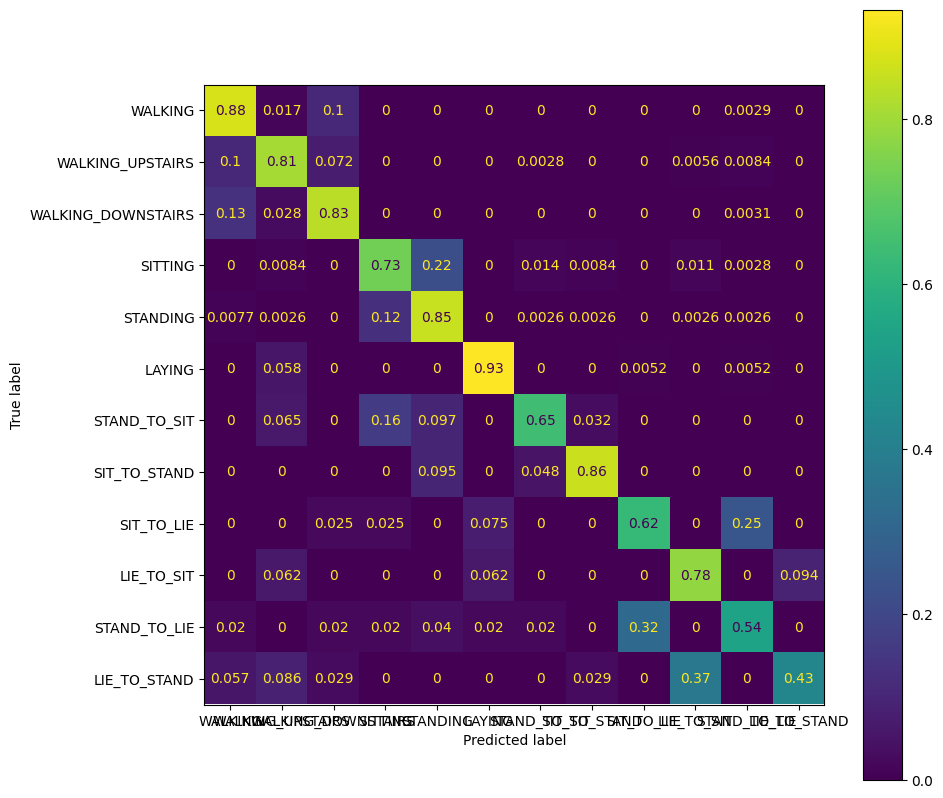

                    precision    recall  f1-score   support

           WALKING       0.78      0.88      0.83       350
  WALKING_UPSTAIRS       0.86      0.81      0.83       359
WALKING_DOWNSTAIRS       0.80      0.83      0.82       320
           SITTING       0.82      0.73      0.78       358
          STANDING       0.79      0.85      0.82       392
            LAYING       0.98      0.93      0.96       382
      STAND_TO_SIT       0.69      0.65      0.67        31
      SIT_TO_STAND       0.75      0.86      0.80        21
        SIT_TO_LIE       0.58      0.62      0.60        40
        LIE_TO_SIT       0.56      0.78      0.65        32
      STAND_TO_LIE       0.59      0.54      0.56        50
      LIE_TO_STAND       0.83      0.43      0.57        35

          accuracy                           0.82      2370
         macro avg       0.75      0.74      0.74      2370
      weighted avg       0.83      0.82      0.82      2370

-----(3, 3)------
Model: "sequential_

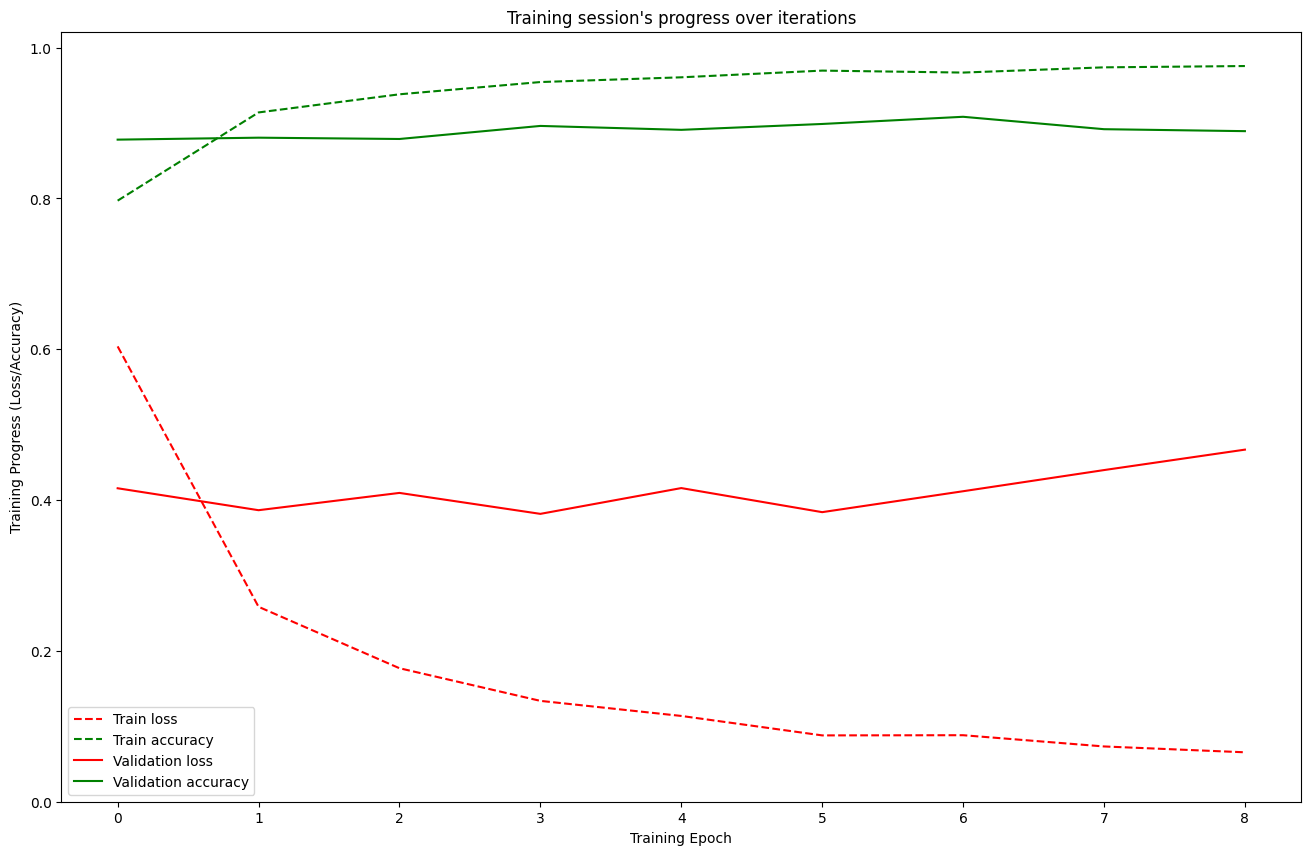

75/75 [==============================] - 0s 1ms/step


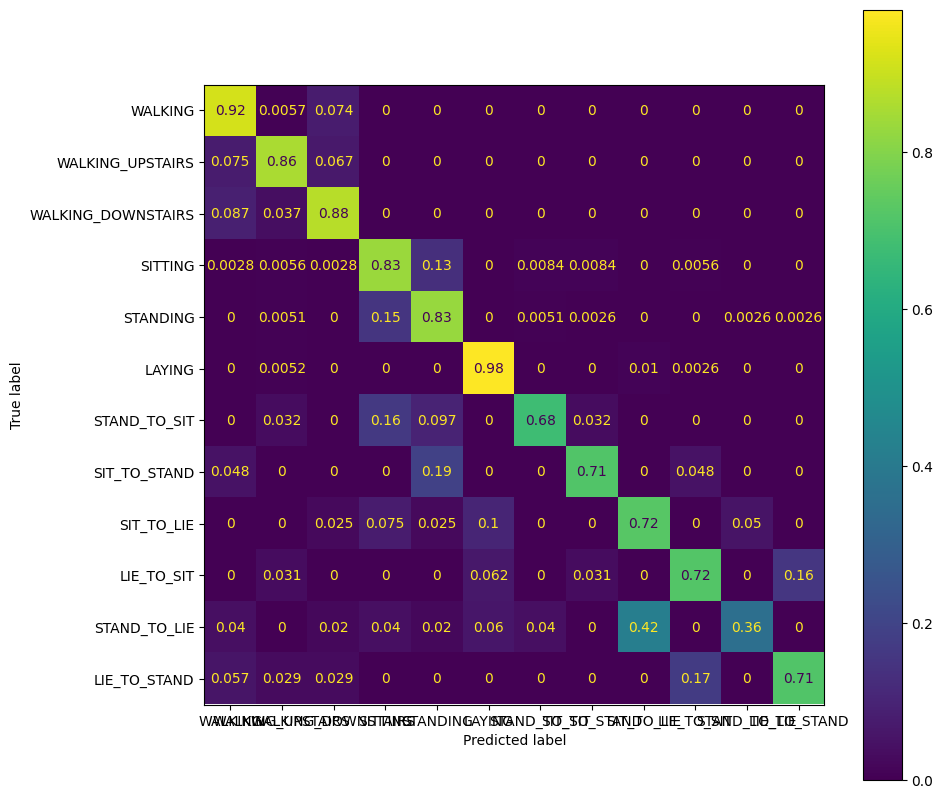

                    precision    recall  f1-score   support

           WALKING       0.84      0.92      0.88       350
  WALKING_UPSTAIRS       0.93      0.86      0.89       359
WALKING_DOWNSTAIRS       0.84      0.88      0.86       320
           SITTING       0.81      0.83      0.82       358
          STANDING       0.85      0.83      0.84       392
            LAYING       0.98      0.98      0.98       382
      STAND_TO_SIT       0.75      0.68      0.71        31
      SIT_TO_STAND       0.71      0.71      0.71        21
        SIT_TO_LIE       0.54      0.72      0.62        40
        LIE_TO_SIT       0.70      0.72      0.71        32
      STAND_TO_LIE       0.86      0.36      0.51        50
      LIE_TO_STAND       0.81      0.71      0.76        35

          accuracy                           0.86      2370
         macro avg       0.80      0.77      0.77      2370
      weighted avg       0.86      0.86      0.86      2370

-----(4, 4)------
Model: "sequential_

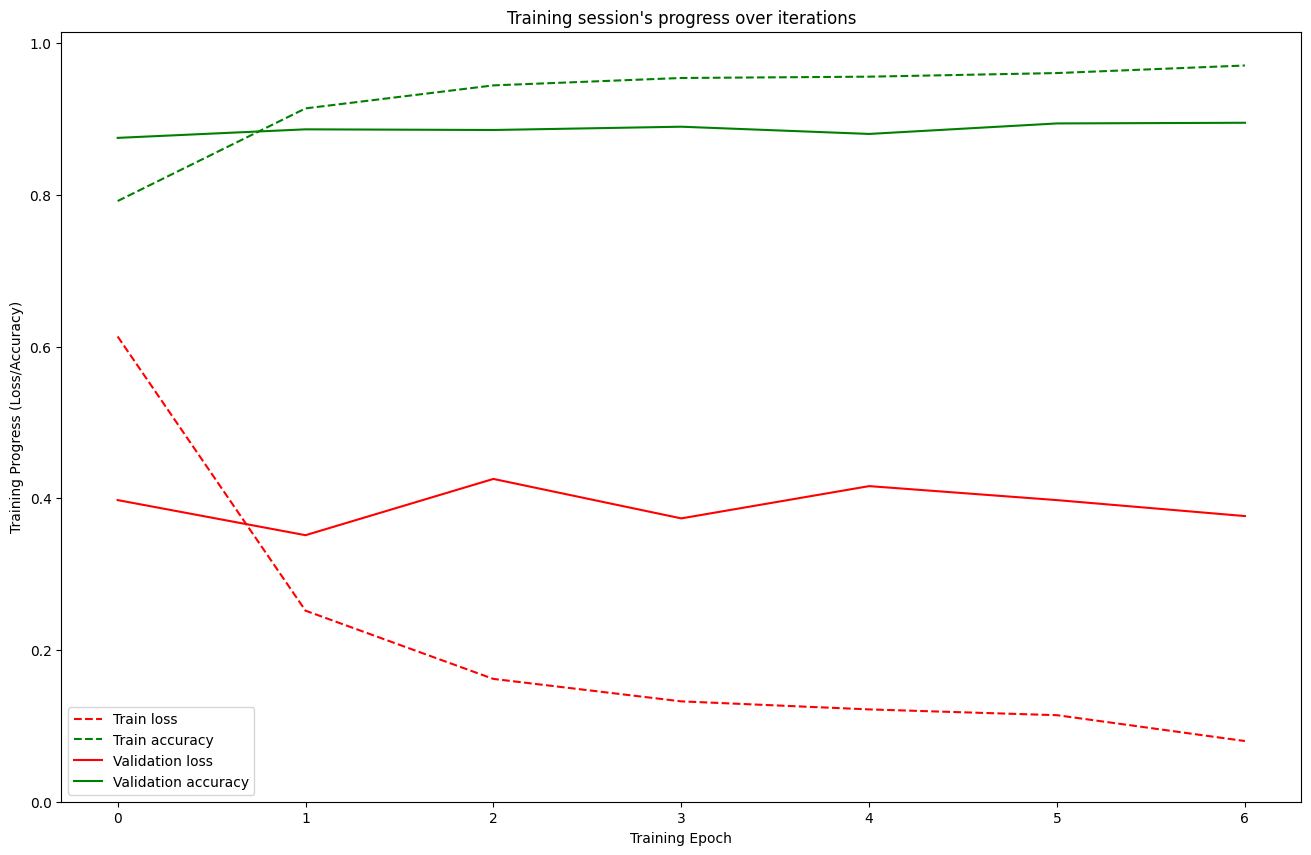

75/75 [==============================] - 0s 1ms/step


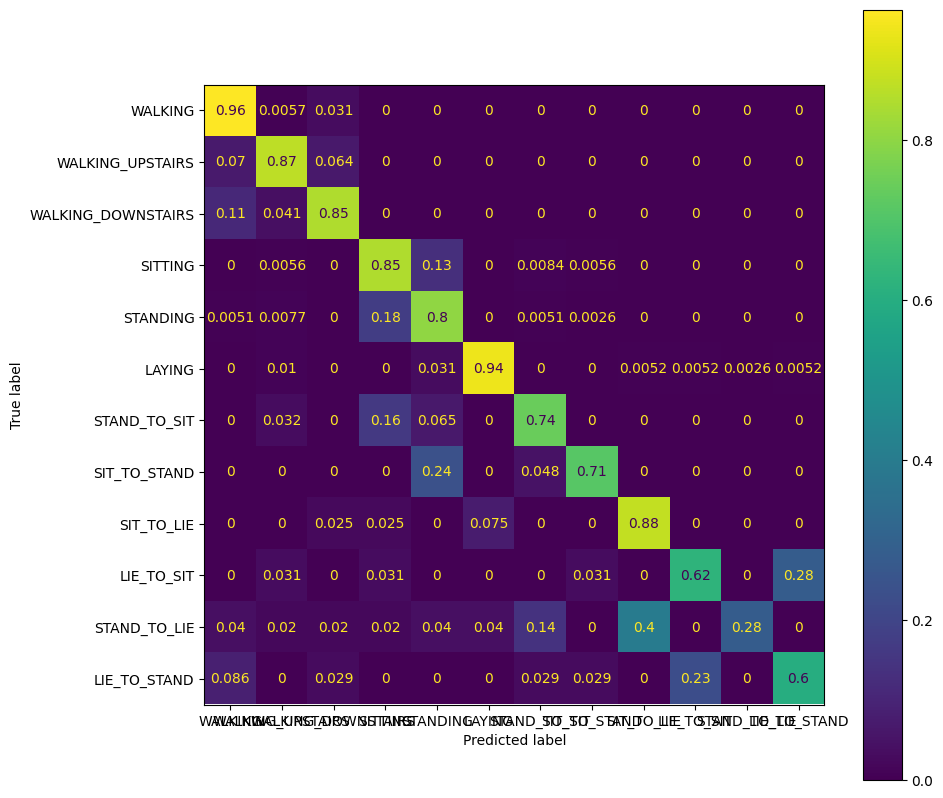

                    precision    recall  f1-score   support

           WALKING       0.83      0.96      0.89       350
  WALKING_UPSTAIRS       0.92      0.87      0.89       359
WALKING_DOWNSTAIRS       0.88      0.85      0.86       320
           SITTING       0.80      0.85      0.82       358
          STANDING       0.82      0.80      0.81       392
            LAYING       0.99      0.94      0.96       382
      STAND_TO_SIT       0.62      0.74      0.68        31
      SIT_TO_STAND       0.75      0.71      0.73        21
        SIT_TO_LIE       0.61      0.88      0.72        40
        LIE_TO_SIT       0.67      0.62      0.65        32
      STAND_TO_LIE       0.93      0.28      0.43        50
      LIE_TO_STAND       0.66      0.60      0.63        35

          accuracy                           0.85      2370
         macro avg       0.79      0.76      0.76      2370
      weighted avg       0.86      0.85      0.85      2370

-----(2, 3)------
Model: "sequential_

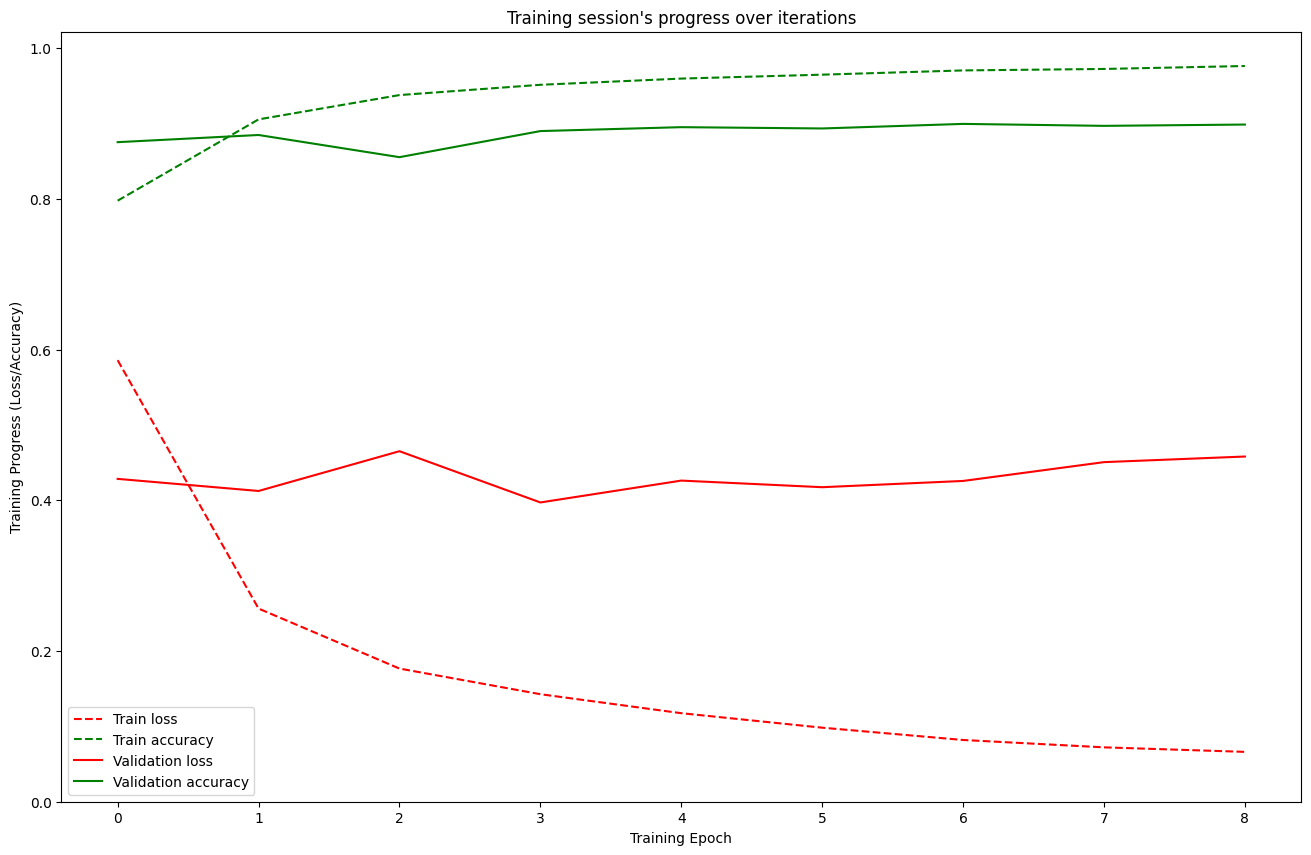

75/75 [==============================] - 0s 2ms/step


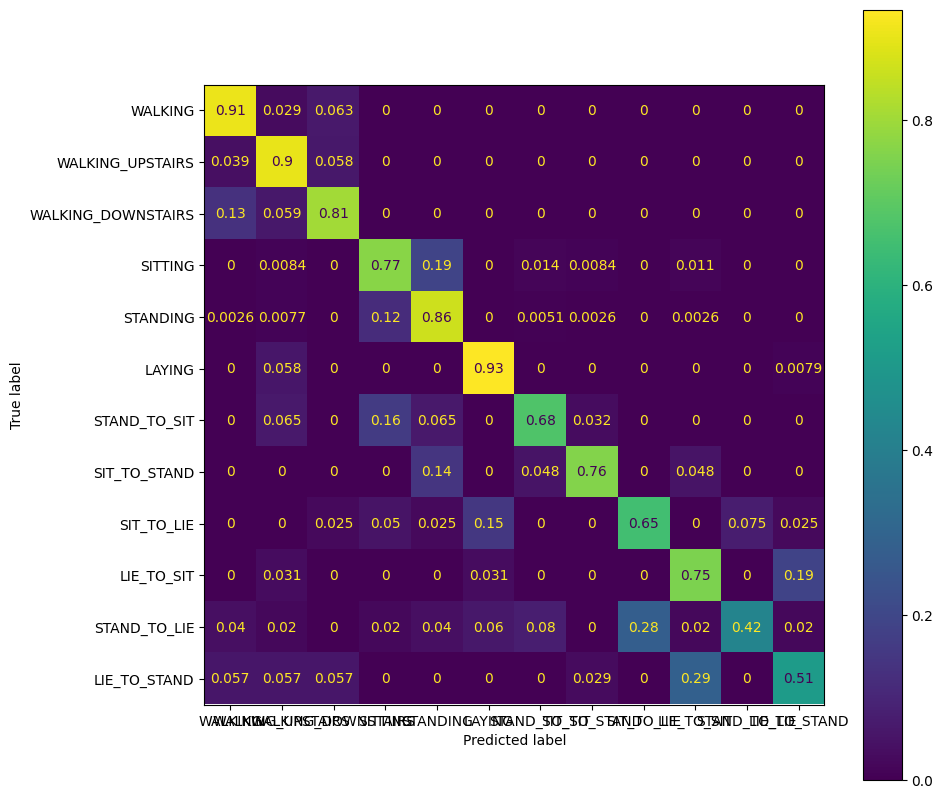

                    precision    recall  f1-score   support

           WALKING       0.84      0.91      0.87       350
  WALKING_UPSTAIRS       0.84      0.90      0.87       359
WALKING_DOWNSTAIRS       0.85      0.81      0.83       320
           SITTING       0.84      0.77      0.80       358
          STANDING       0.82      0.86      0.84       392
            LAYING       0.97      0.93      0.95       382
      STAND_TO_SIT       0.64      0.68      0.66        31
      SIT_TO_STAND       0.73      0.76      0.74        21
        SIT_TO_LIE       0.65      0.65      0.65        40
        LIE_TO_SIT       0.59      0.75      0.66        32
      STAND_TO_LIE       0.88      0.42      0.57        50
      LIE_TO_STAND       0.62      0.51      0.56        35

          accuracy                           0.84      2370
         macro avg       0.77      0.75      0.75      2370
      weighted avg       0.84      0.84      0.84      2370

-----(3, 2)------
Model: "sequential_

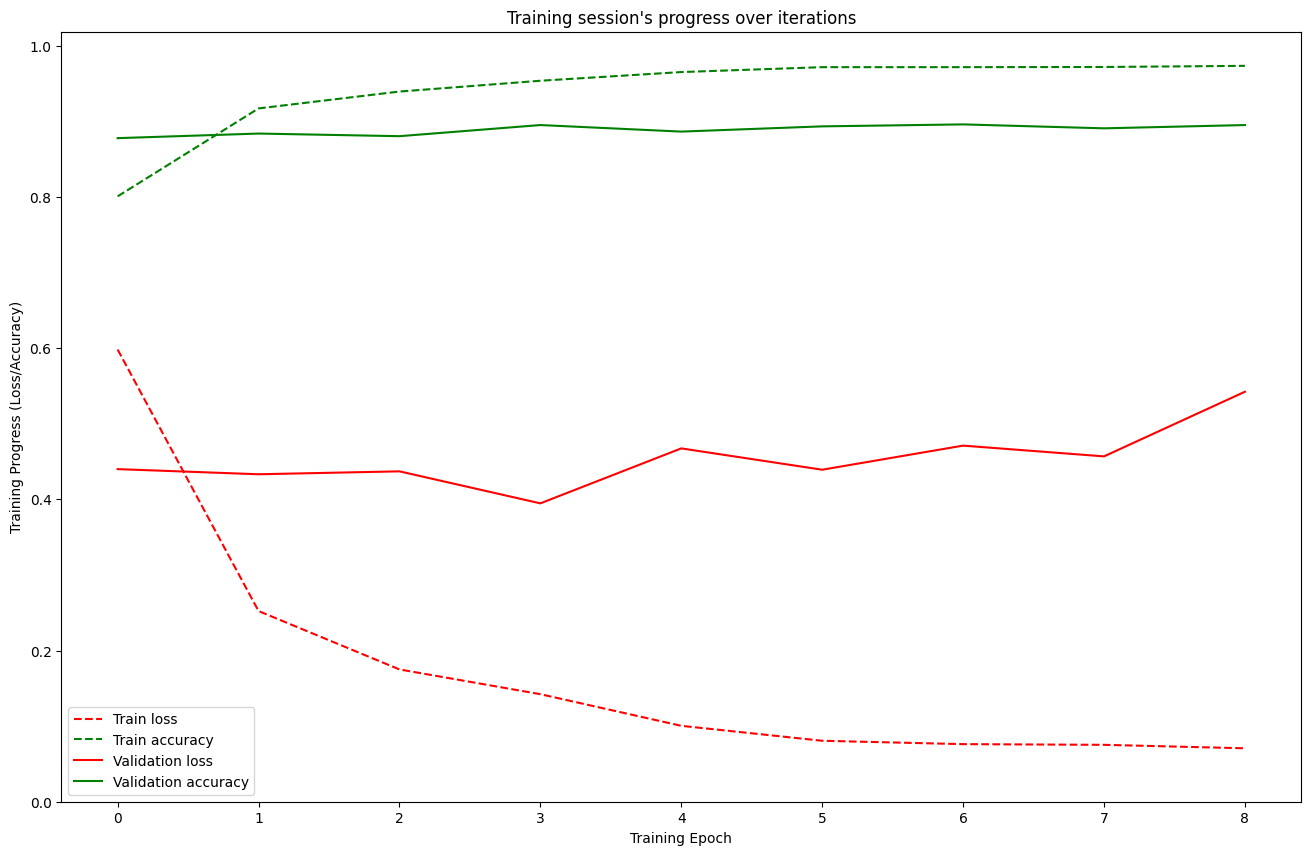

75/75 [==============================] - 0s 2ms/step


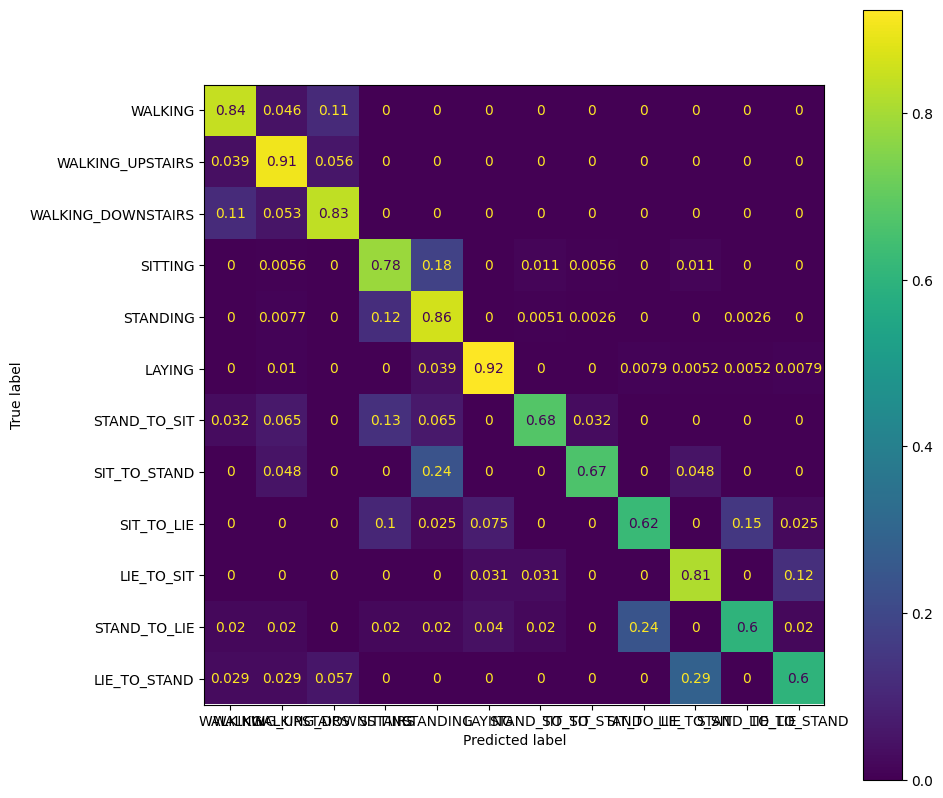

                    precision    recall  f1-score   support

           WALKING       0.85      0.84      0.85       350
  WALKING_UPSTAIRS       0.87      0.91      0.89       359
WALKING_DOWNSTAIRS       0.81      0.83      0.82       320
           SITTING       0.83      0.78      0.81       358
          STANDING       0.79      0.86      0.82       392
            LAYING       0.98      0.92      0.95       382
      STAND_TO_SIT       0.72      0.68      0.70        31
      SIT_TO_STAND       0.78      0.67      0.72        21
        SIT_TO_LIE       0.62      0.62      0.62        40
        LIE_TO_SIT       0.60      0.81      0.69        32
      STAND_TO_LIE       0.77      0.60      0.67        50
      LIE_TO_STAND       0.70      0.60      0.65        35

          accuracy                           0.84      2370
         macro avg       0.78      0.76      0.77      2370
      weighted avg       0.84      0.84      0.84      2370

-----(2, 4)------
Model: "sequential_

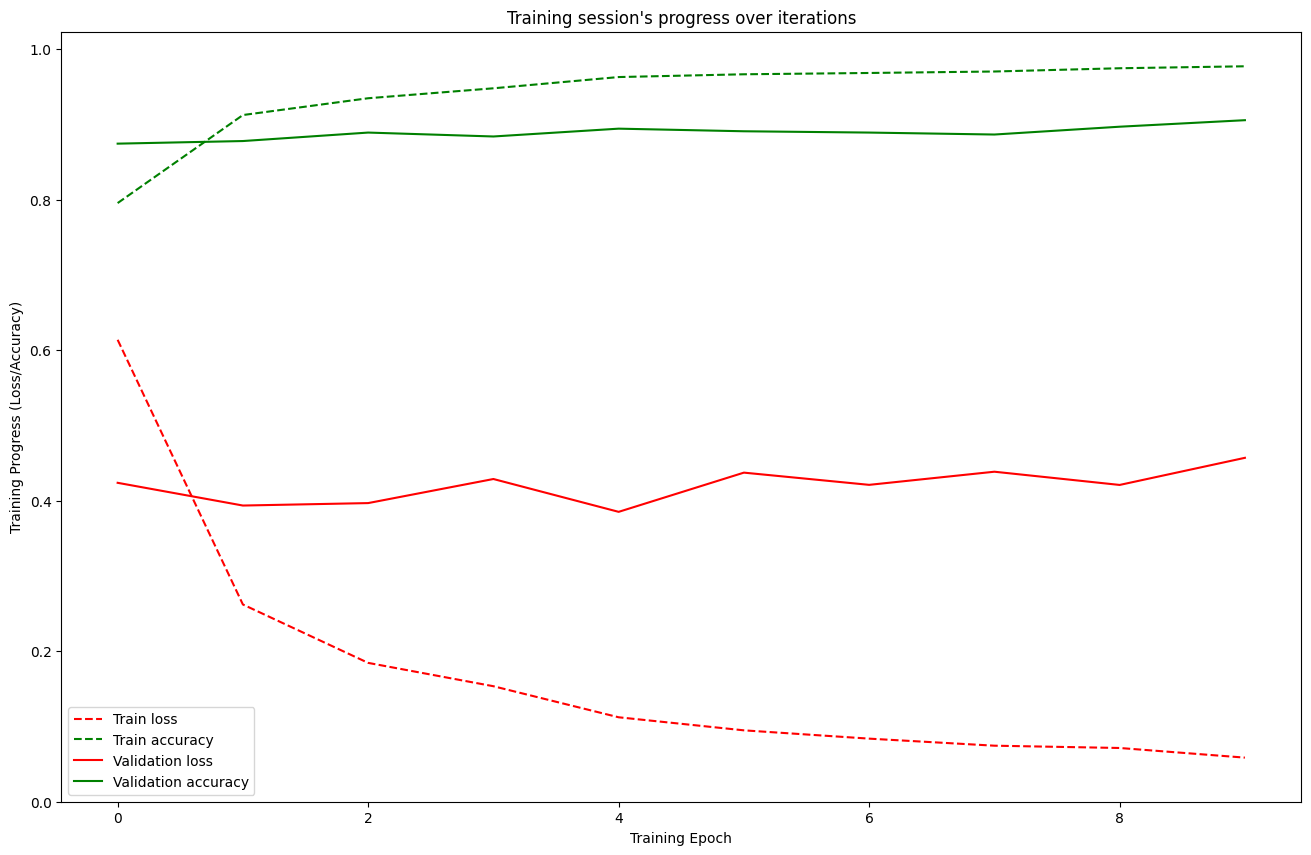

75/75 [==============================] - 0s 2ms/step


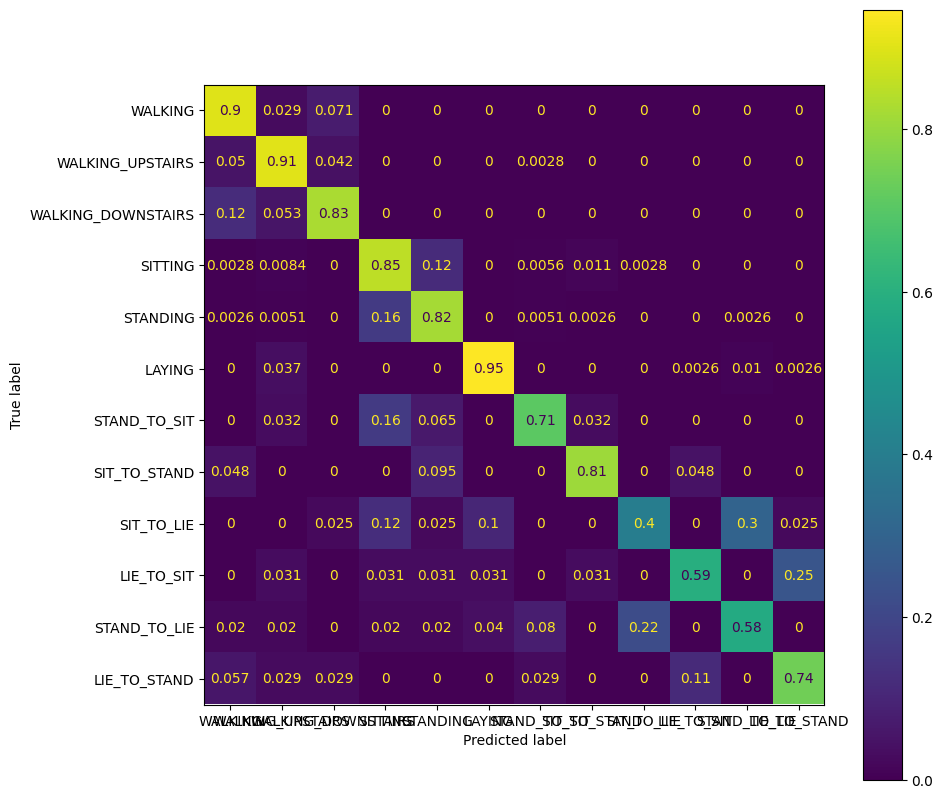

                    precision    recall  f1-score   support

           WALKING       0.84      0.90      0.87       350
  WALKING_UPSTAIRS       0.87      0.91      0.89       359
WALKING_DOWNSTAIRS       0.86      0.83      0.85       320
           SITTING       0.80      0.85      0.83       358
          STANDING       0.87      0.82      0.84       392
            LAYING       0.98      0.95      0.96       382
      STAND_TO_SIT       0.69      0.71      0.70        31
      SIT_TO_STAND       0.71      0.81      0.76        21
        SIT_TO_LIE       0.57      0.40      0.47        40
        LIE_TO_SIT       0.76      0.59      0.67        32
      STAND_TO_LIE       0.63      0.58      0.60        50
      LIE_TO_STAND       0.72      0.74      0.73        35

          accuracy                           0.85      2370
         macro avg       0.77      0.76      0.76      2370
      weighted avg       0.85      0.85      0.85      2370

-----(4, 2)------
Model: "sequential_

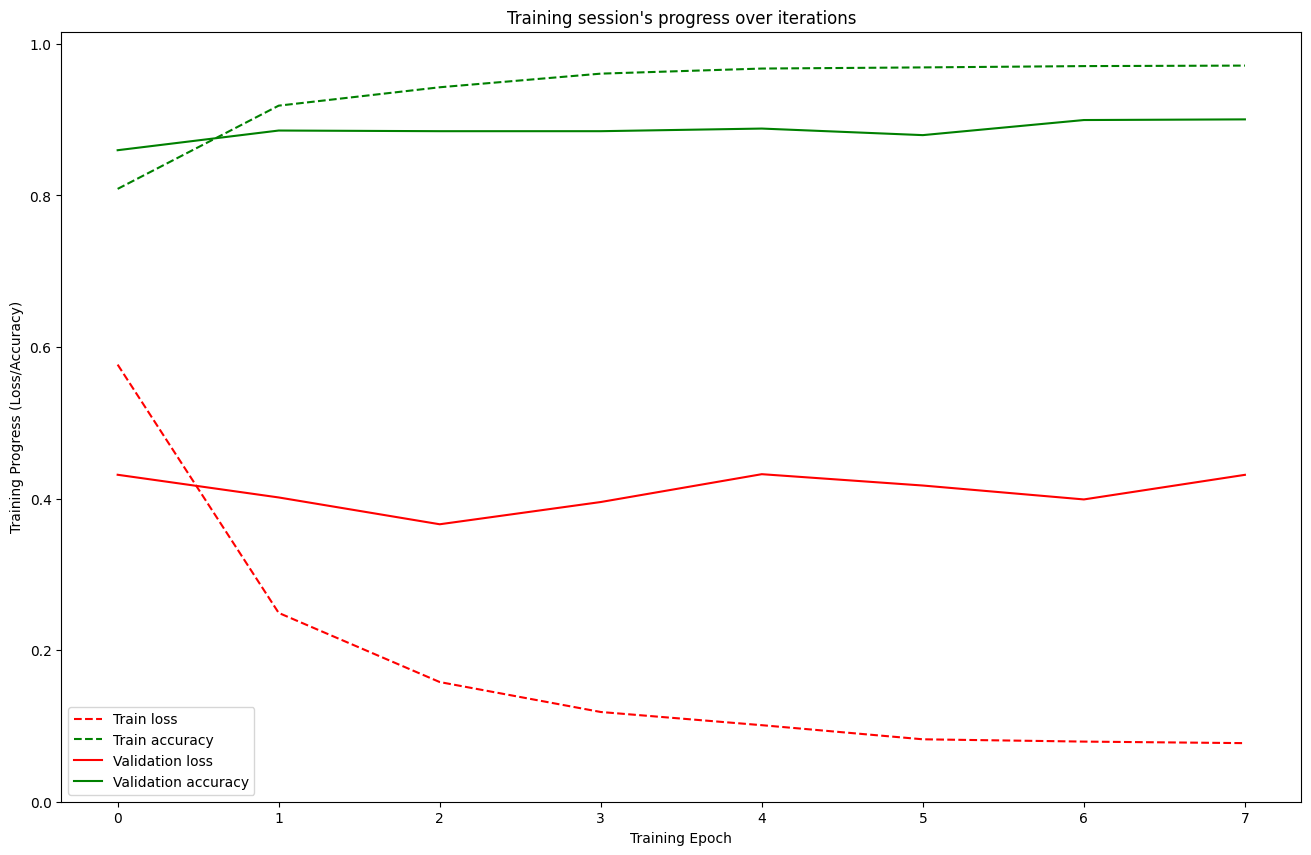

75/75 [==============================] - 0s 3ms/step


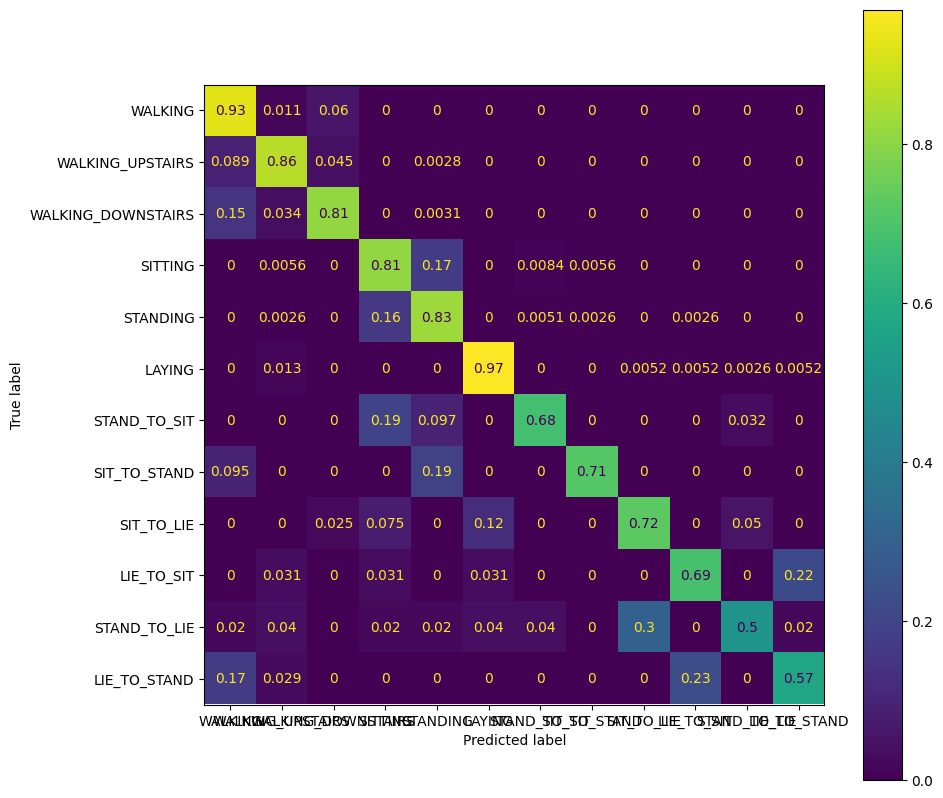

                    precision    recall  f1-score   support

           WALKING       0.79      0.93      0.85       350
  WALKING_UPSTAIRS       0.92      0.86      0.89       359
WALKING_DOWNSTAIRS       0.87      0.81      0.84       320
           SITTING       0.80      0.81      0.80       358
          STANDING       0.82      0.83      0.82       392
            LAYING       0.98      0.97      0.97       382
      STAND_TO_SIT       0.75      0.68      0.71        31
      SIT_TO_STAND       0.83      0.71      0.77        21
        SIT_TO_LIE       0.63      0.72      0.67        40
        LIE_TO_SIT       0.67      0.69      0.68        32
      STAND_TO_LIE       0.86      0.50      0.63        50
      LIE_TO_STAND       0.67      0.57      0.62        35

          accuracy                           0.85      2370
         macro avg       0.80      0.76      0.77      2370
      weighted avg       0.85      0.85      0.85      2370

-----(3, 4)------
Model: "sequential_

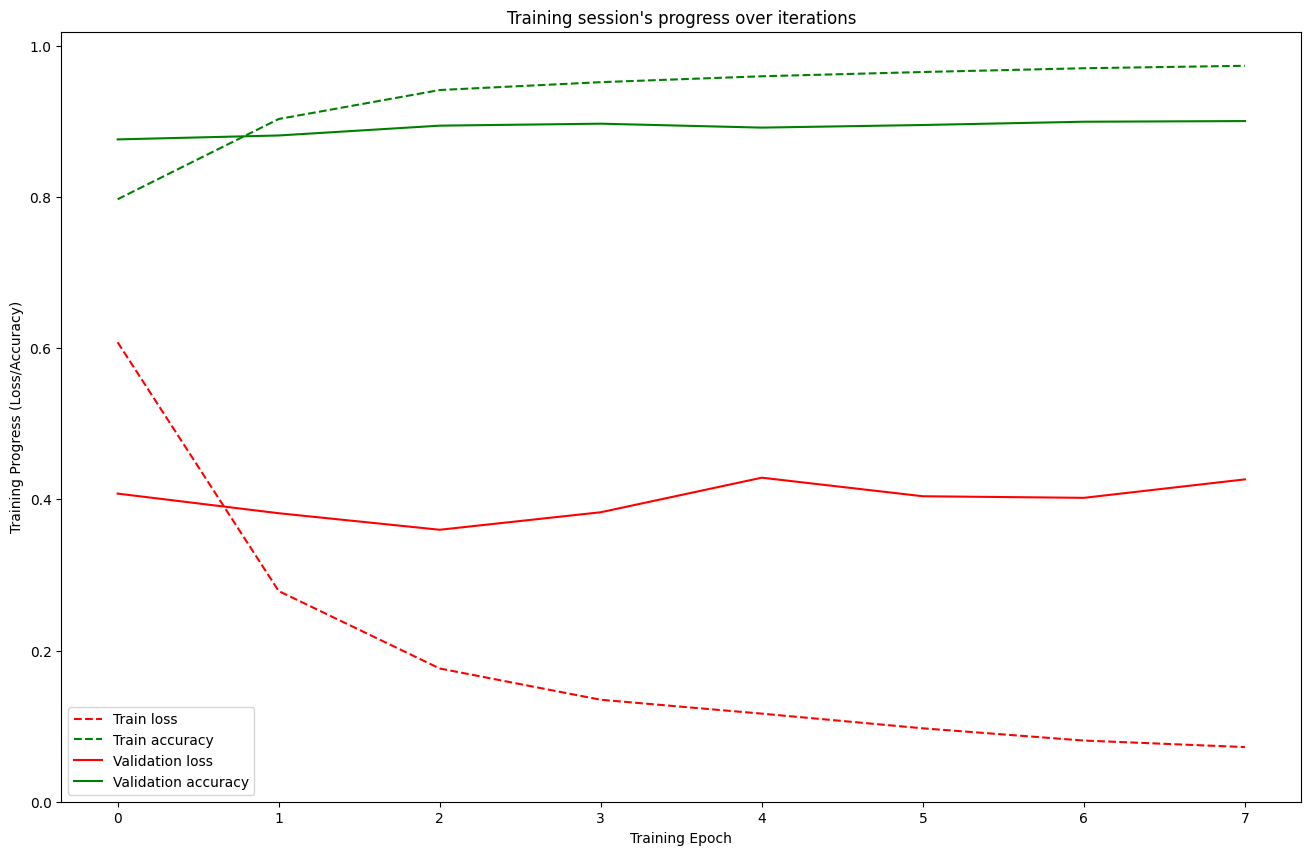

75/75 [==============================] - 0s 2ms/step


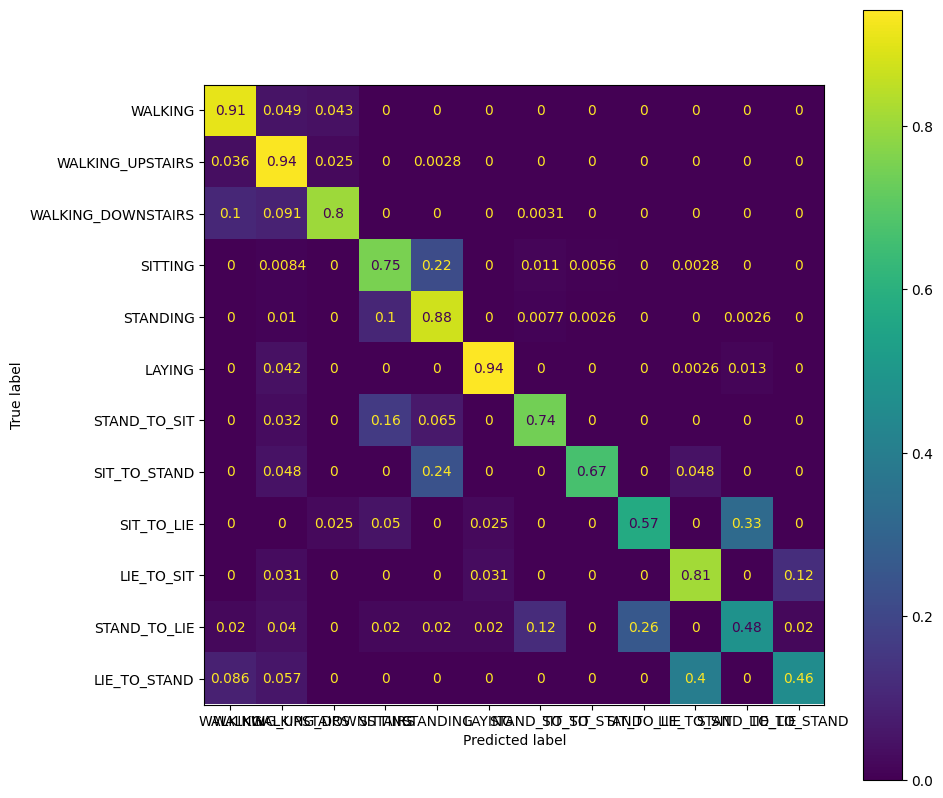

                    precision    recall  f1-score   support

           WALKING       0.86      0.91      0.89       350
  WALKING_UPSTAIRS       0.82      0.94      0.87       359
WALKING_DOWNSTAIRS       0.91      0.80      0.85       320
           SITTING       0.85      0.75      0.80       358
          STANDING       0.80      0.88      0.83       392
            LAYING       0.99      0.94      0.97       382
      STAND_TO_SIT       0.62      0.74      0.68        31
      SIT_TO_STAND       0.82      0.67      0.74        21
        SIT_TO_LIE       0.64      0.57      0.61        40
        LIE_TO_SIT       0.60      0.81      0.69        32
      STAND_TO_LIE       0.56      0.48      0.52        50
      LIE_TO_STAND       0.76      0.46      0.57        35

          accuracy                           0.85      2370
         macro avg       0.77      0.75      0.75      2370
      weighted avg       0.85      0.85      0.85      2370

-----(4, 3)------
Model: "sequential_

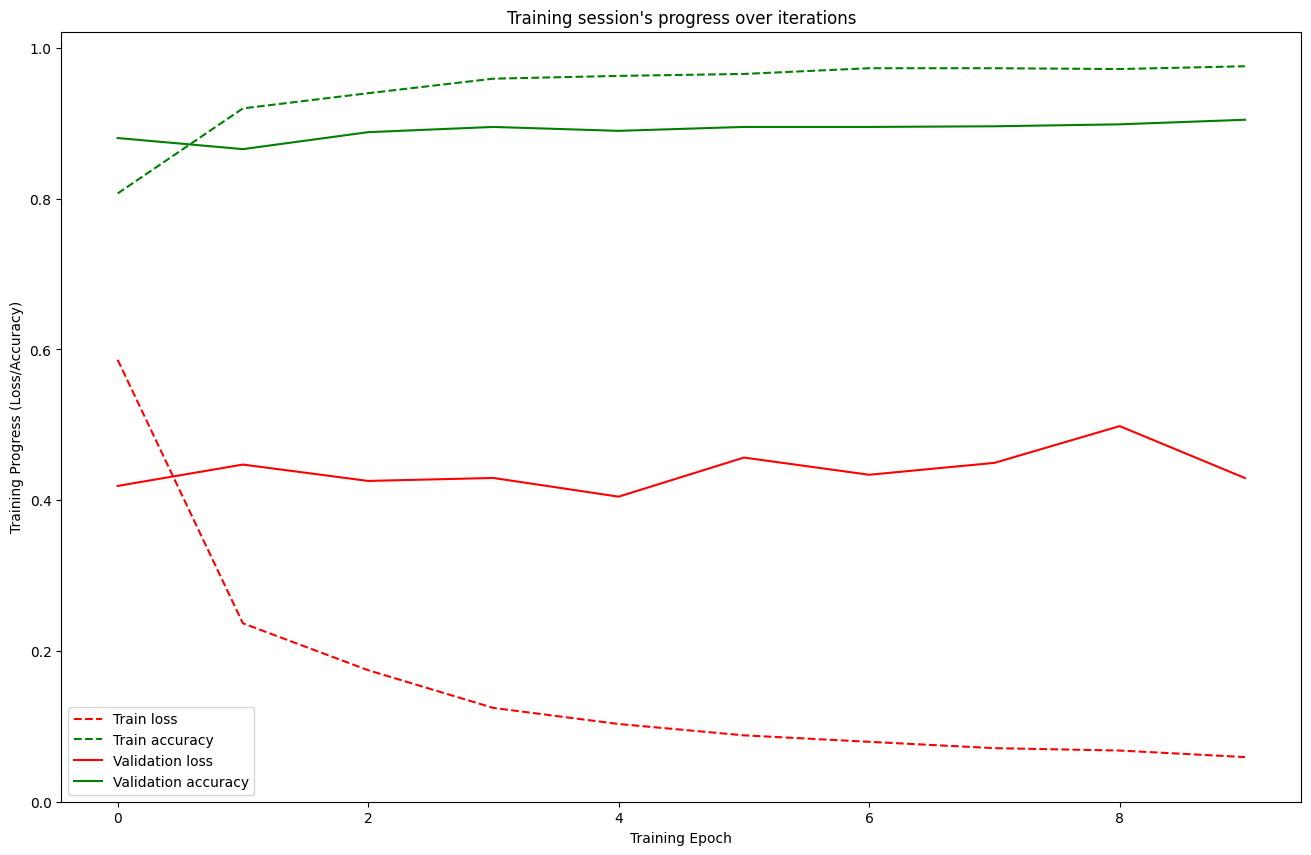

75/75 [==============================] - 0s 2ms/step


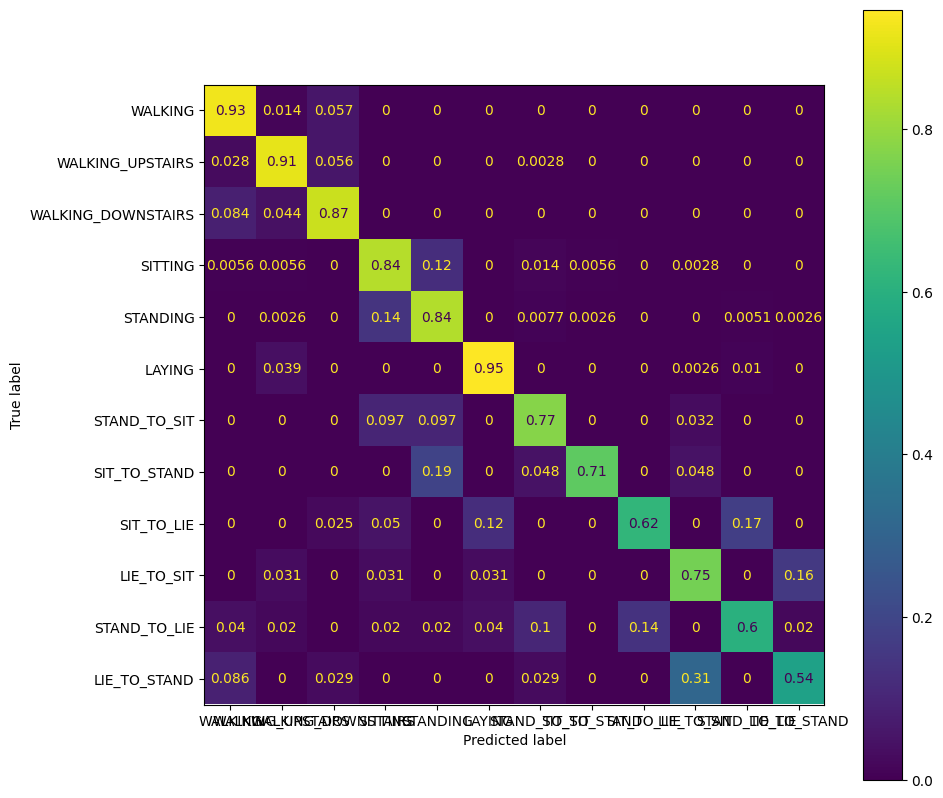

                    precision    recall  f1-score   support

           WALKING       0.88      0.93      0.90       350
  WALKING_UPSTAIRS       0.89      0.91      0.90       359
WALKING_DOWNSTAIRS       0.87      0.87      0.87       320
           SITTING       0.83      0.84      0.84       358
          STANDING       0.86      0.84      0.85       392
            LAYING       0.98      0.95      0.96       382
      STAND_TO_SIT       0.60      0.77      0.68        31
      SIT_TO_STAND       0.83      0.71      0.77        21
        SIT_TO_LIE       0.78      0.62      0.69        40
        LIE_TO_SIT       0.62      0.75      0.68        32
      STAND_TO_LIE       0.70      0.60      0.65        50
      LIE_TO_STAND       0.73      0.54      0.62        35

          accuracy                           0.87      2370
         macro avg       0.80      0.78      0.78      2370
      weighted avg       0.87      0.87      0.87      2370

-----(5, 5)------
Model: "sequential_

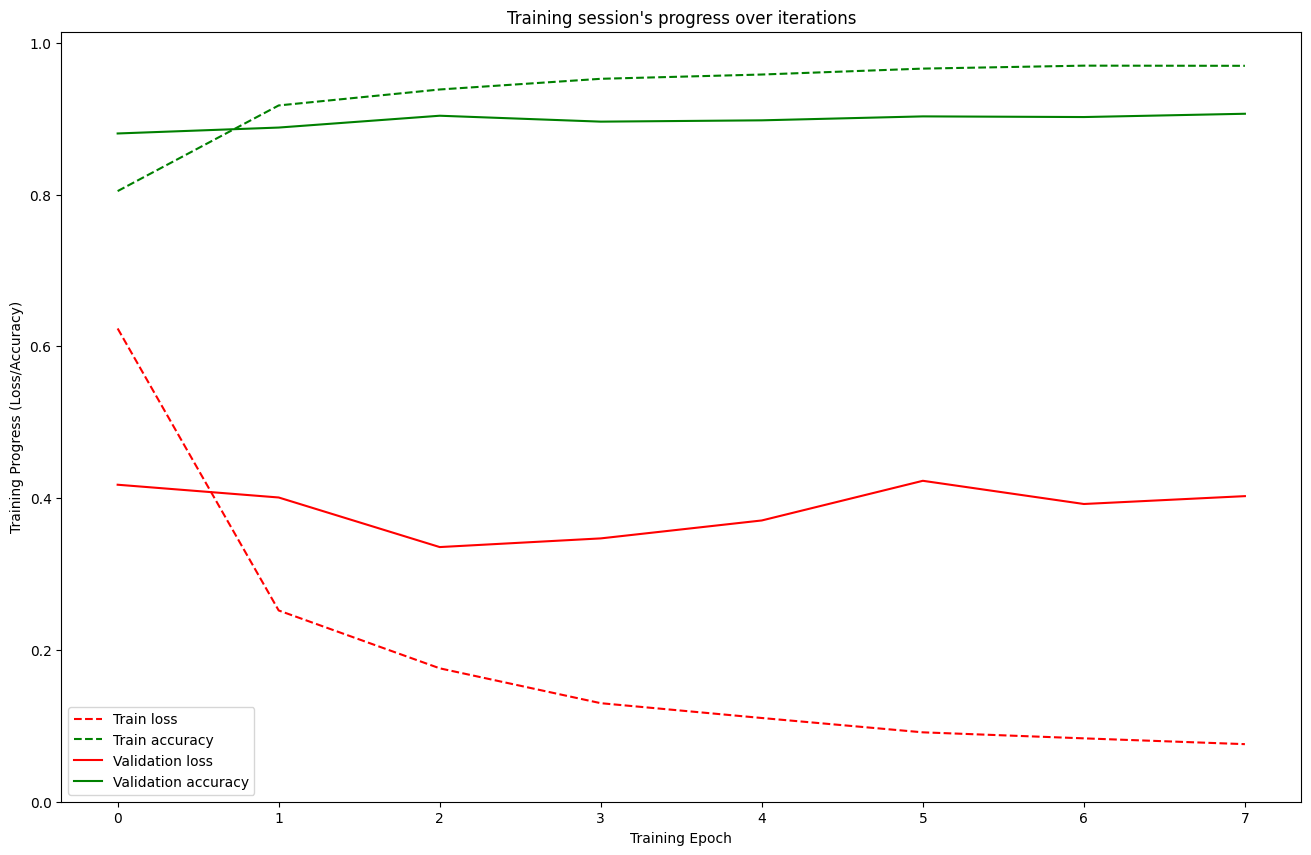

75/75 [==============================] - 0s 2ms/step


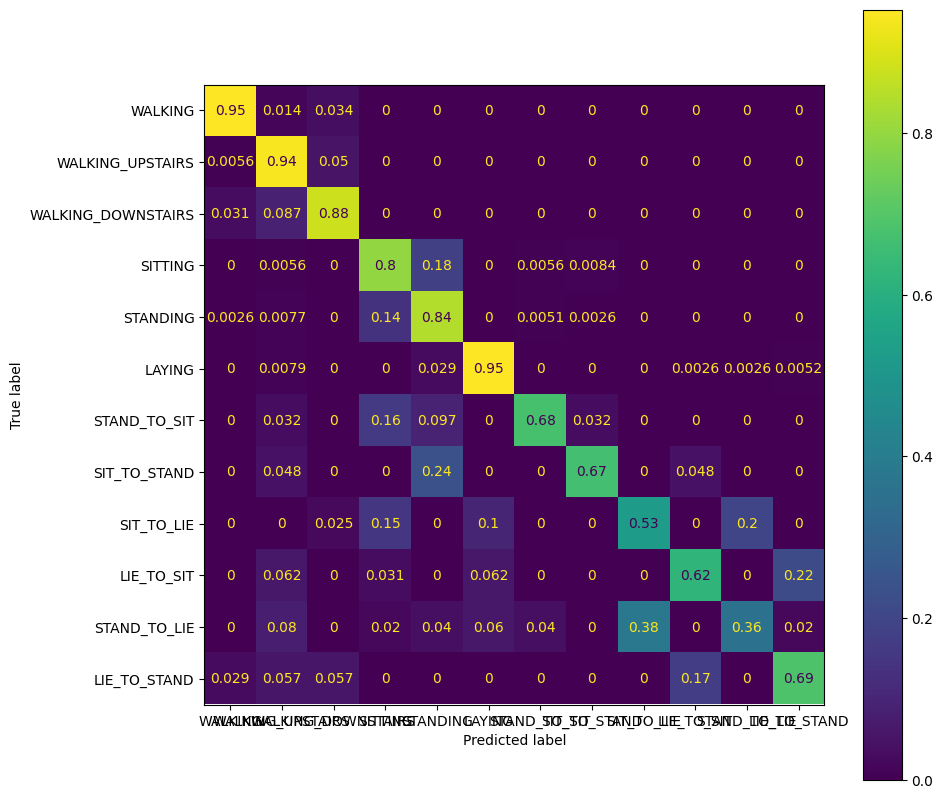

                    precision    recall  f1-score   support

           WALKING       0.96      0.95      0.96       350
  WALKING_UPSTAIRS       0.87      0.94      0.91       359
WALKING_DOWNSTAIRS       0.90      0.88      0.89       320
           SITTING       0.81      0.80      0.80       358
          STANDING       0.79      0.84      0.82       392
            LAYING       0.98      0.95      0.96       382
      STAND_TO_SIT       0.78      0.68      0.72        31
      SIT_TO_STAND       0.74      0.67      0.70        21
        SIT_TO_LIE       0.53      0.53      0.53        40
        LIE_TO_SIT       0.71      0.62      0.67        32
      STAND_TO_LIE       0.67      0.36      0.47        50
      LIE_TO_STAND       0.71      0.69      0.70        35

          accuracy                           0.87      2370
         macro avg       0.79      0.74      0.76      2370
      weighted avg       0.86      0.87      0.86      2370

-----(6, 6)------
Model: "sequential_

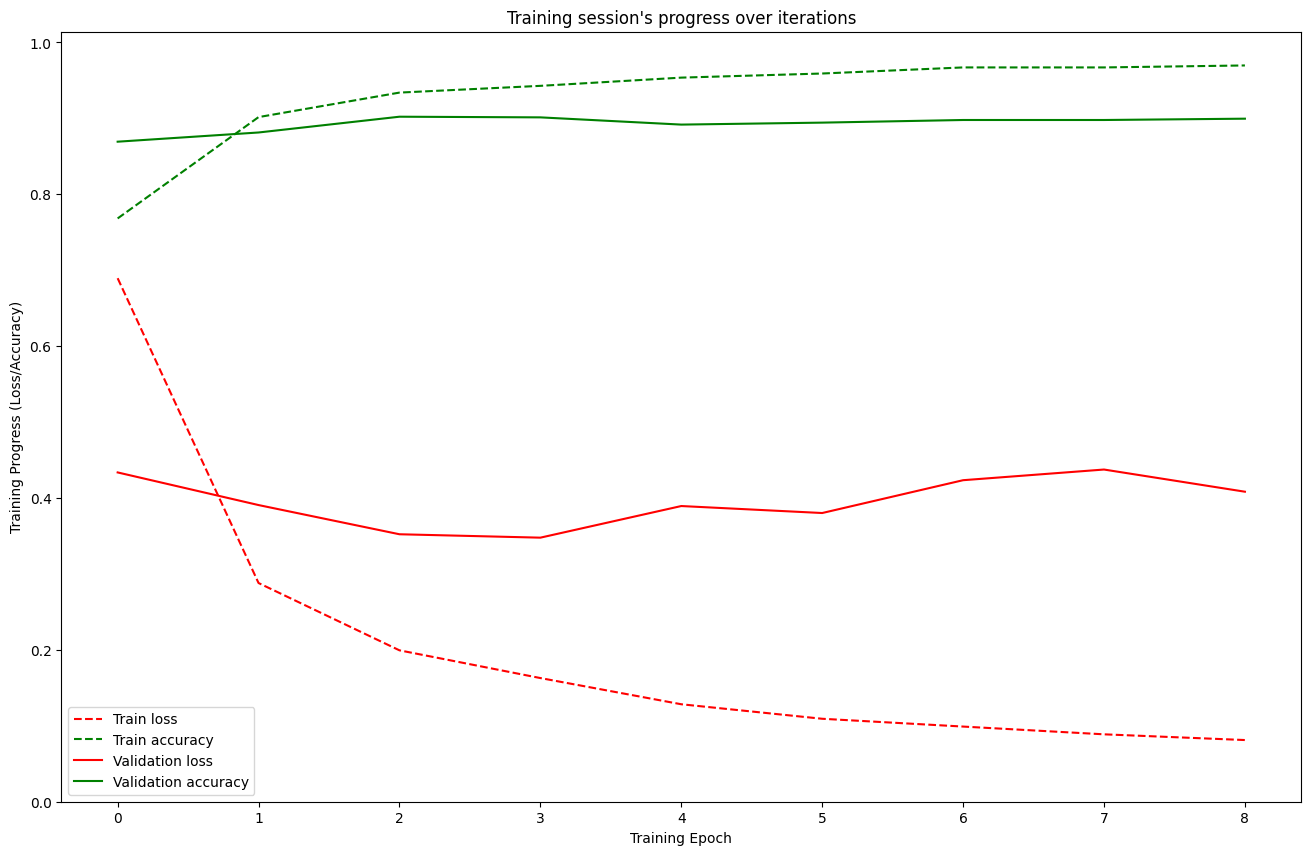

75/75 [==============================] - 0s 2ms/step


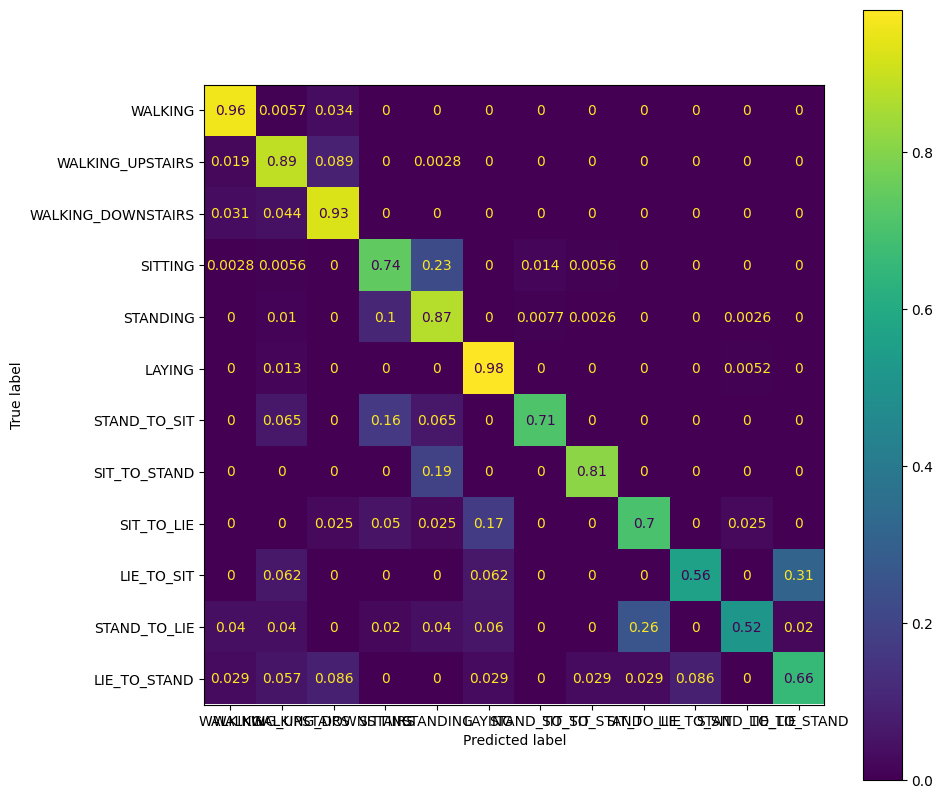

                    precision    recall  f1-score   support

           WALKING       0.94      0.96      0.95       350
  WALKING_UPSTAIRS       0.90      0.89      0.89       359
WALKING_DOWNSTAIRS       0.86      0.93      0.89       320
           SITTING       0.84      0.74      0.79       358
          STANDING       0.79      0.87      0.83       392
            LAYING       0.97      0.98      0.97       382
      STAND_TO_SIT       0.73      0.71      0.72        31
      SIT_TO_STAND       0.81      0.81      0.81        21
        SIT_TO_LIE       0.67      0.70      0.68        40
        LIE_TO_SIT       0.86      0.56      0.68        32
      STAND_TO_LIE       0.87      0.52      0.65        50
      LIE_TO_STAND       0.68      0.66      0.67        35

          accuracy                           0.87      2370
         macro avg       0.83      0.78      0.79      2370
      weighted avg       0.87      0.87      0.87      2370



In [ ]:
#Testing kernels with base layer
kernels=[(2,2),(3,3),(4,4),(2,3),(3,2),(2,4),(4,2),(3,4),(4,3),(5,5),(6,6)]

for k in kernels:
    print(f"-----{k}------")
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=k, activation='relu', input_shape=x_train[0].shape))

    model.add(Flatten())

    model.add(Dense(13, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',
                    metrics=['accuracy'])
    print(model.summary())

    #----------------------------------
    history = model.fit(x_train, y_train, epochs=epoch, validation_split=0.2, verbose=1, callbacks = callback)
    plot_learningCurve(history)
    show_confusion_mat(model)

----4, (2, 2)-----
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 199, 5, 4)         20        
                                                                 
 flatten_17 (Flatten)        (None, 3980)              0         
                                                                 
 dense_17 (Dense)            (None, 13)                51753     
                                                                 
Total params: 51,773
Trainable params: 51,773
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
145/145 [==============================] - 1s 6ms/step - loss: 0.6597 - accuracy: 0.7714 - val_loss: 0.4911 - val_accuracy: 0.8485
Epoch 2/20
145/145 [==============================] - 1s 5ms/step - loss: 0.3030 - accuracy: 0.8962 - val_loss: 0.4330 - val_accuracy: 0.8727
Epoch

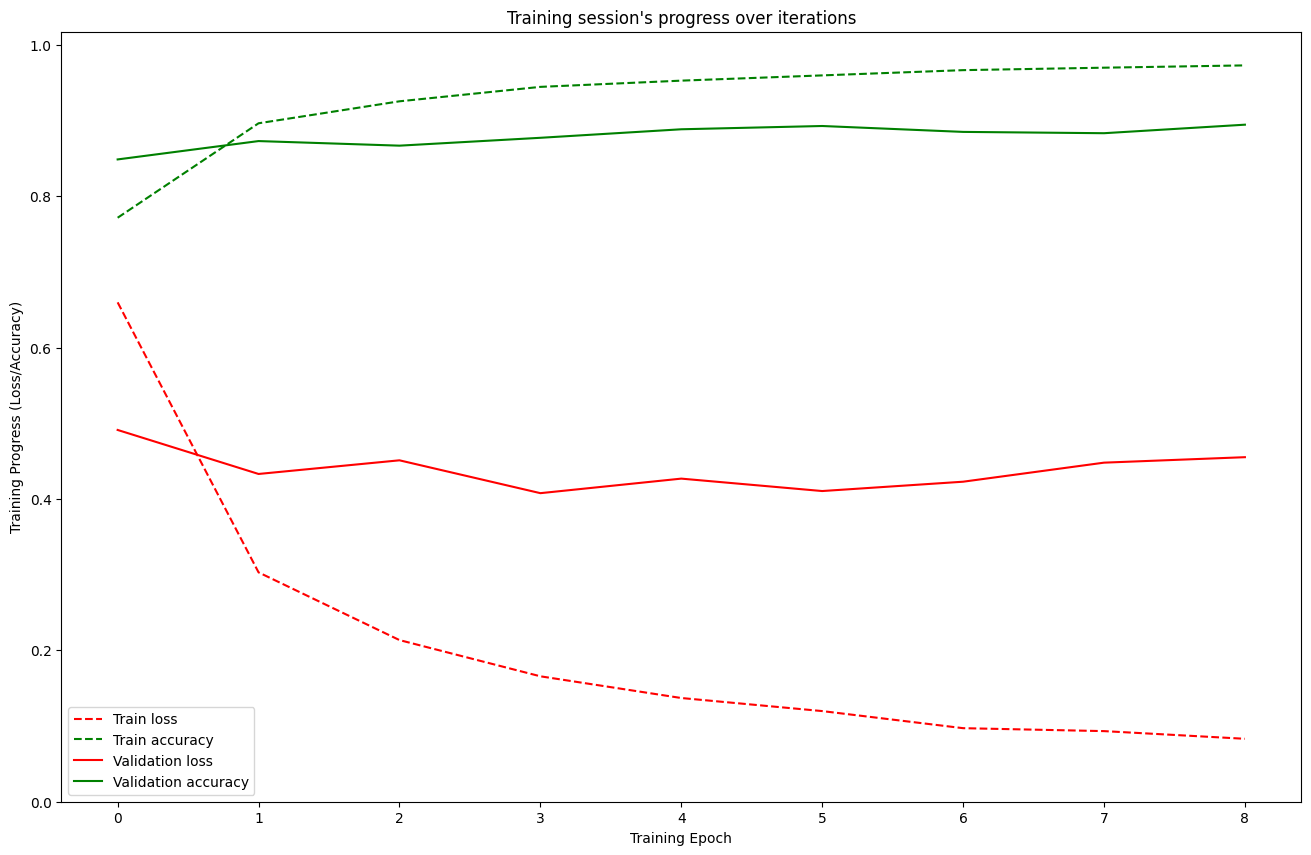

75/75 [==============================] - 0s 1ms/step


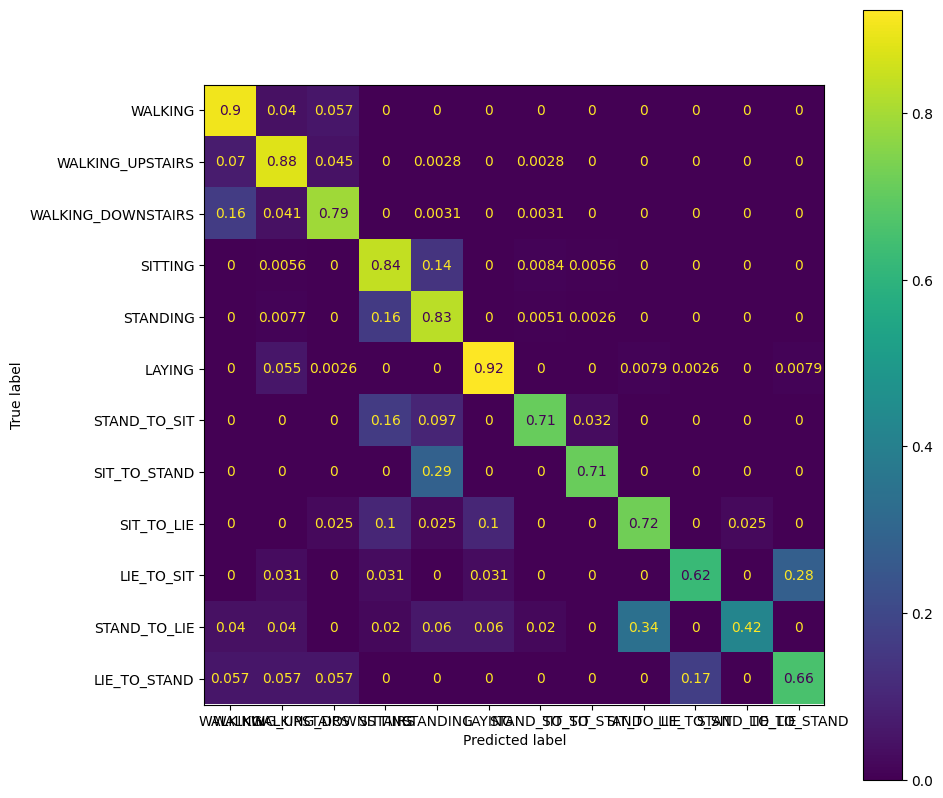

                    precision    recall  f1-score   support

           WALKING       0.80      0.90      0.85       350
  WALKING_UPSTAIRS       0.84      0.88      0.86       359
WALKING_DOWNSTAIRS       0.86      0.79      0.83       320
           SITTING       0.81      0.84      0.82       358
          STANDING       0.83      0.83      0.83       392
            LAYING       0.98      0.92      0.95       382
      STAND_TO_SIT       0.73      0.71      0.72        31
      SIT_TO_STAND       0.79      0.71      0.75        21
        SIT_TO_LIE       0.59      0.72      0.65        40
        LIE_TO_SIT       0.74      0.62      0.68        32
      STAND_TO_LIE       0.95      0.42      0.58        50
      LIE_TO_STAND       0.66      0.66      0.66        35

          accuracy                           0.84      2370
         macro avg       0.80      0.75      0.77      2370
      weighted avg       0.85      0.84      0.84      2370

----4, (3, 3)-----
Model: "sequential

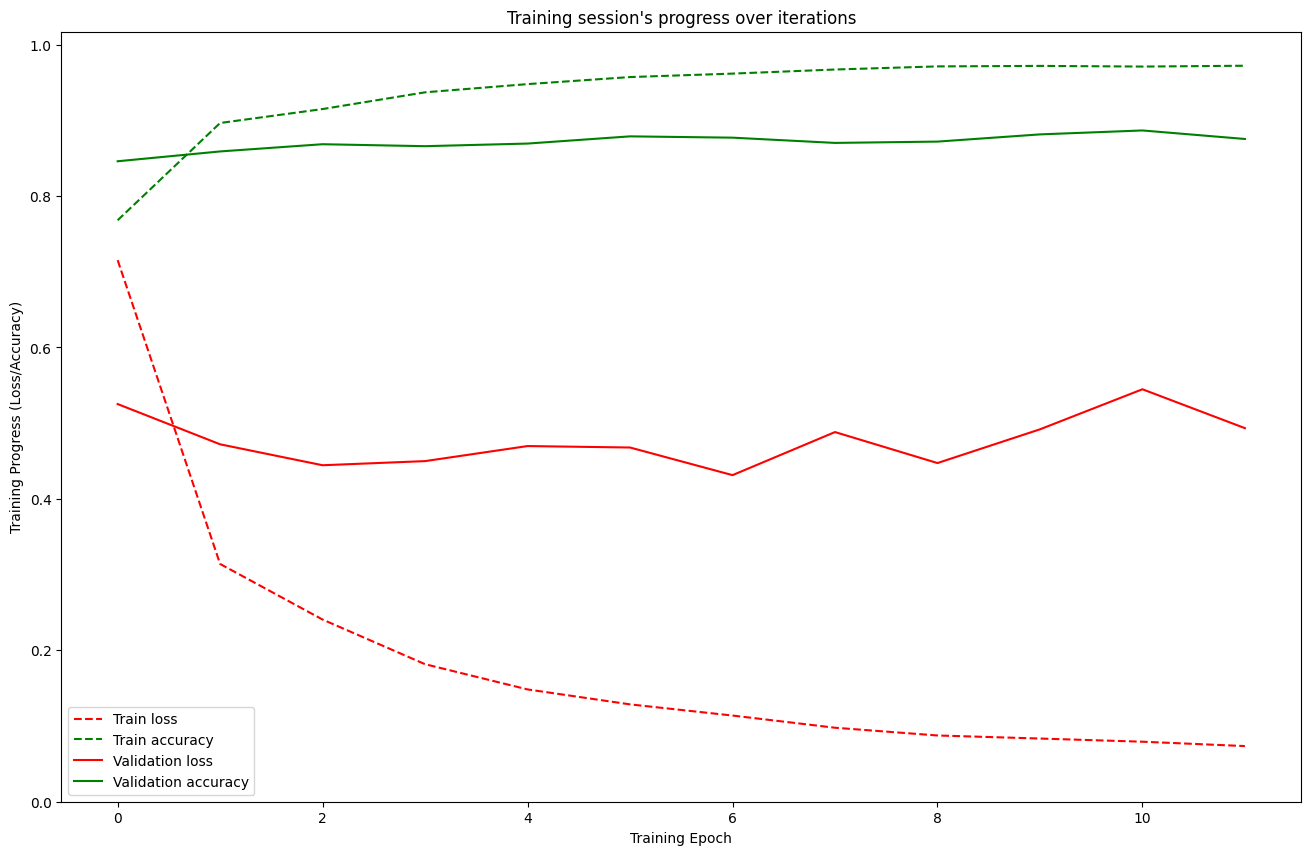

75/75 [==============================] - 0s 3ms/step


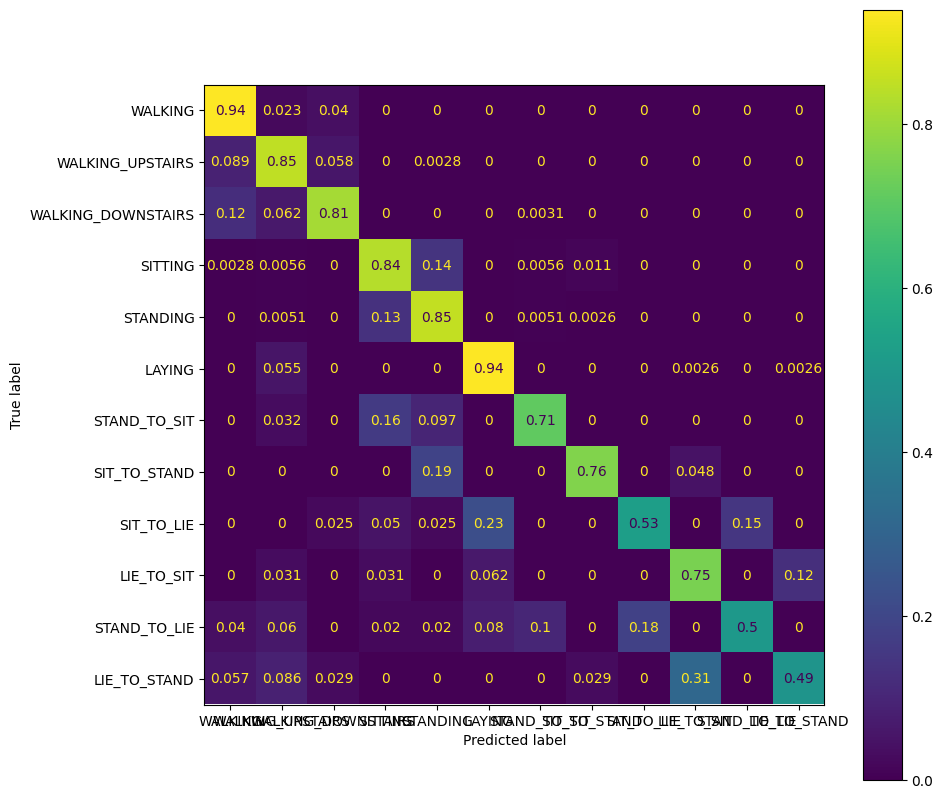

                    precision    recall  f1-score   support

           WALKING       0.81      0.94      0.87       350
  WALKING_UPSTAIRS       0.83      0.85      0.84       359
WALKING_DOWNSTAIRS       0.88      0.81      0.84       320
           SITTING       0.83      0.84      0.83       358
          STANDING       0.85      0.85      0.85       392
            LAYING       0.96      0.94      0.95       382
      STAND_TO_SIT       0.69      0.71      0.70        31
      SIT_TO_STAND       0.73      0.76      0.74        21
        SIT_TO_LIE       0.70      0.53      0.60        40
        LIE_TO_SIT       0.65      0.75      0.70        32
      STAND_TO_LIE       0.81      0.50      0.62        50
      LIE_TO_STAND       0.77      0.49      0.60        35

          accuracy                           0.85      2370
         macro avg       0.79      0.75      0.76      2370
      weighted avg       0.85      0.85      0.85      2370

----4, (4, 4)-----
Model: "sequential

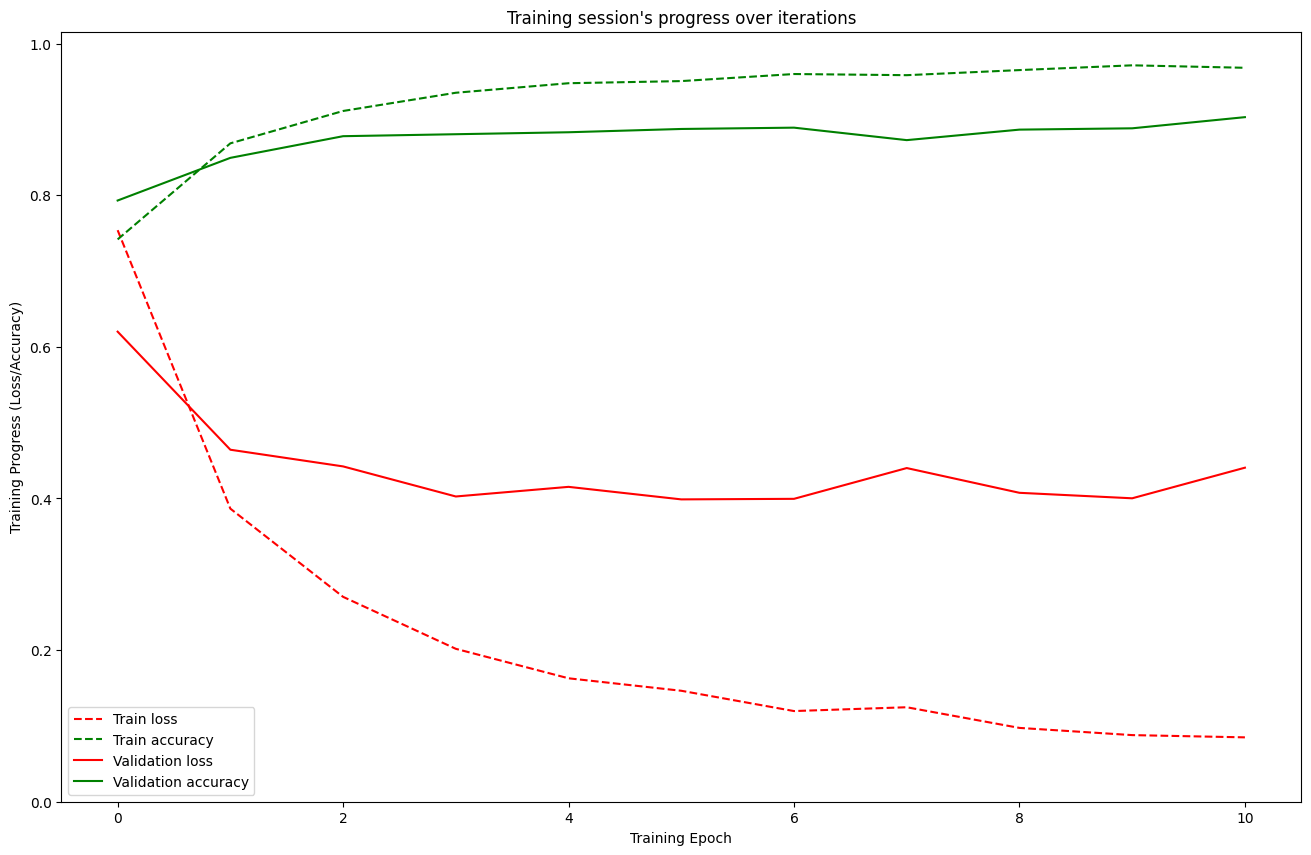

75/75 [==============================] - 0s 2ms/step


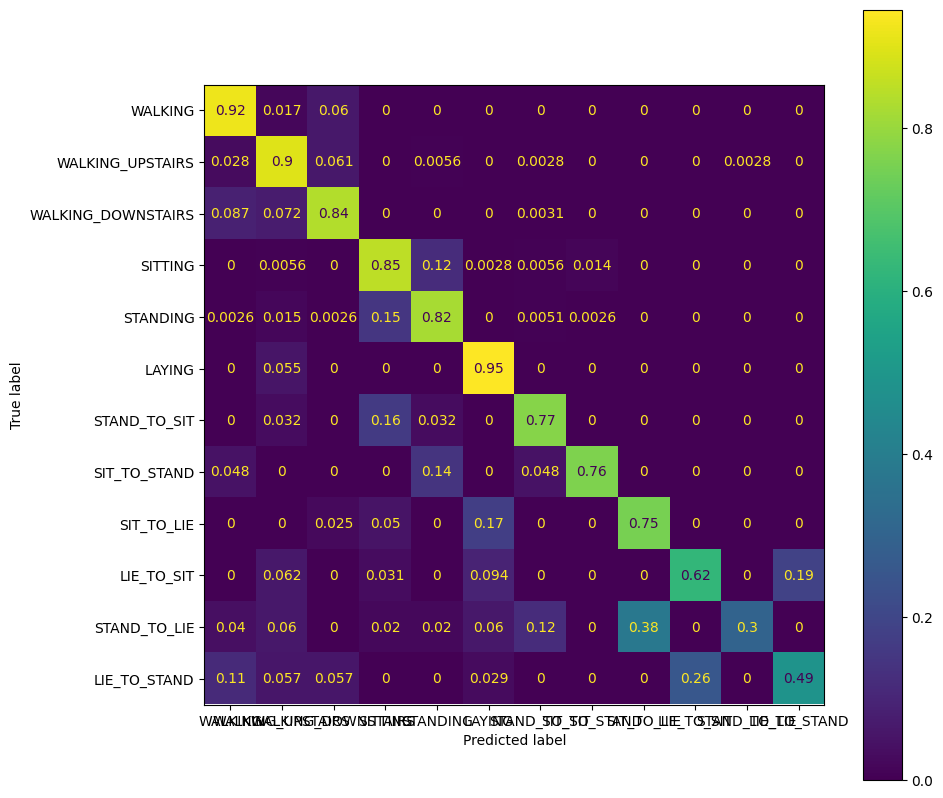

                    precision    recall  f1-score   support

           WALKING       0.88      0.92      0.90       350
  WALKING_UPSTAIRS       0.83      0.90      0.86       359
WALKING_DOWNSTAIRS       0.85      0.84      0.84       320
           SITTING       0.82      0.85      0.83       358
          STANDING       0.87      0.82      0.84       392
            LAYING       0.96      0.95      0.95       382
      STAND_TO_SIT       0.65      0.77      0.71        31
      SIT_TO_STAND       0.73      0.76      0.74        21
        SIT_TO_LIE       0.61      0.75      0.67        40
        LIE_TO_SIT       0.69      0.62      0.66        32
      STAND_TO_LIE       0.94      0.30      0.45        50
      LIE_TO_STAND       0.74      0.49      0.59        35

          accuracy                           0.85      2370
         macro avg       0.80      0.75      0.75      2370
      weighted avg       0.86      0.85      0.85      2370

----4, (5, 5)-----
Model: "sequential

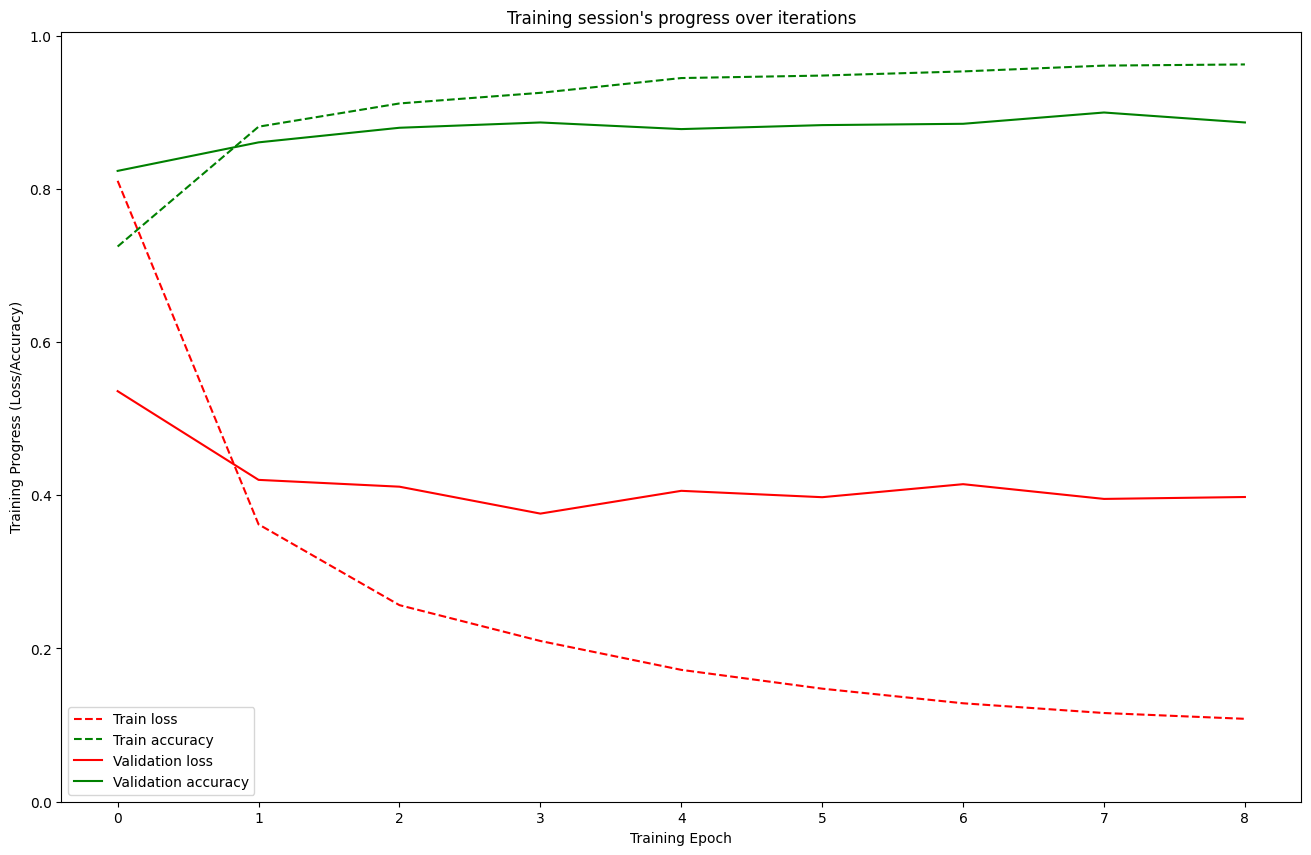

75/75 [==============================] - 0s 2ms/step


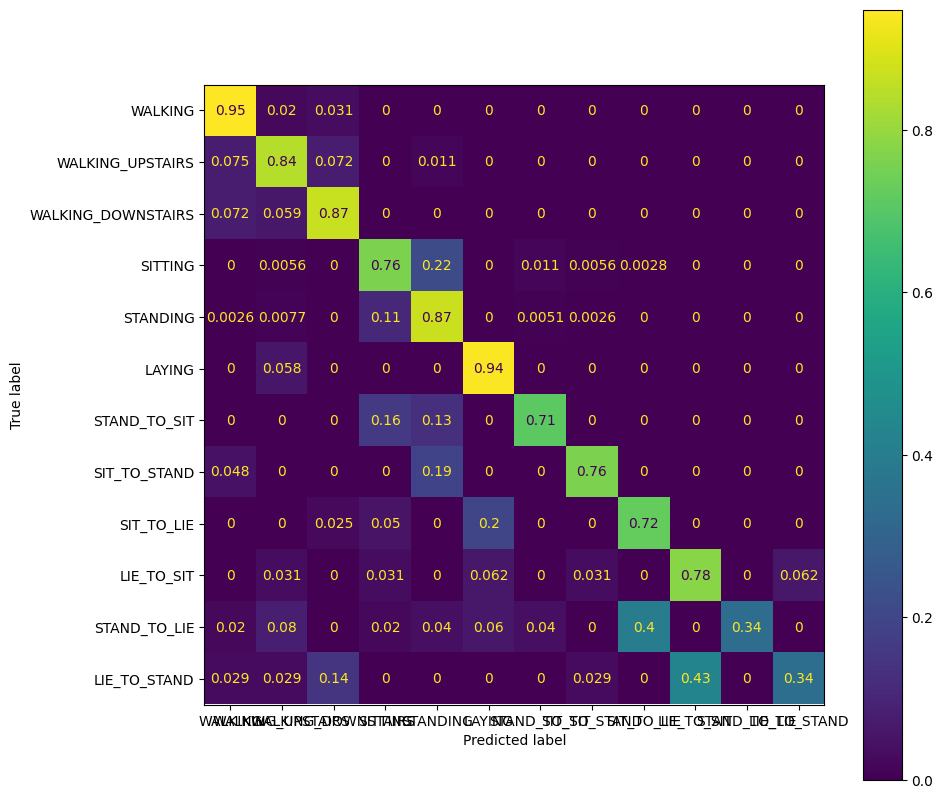

                    precision    recall  f1-score   support

           WALKING       0.86      0.95      0.90       350
  WALKING_UPSTAIRS       0.84      0.84      0.84       359
WALKING_DOWNSTAIRS       0.87      0.87      0.87       320
           SITTING       0.84      0.76      0.80       358
          STANDING       0.79      0.87      0.83       392
            LAYING       0.97      0.94      0.95       382
      STAND_TO_SIT       0.73      0.71      0.72        31
      SIT_TO_STAND       0.76      0.76      0.76        21
        SIT_TO_LIE       0.58      0.72      0.64        40
        LIE_TO_SIT       0.62      0.78      0.69        32
      STAND_TO_LIE       1.00      0.34      0.51        50
      LIE_TO_STAND       0.86      0.34      0.49        35

          accuracy                           0.85      2370
         macro avg       0.81      0.74      0.75      2370
      weighted avg       0.85      0.85      0.84      2370

----4, (6, 6)-----
Model: "sequential

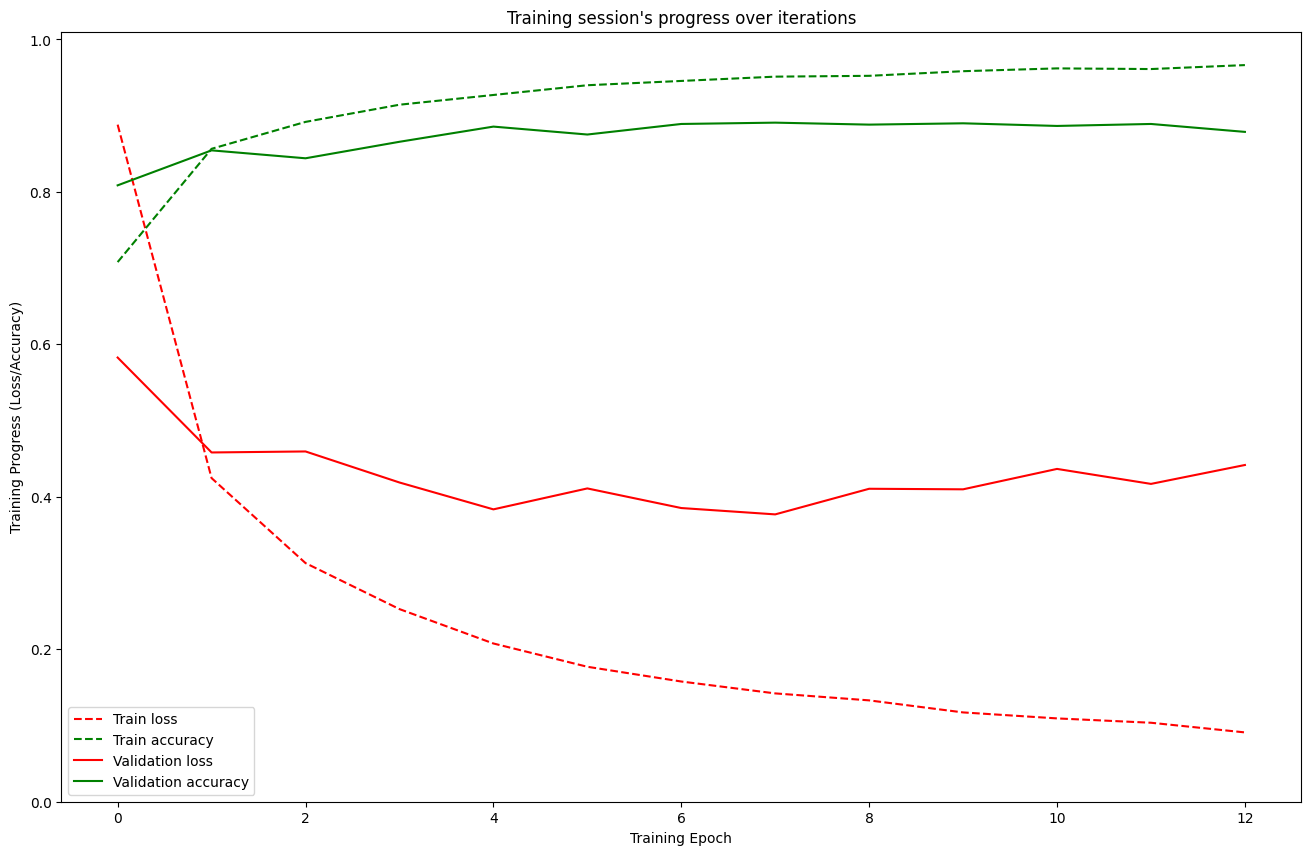

75/75 [==============================] - 0s 3ms/step


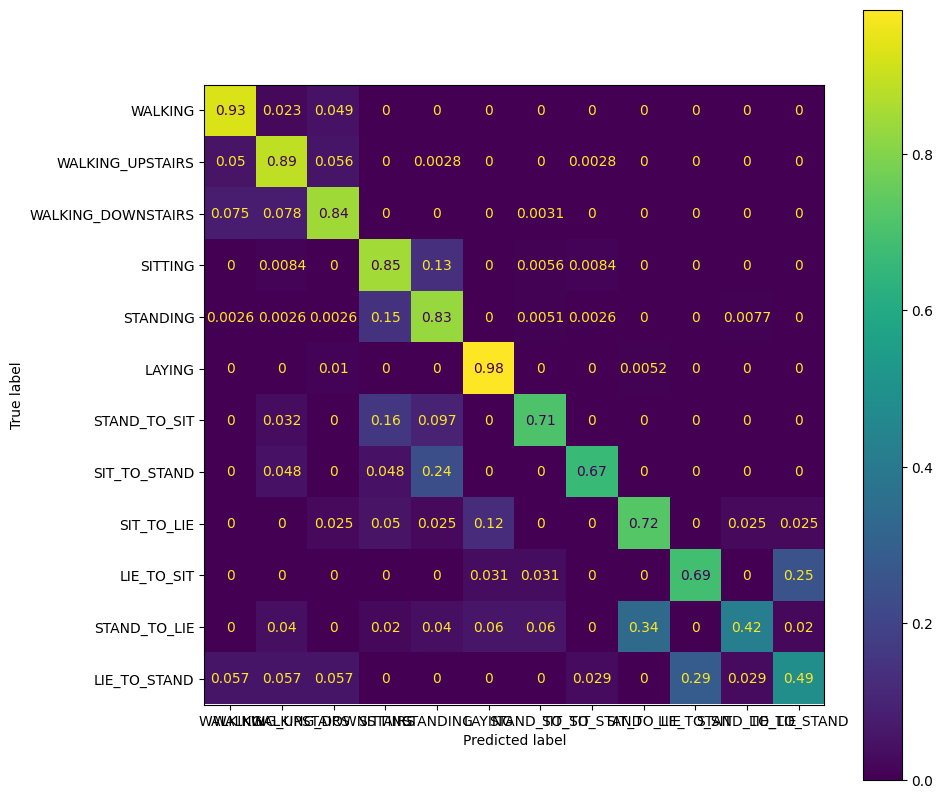

                    precision    recall  f1-score   support

           WALKING       0.88      0.93      0.90       350
  WALKING_UPSTAIRS       0.88      0.89      0.88       359
WALKING_DOWNSTAIRS       0.86      0.84      0.85       320
           SITTING       0.82      0.85      0.83       358
          STANDING       0.85      0.83      0.84       392
            LAYING       0.98      0.98      0.98       382
      STAND_TO_SIT       0.71      0.71      0.71        31
      SIT_TO_STAND       0.70      0.67      0.68        21
        SIT_TO_LIE       0.60      0.72      0.66        40
        LIE_TO_SIT       0.69      0.69      0.69        32
      STAND_TO_LIE       0.81      0.42      0.55        50
      LIE_TO_STAND       0.63      0.49      0.55        35

          accuracy                           0.86      2370
         macro avg       0.78      0.75      0.76      2370
      weighted avg       0.86      0.86      0.86      2370

----8, (2, 2)-----
Model: "sequential

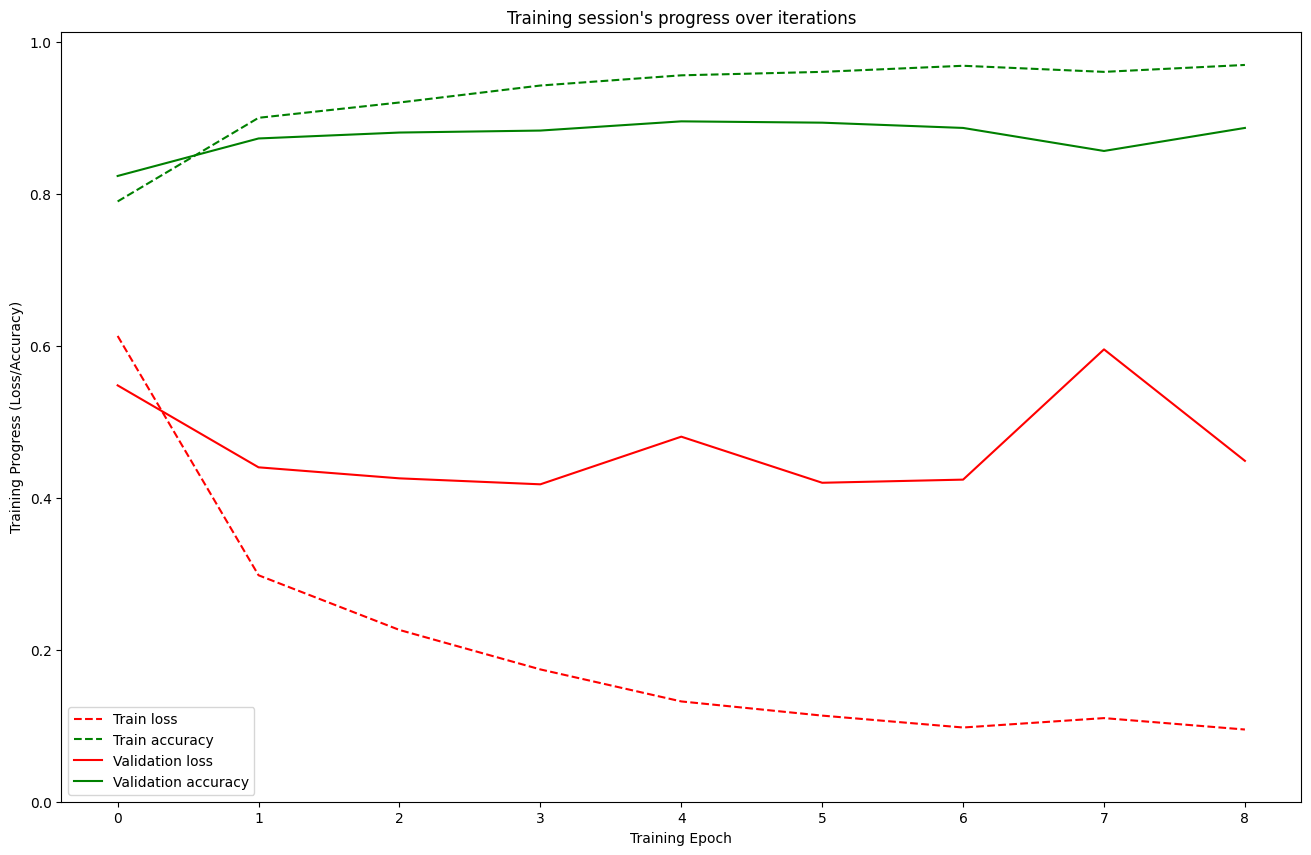

75/75 [==============================] - 0s 2ms/step


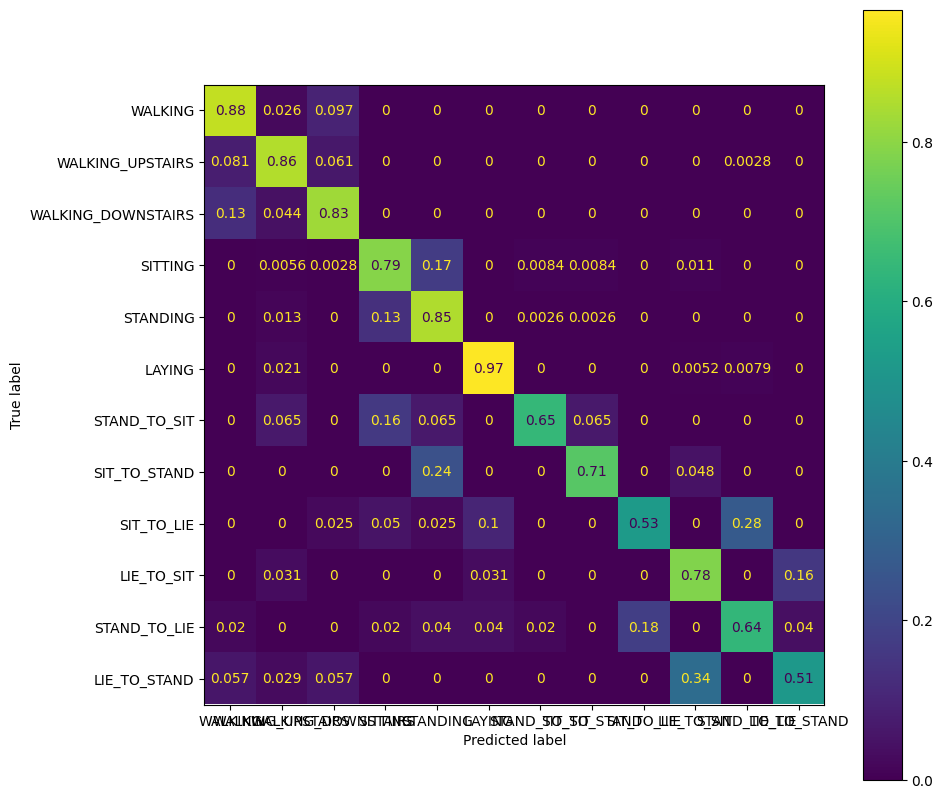

                    precision    recall  f1-score   support

           WALKING       0.81      0.88      0.84       350
  WALKING_UPSTAIRS       0.88      0.86      0.87       359
WALKING_DOWNSTAIRS       0.82      0.83      0.82       320
           SITTING       0.83      0.79      0.81       358
          STANDING       0.82      0.85      0.84       392
            LAYING       0.98      0.97      0.97       382
      STAND_TO_SIT       0.80      0.65      0.71        31
      SIT_TO_STAND       0.71      0.71      0.71        21
        SIT_TO_LIE       0.70      0.53      0.60        40
        LIE_TO_SIT       0.57      0.78      0.66        32
      STAND_TO_LIE       0.68      0.64      0.66        50
      LIE_TO_STAND       0.72      0.51      0.60        35

          accuracy                           0.84      2370
         macro avg       0.78      0.75      0.76      2370
      weighted avg       0.84      0.84      0.84      2370

----8, (3, 3)-----
Model: "sequential

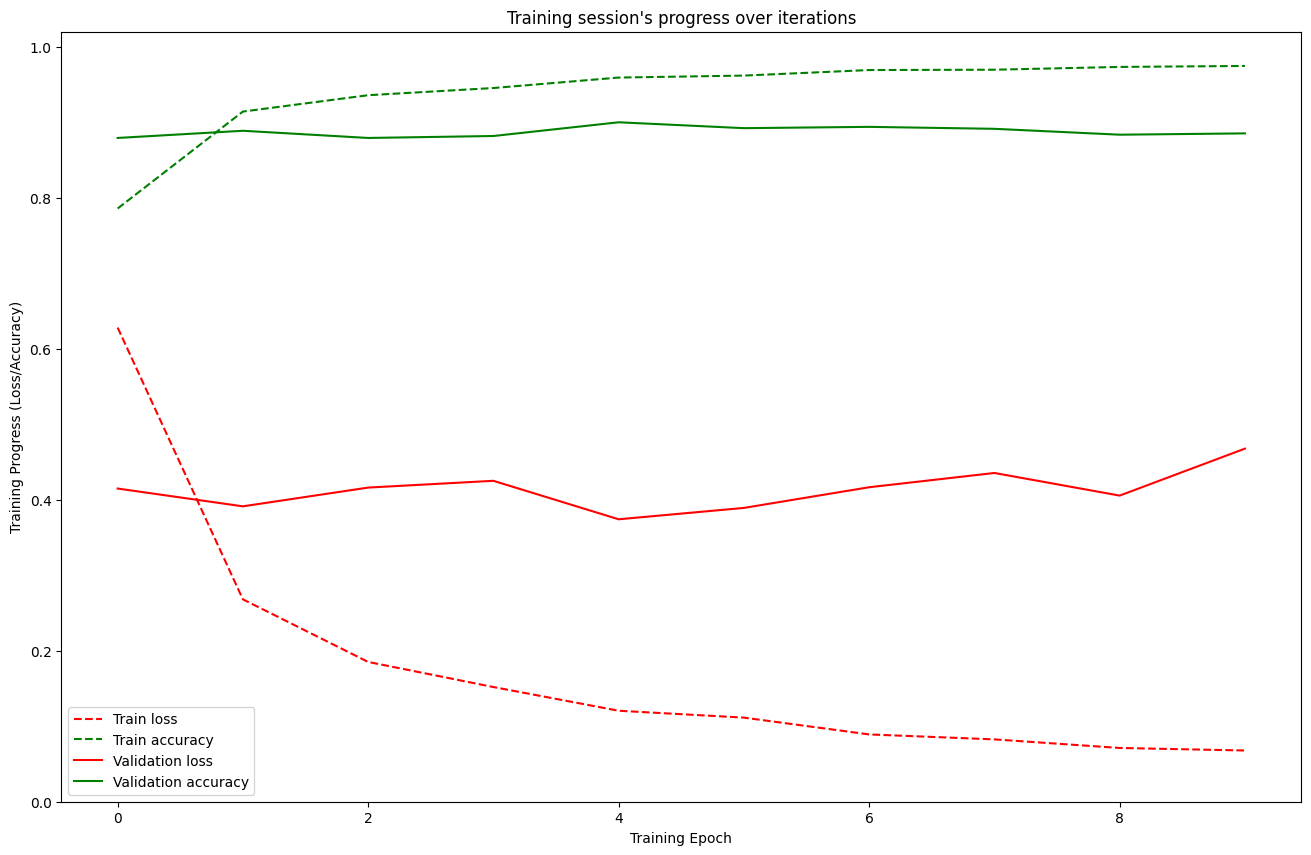

75/75 [==============================] - 0s 3ms/step


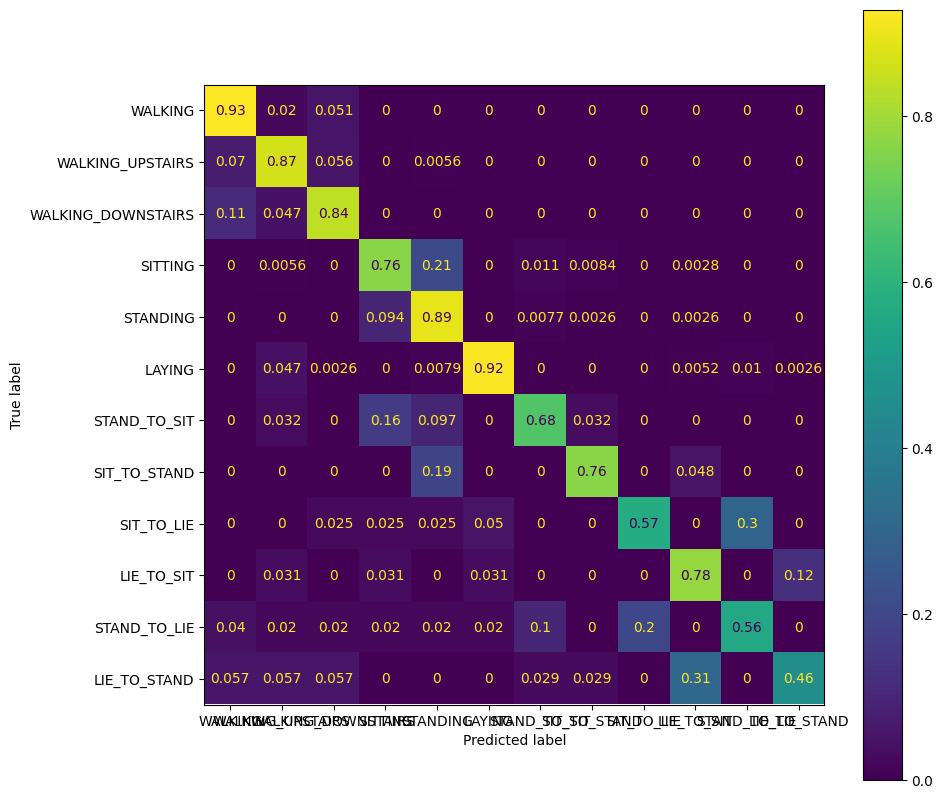

                    precision    recall  f1-score   support

           WALKING       0.83      0.93      0.88       350
  WALKING_UPSTAIRS       0.87      0.87      0.87       359
WALKING_DOWNSTAIRS       0.86      0.84      0.85       320
           SITTING       0.86      0.76      0.81       358
          STANDING       0.80      0.89      0.84       392
            LAYING       0.99      0.92      0.96       382
      STAND_TO_SIT       0.62      0.68      0.65        31
      SIT_TO_STAND       0.73      0.76      0.74        21
        SIT_TO_LIE       0.70      0.57      0.63        40
        LIE_TO_SIT       0.61      0.78      0.68        32
      STAND_TO_LIE       0.64      0.56      0.60        50
      LIE_TO_STAND       0.76      0.46      0.57        35

          accuracy                           0.85      2370
         macro avg       0.77      0.75      0.76      2370
      weighted avg       0.85      0.85      0.85      2370

----8, (4, 4)-----
Model: "sequential

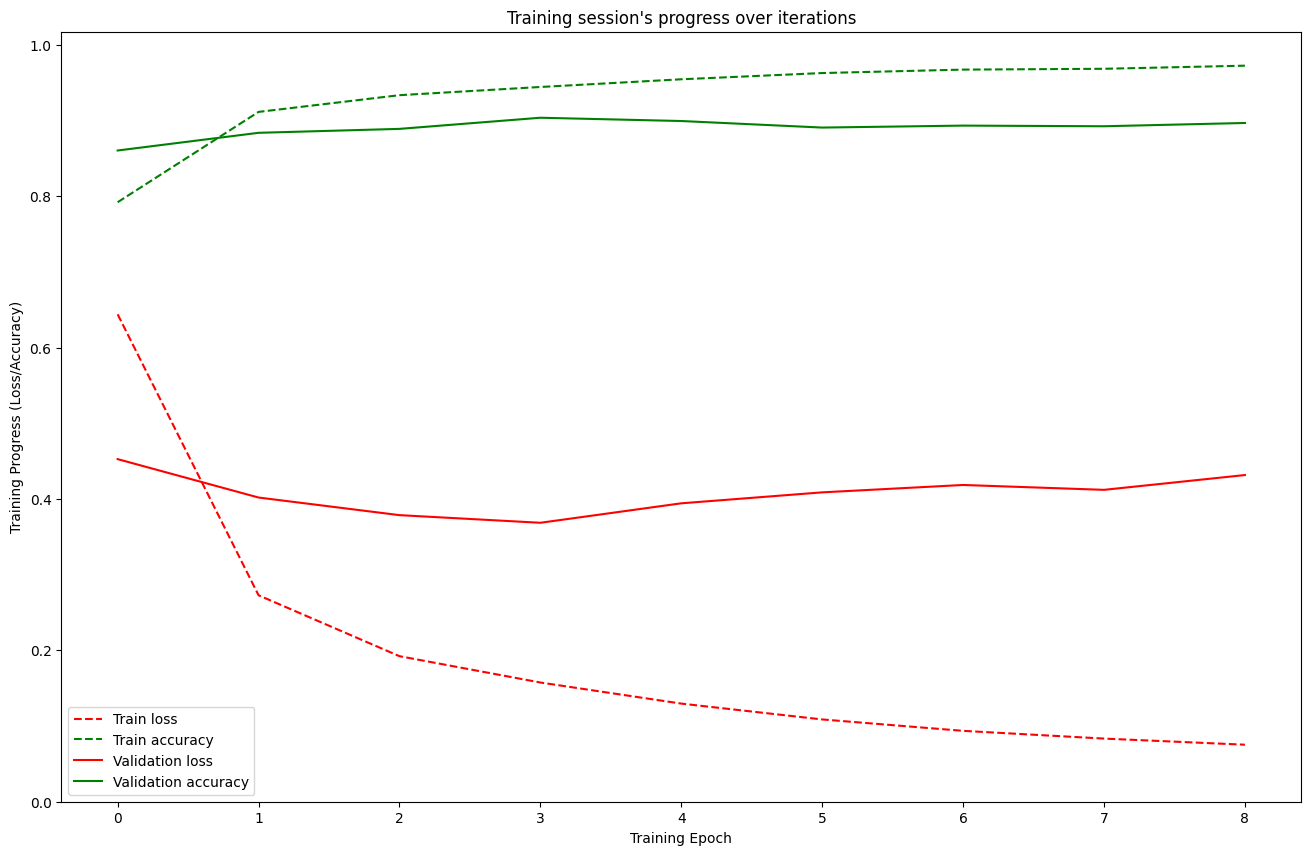

75/75 [==============================] - 0s 2ms/step


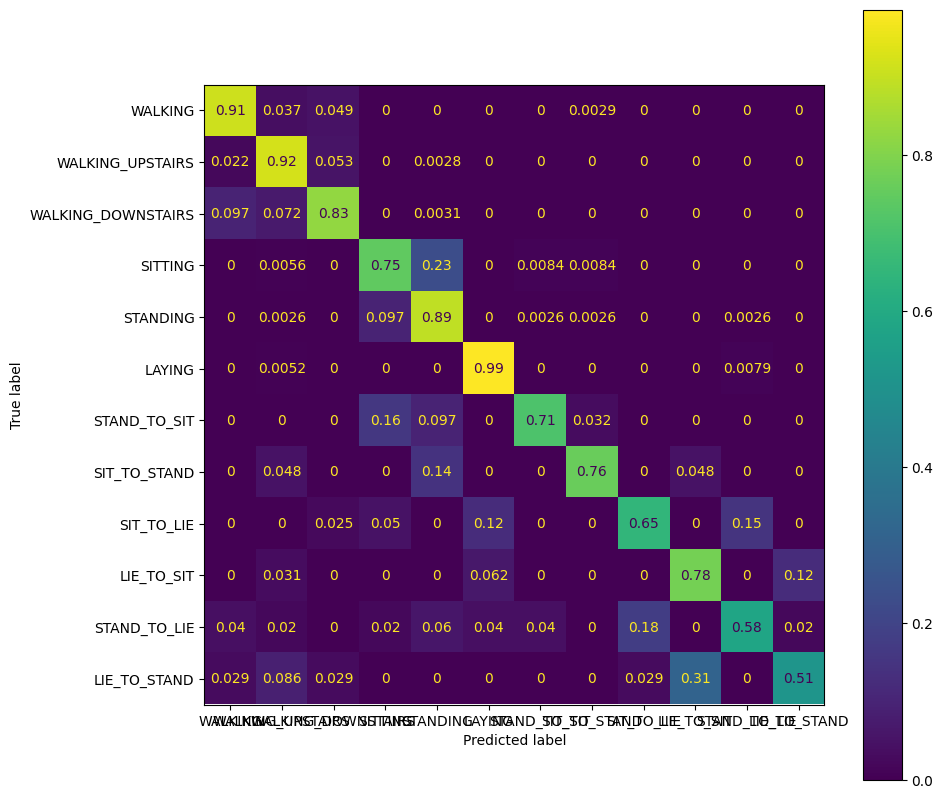

                    precision    recall  f1-score   support

           WALKING       0.88      0.91      0.90       350
  WALKING_UPSTAIRS       0.88      0.92      0.90       359
WALKING_DOWNSTAIRS       0.87      0.83      0.85       320
           SITTING       0.85      0.75      0.80       358
          STANDING       0.79      0.89      0.84       392
            LAYING       0.98      0.99      0.98       382
      STAND_TO_SIT       0.79      0.71      0.75        31
      SIT_TO_STAND       0.73      0.76      0.74        21
        SIT_TO_LIE       0.72      0.65      0.68        40
        LIE_TO_SIT       0.68      0.78      0.72        32
      STAND_TO_LIE       0.74      0.58      0.65        50
      LIE_TO_STAND       0.78      0.51      0.62        35

          accuracy                           0.86      2370
         macro avg       0.81      0.77      0.79      2370
      weighted avg       0.86      0.86      0.86      2370

----8, (5, 5)-----
Model: "sequential

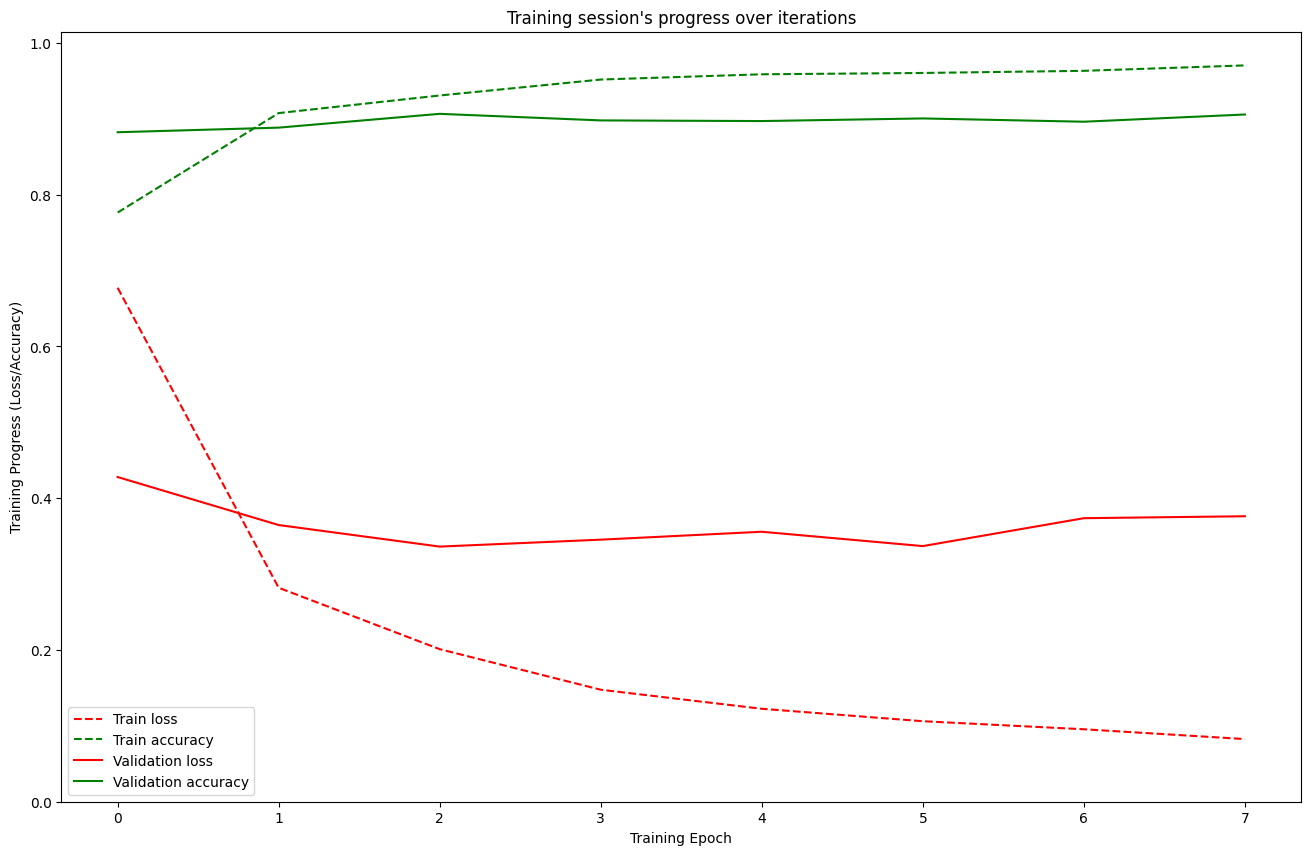

75/75 [==============================] - 0s 3ms/step


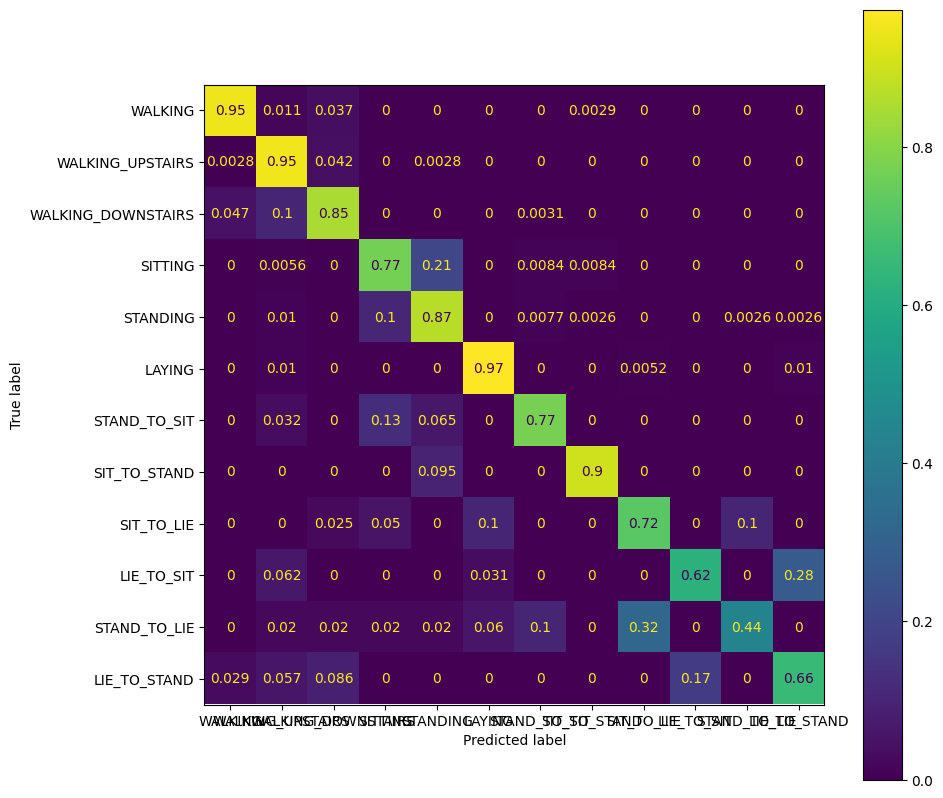

                    precision    recall  f1-score   support

           WALKING       0.95      0.95      0.95       350
  WALKING_UPSTAIRS       0.87      0.95      0.91       359
WALKING_DOWNSTAIRS       0.89      0.85      0.87       320
           SITTING       0.85      0.77      0.81       358
          STANDING       0.81      0.87      0.84       392
            LAYING       0.98      0.97      0.98       382
      STAND_TO_SIT       0.67      0.77      0.72        31
      SIT_TO_STAND       0.79      0.90      0.84        21
        SIT_TO_LIE       0.62      0.72      0.67        40
        LIE_TO_SIT       0.77      0.62      0.69        32
      STAND_TO_LIE       0.81      0.44      0.57        50
      LIE_TO_STAND       0.62      0.66      0.64        35

          accuracy                           0.87      2370
         macro avg       0.80      0.79      0.79      2370
      weighted avg       0.88      0.87      0.87      2370

----8, (6, 6)-----
Model: "sequential

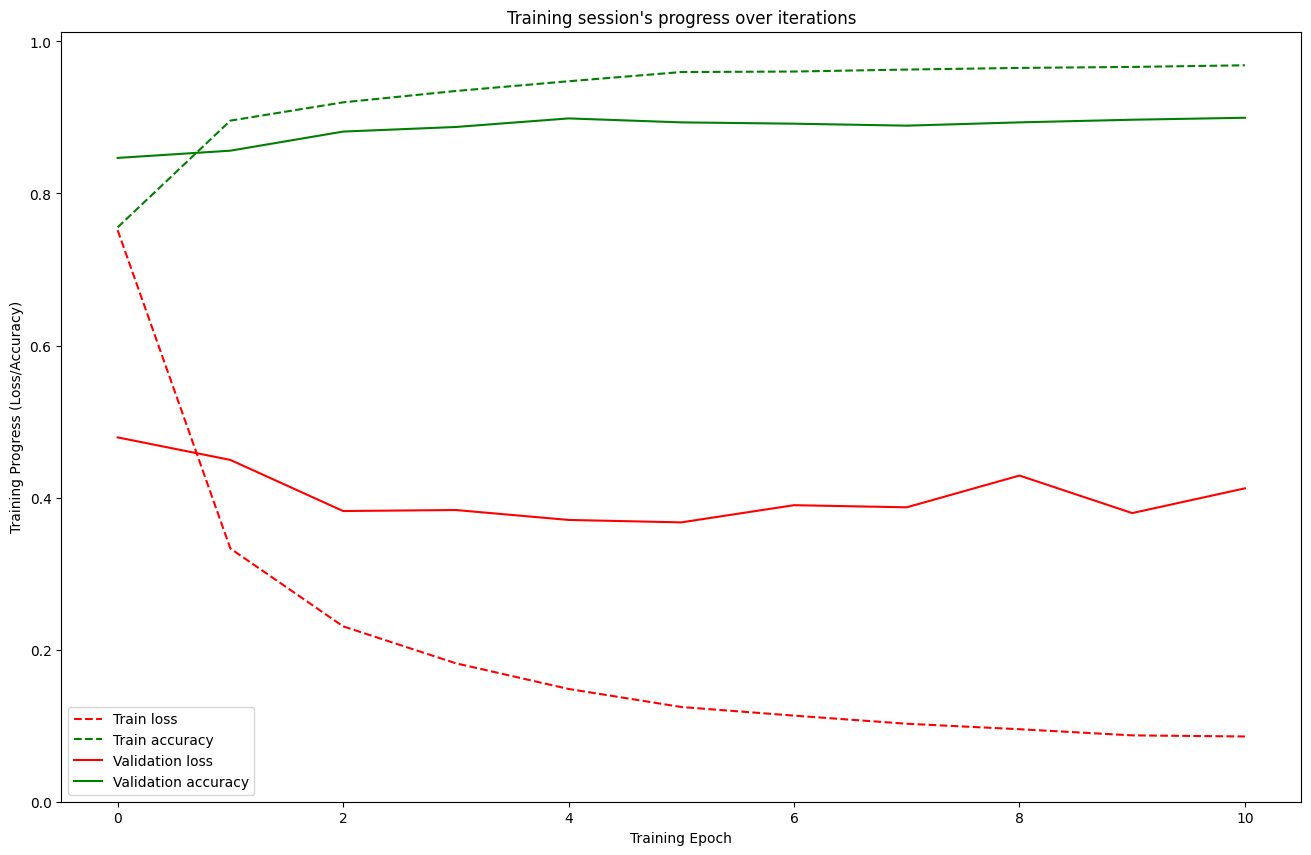

75/75 [==============================] - 0s 2ms/step


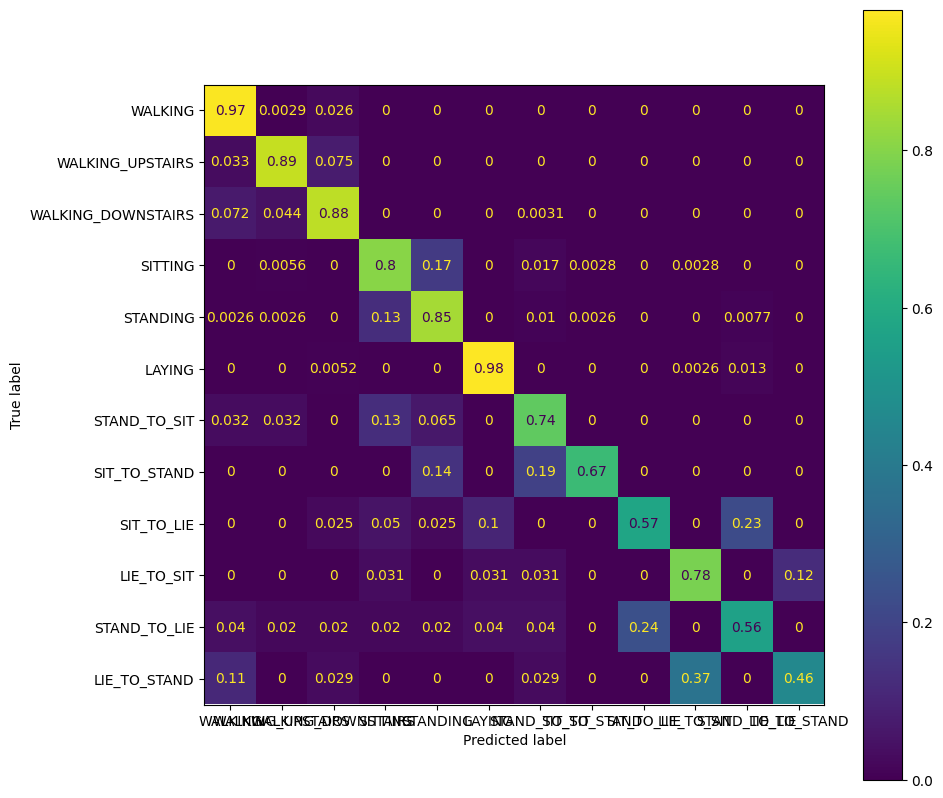

                    precision    recall  f1-score   support

           WALKING       0.89      0.97      0.93       350
  WALKING_UPSTAIRS       0.94      0.89      0.92       359
WALKING_DOWNSTAIRS       0.87      0.88      0.88       320
           SITTING       0.83      0.80      0.82       358
          STANDING       0.83      0.85      0.84       392
            LAYING       0.98      0.98      0.98       382
      STAND_TO_SIT       0.55      0.74      0.63        31
      SIT_TO_STAND       0.88      0.67      0.76        21
        SIT_TO_LIE       0.66      0.57      0.61        40
        LIE_TO_SIT       0.62      0.78      0.69        32
      STAND_TO_LIE       0.62      0.56      0.59        50
      LIE_TO_STAND       0.80      0.46      0.58        35

          accuracy                           0.87      2370
         macro avg       0.79      0.76      0.77      2370
      weighted avg       0.87      0.87      0.87      2370

----16, (2, 2)-----
Model: "sequentia

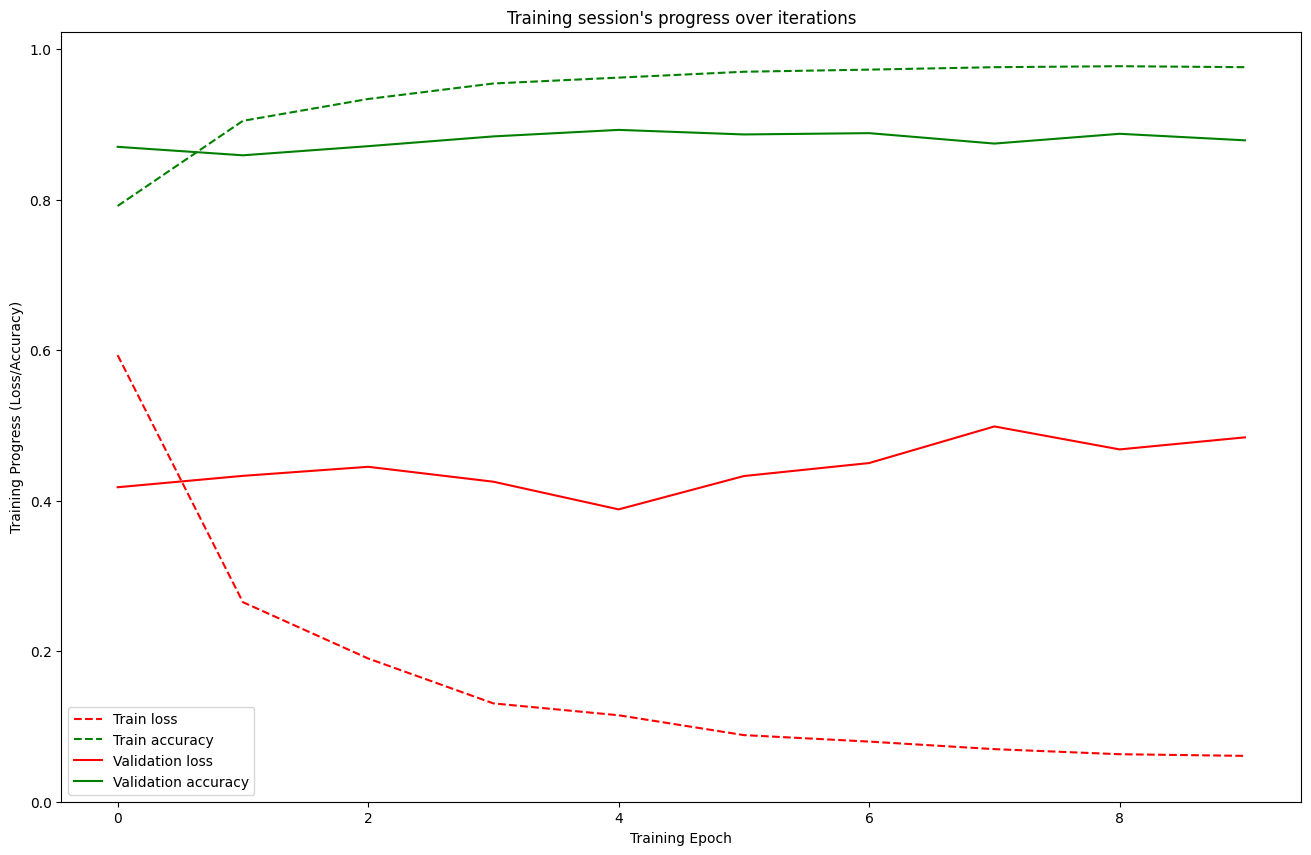

75/75 [==============================] - 0s 2ms/step


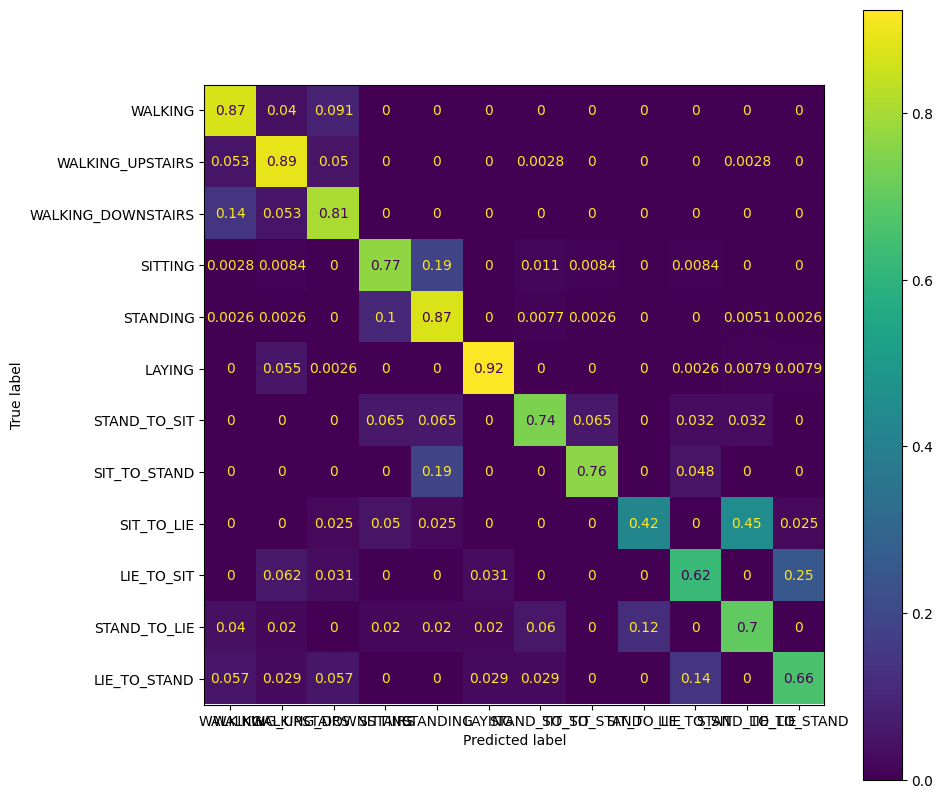

                    precision    recall  f1-score   support

           WALKING       0.81      0.87      0.84       350
  WALKING_UPSTAIRS       0.84      0.89      0.87       359
WALKING_DOWNSTAIRS       0.82      0.81      0.82       320
           SITTING       0.86      0.77      0.81       358
          STANDING       0.82      0.87      0.84       392
            LAYING       0.99      0.92      0.96       382
      STAND_TO_SIT       0.66      0.74      0.70        31
      SIT_TO_STAND       0.73      0.76      0.74        21
        SIT_TO_LIE       0.74      0.42      0.54        40
        LIE_TO_SIT       0.65      0.62      0.63        32
      STAND_TO_LIE       0.58      0.70      0.64        50
      LIE_TO_STAND       0.64      0.66      0.65        35

          accuracy                           0.84      2370
         macro avg       0.76      0.75      0.75      2370
      weighted avg       0.84      0.84      0.84      2370

----16, (3, 3)-----
Model: "sequentia

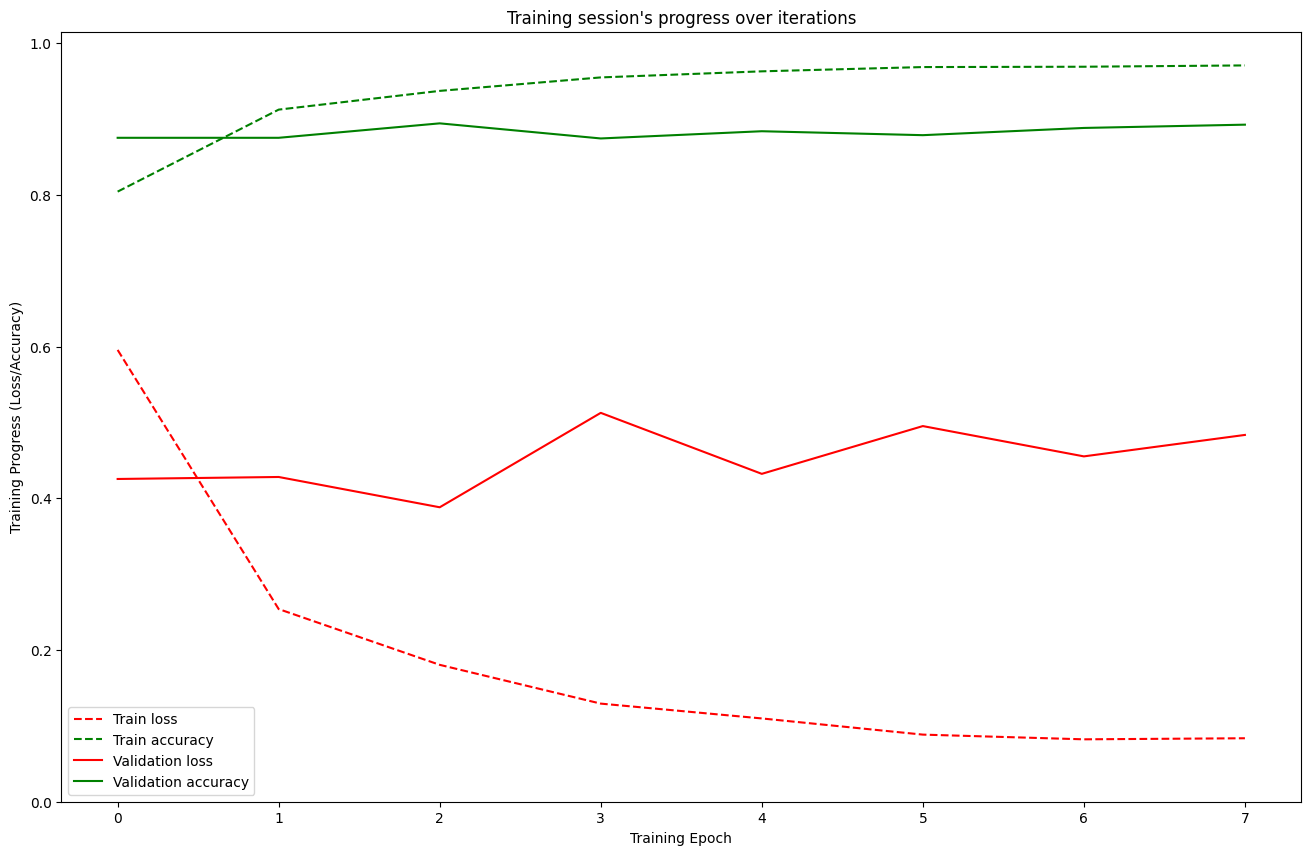

75/75 [==============================] - 0s 1ms/step


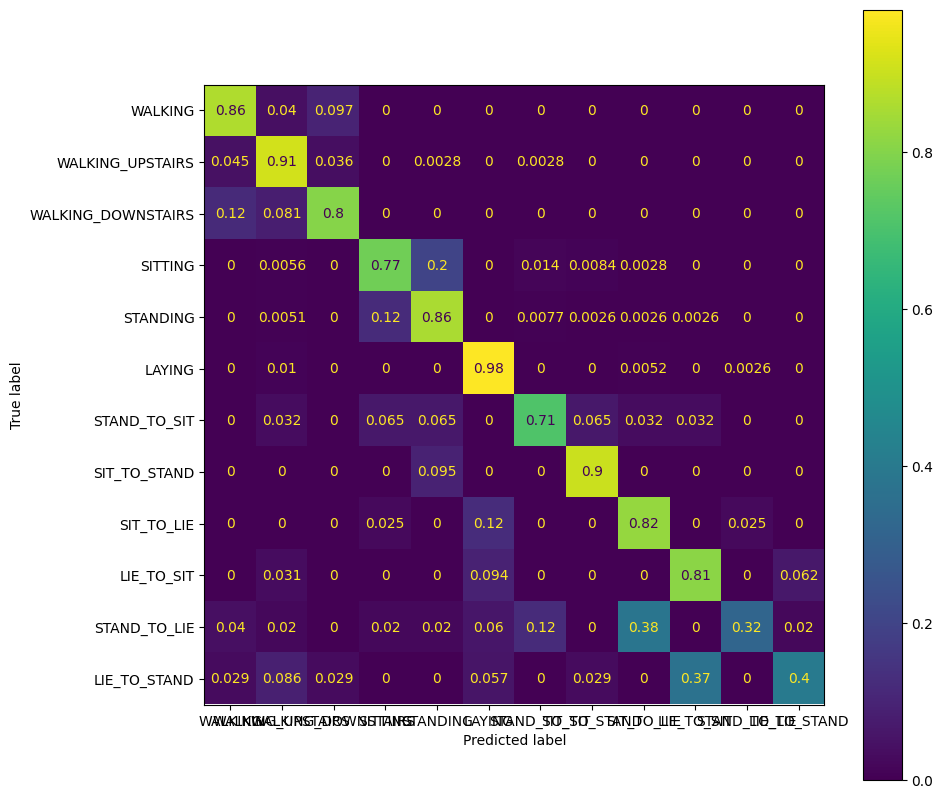

                    precision    recall  f1-score   support

           WALKING       0.84      0.86      0.85       350
  WALKING_UPSTAIRS       0.86      0.91      0.89       359
WALKING_DOWNSTAIRS       0.84      0.80      0.82       320
           SITTING       0.84      0.77      0.80       358
          STANDING       0.81      0.86      0.83       392
            LAYING       0.97      0.98      0.97       382
      STAND_TO_SIT       0.59      0.71      0.65        31
      SIT_TO_STAND       0.73      0.90      0.81        21
        SIT_TO_LIE       0.58      0.82      0.68        40
        LIE_TO_SIT       0.63      0.81      0.71        32
      STAND_TO_LIE       0.89      0.32      0.47        50
      LIE_TO_STAND       0.82      0.40      0.54        35

          accuracy                           0.85      2370
         macro avg       0.78      0.76      0.75      2370
      weighted avg       0.85      0.85      0.84      2370

----16, (4, 4)-----
Model: "sequentia

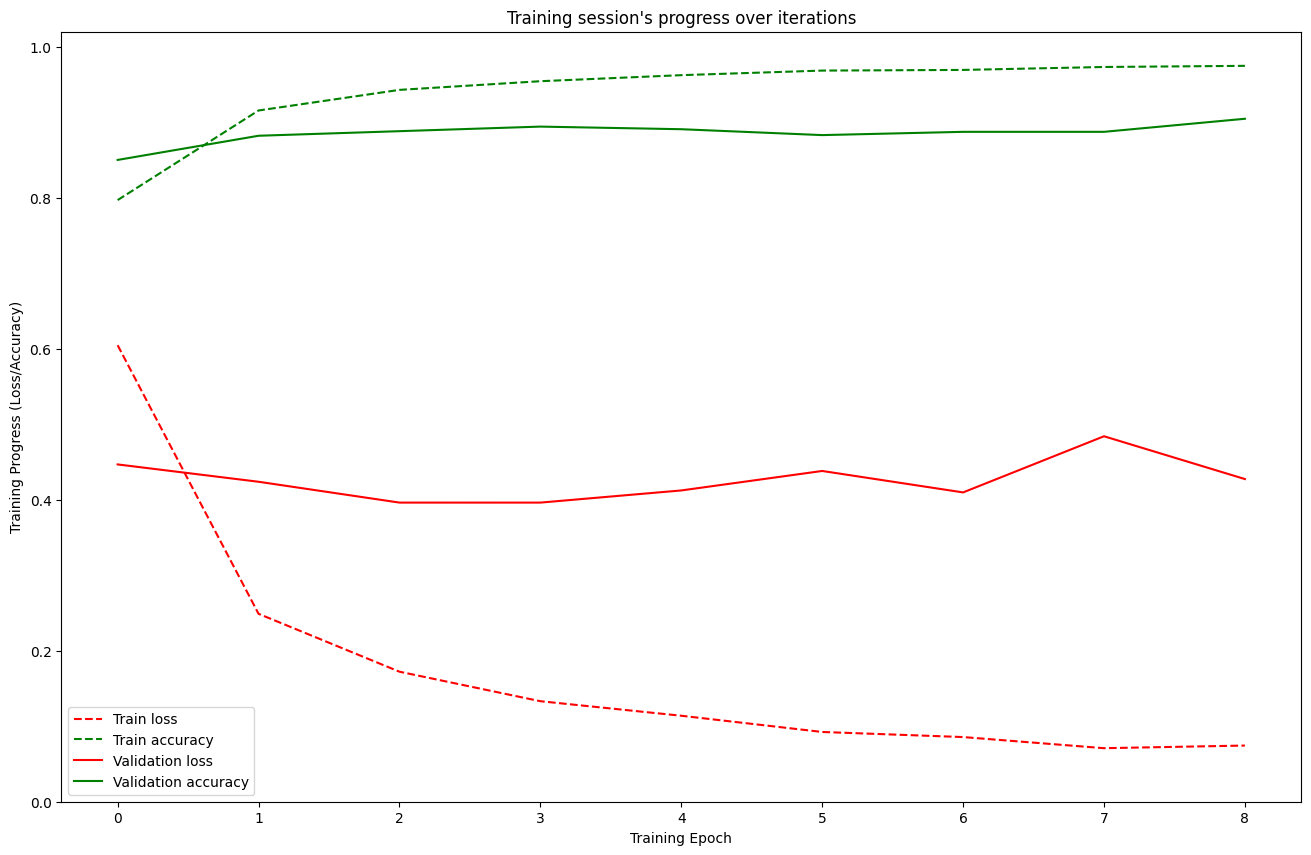

75/75 [==============================] - 0s 1ms/step


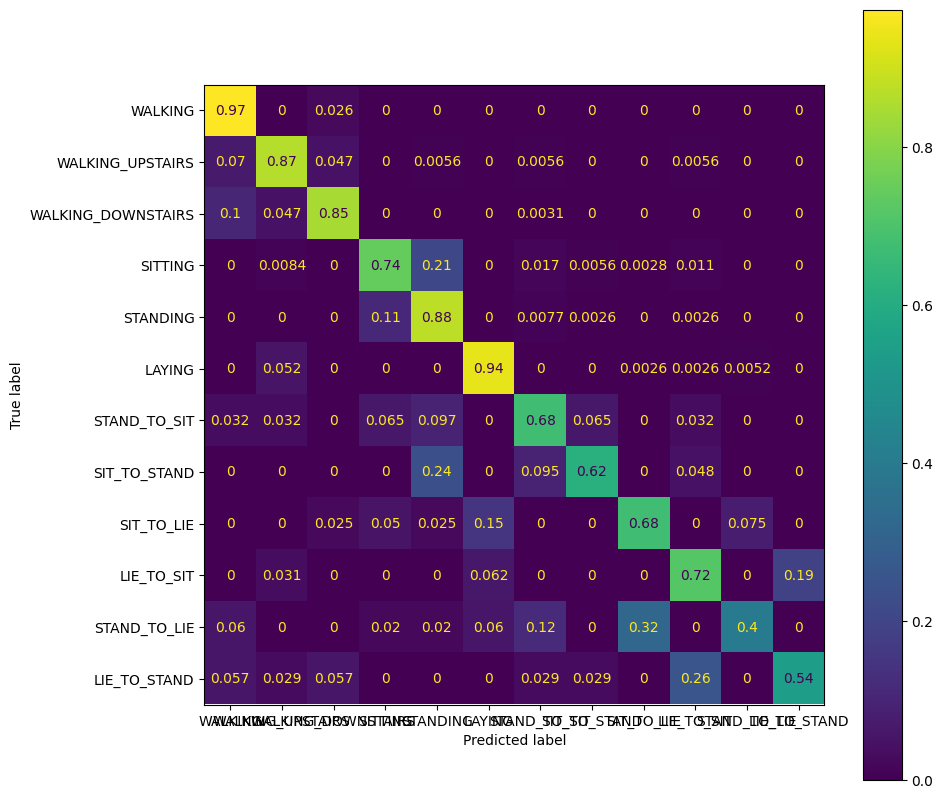

                    precision    recall  f1-score   support

           WALKING       0.84      0.97      0.90       350
  WALKING_UPSTAIRS       0.88      0.87      0.87       359
WALKING_DOWNSTAIRS       0.90      0.85      0.87       320
           SITTING       0.85      0.74      0.79       358
          STANDING       0.80      0.88      0.83       392
            LAYING       0.97      0.94      0.95       382
      STAND_TO_SIT       0.50      0.68      0.58        31
      SIT_TO_STAND       0.68      0.62      0.65        21
        SIT_TO_LIE       0.60      0.68      0.64        40
        LIE_TO_SIT       0.55      0.72      0.62        32
      STAND_TO_LIE       0.80      0.40      0.53        50
      LIE_TO_STAND       0.76      0.54      0.63        35

          accuracy                           0.85      2370
         macro avg       0.76      0.74      0.74      2370
      weighted avg       0.85      0.85      0.85      2370

----16, (5, 5)-----
Model: "sequentia

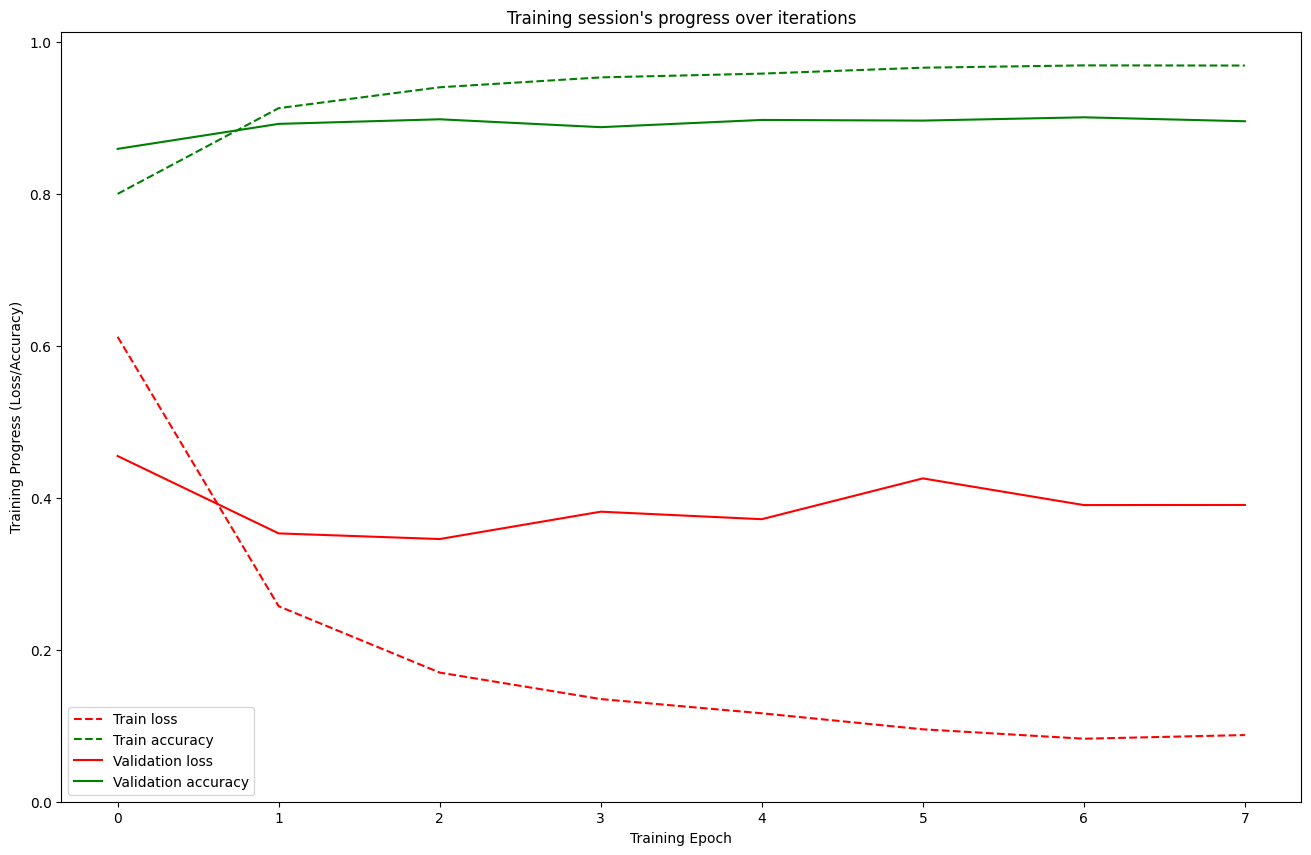

75/75 [==============================] - 0s 1ms/step


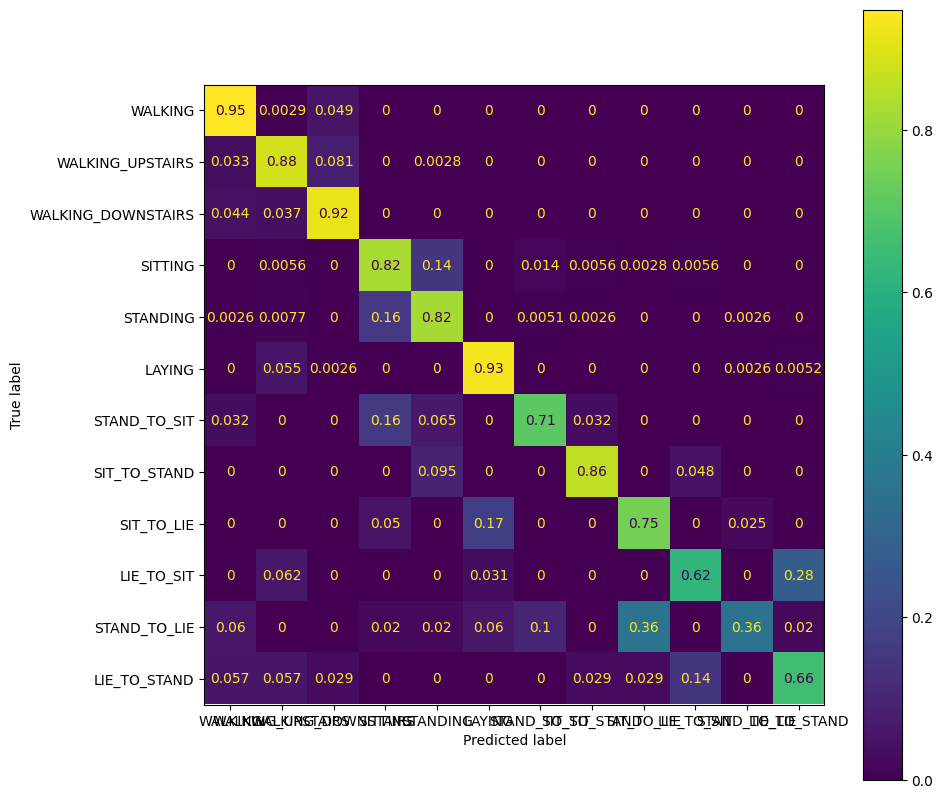

                    precision    recall  f1-score   support

           WALKING       0.91      0.95      0.93       350
  WALKING_UPSTAIRS       0.88      0.88      0.88       359
WALKING_DOWNSTAIRS       0.86      0.92      0.89       320
           SITTING       0.81      0.82      0.82       358
          STANDING       0.85      0.82      0.84       392
            LAYING       0.97      0.93      0.95       382
      STAND_TO_SIT       0.65      0.71      0.68        31
      SIT_TO_STAND       0.78      0.86      0.82        21
        SIT_TO_LIE       0.60      0.75      0.67        40
        LIE_TO_SIT       0.71      0.62      0.67        32
      STAND_TO_LIE       0.86      0.36      0.51        50
      LIE_TO_STAND       0.66      0.66      0.66        35

          accuracy                           0.86      2370
         macro avg       0.79      0.77      0.77      2370
      weighted avg       0.87      0.86      0.86      2370

----16, (6, 6)-----
Model: "sequentia

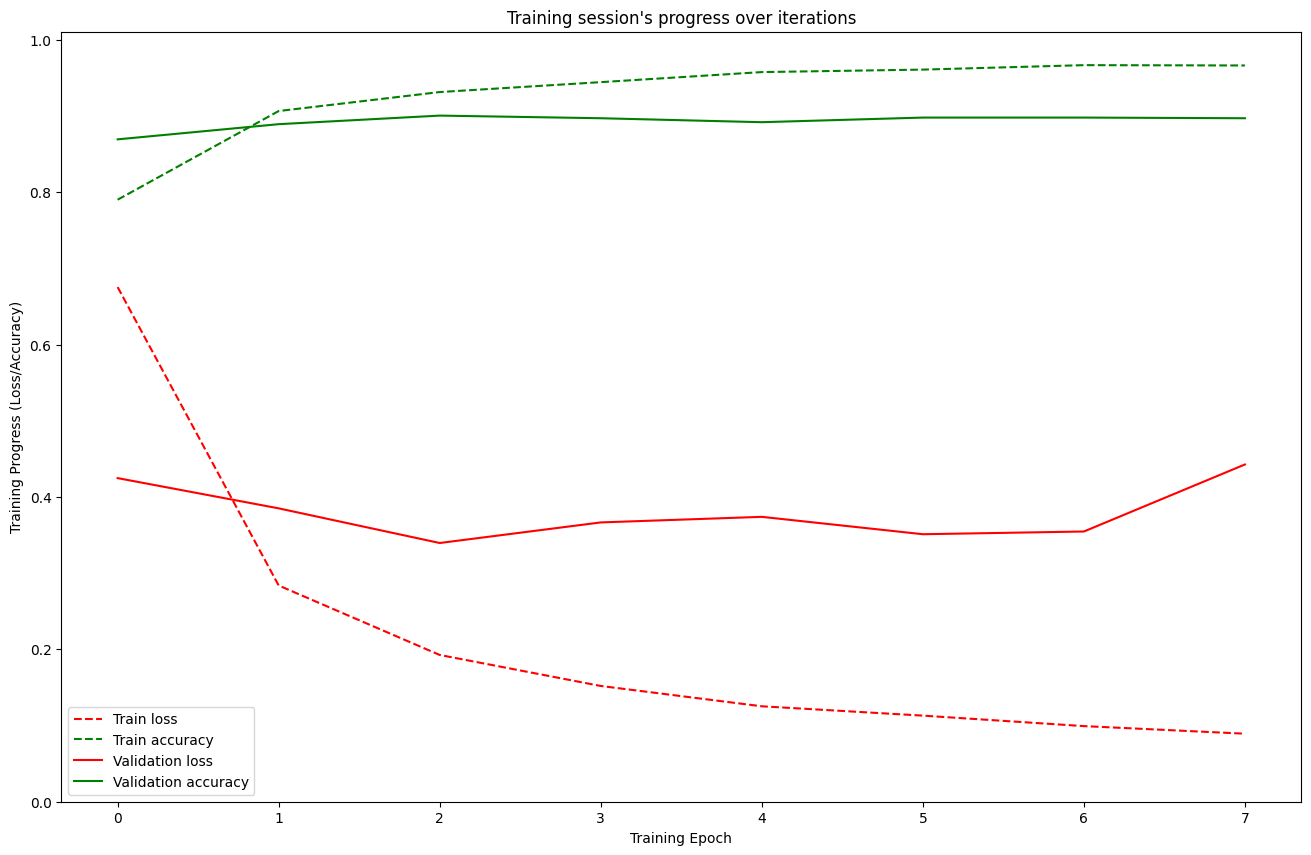

75/75 [==============================] - 0s 2ms/step


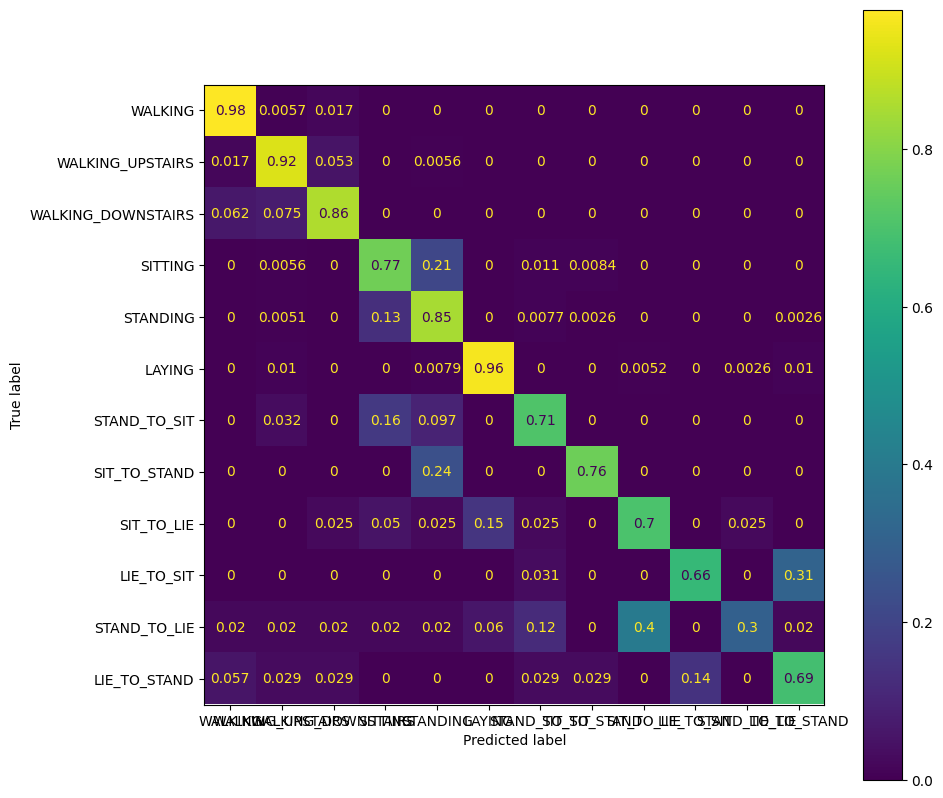

                    precision    recall  f1-score   support

           WALKING       0.92      0.98      0.95       350
  WALKING_UPSTAIRS       0.90      0.92      0.91       359
WALKING_DOWNSTAIRS       0.91      0.86      0.88       320
           SITTING       0.82      0.77      0.79       358
          STANDING       0.79      0.85      0.82       392
            LAYING       0.98      0.96      0.97       382
      STAND_TO_SIT       0.58      0.71      0.64        31
      SIT_TO_STAND       0.76      0.76      0.76        21
        SIT_TO_LIE       0.56      0.70      0.62        40
        LIE_TO_SIT       0.81      0.66      0.72        32
      STAND_TO_LIE       0.88      0.30      0.45        50
      LIE_TO_STAND       0.60      0.69      0.64        35

          accuracy                           0.87      2370
         macro avg       0.79      0.76      0.76      2370
      weighted avg       0.87      0.87      0.86      2370

----32, (2, 2)-----
Model: "sequentia

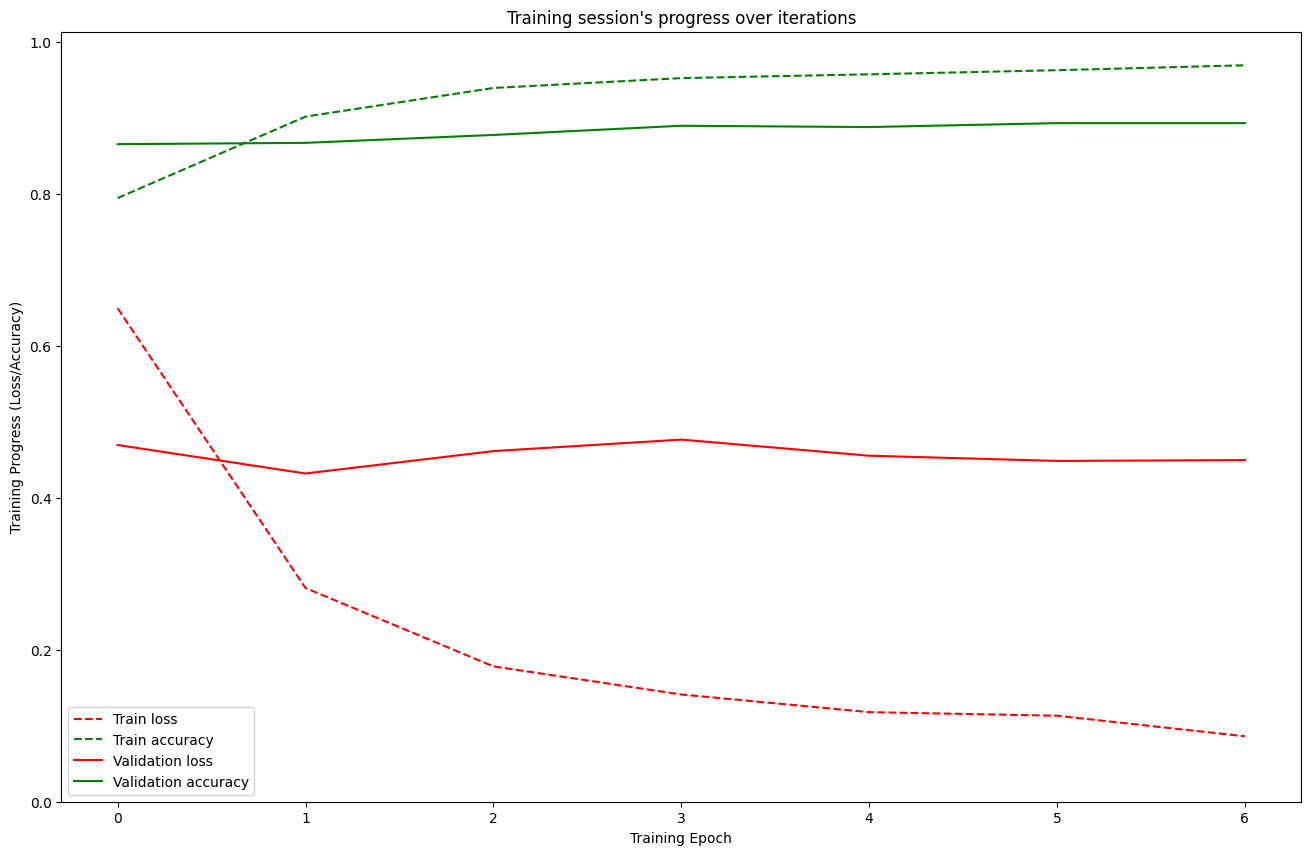

75/75 [==============================] - 0s 2ms/step


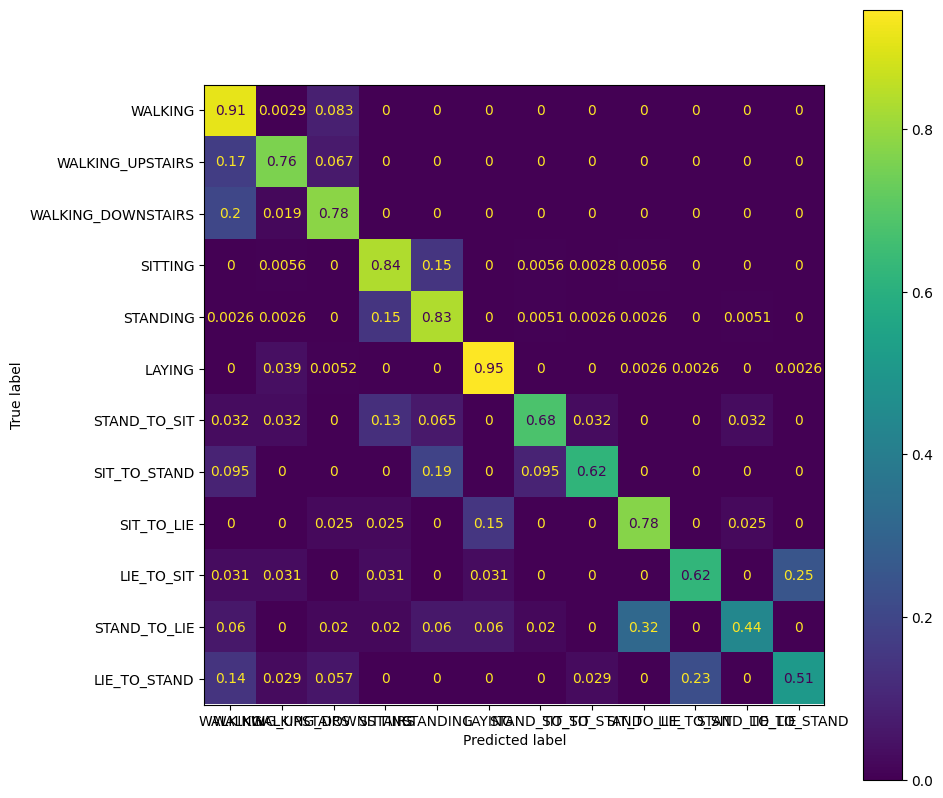

                    precision    recall  f1-score   support

           WALKING       0.70      0.91      0.79       350
  WALKING_UPSTAIRS       0.91      0.76      0.83       359
WALKING_DOWNSTAIRS       0.81      0.78      0.79       320
           SITTING       0.82      0.84      0.83       358
          STANDING       0.84      0.83      0.84       392
            LAYING       0.97      0.95      0.96       382
      STAND_TO_SIT       0.75      0.68      0.71        31
      SIT_TO_STAND       0.76      0.62      0.68        21
        SIT_TO_LIE       0.61      0.78      0.68        40
        LIE_TO_SIT       0.69      0.62      0.66        32
      STAND_TO_LIE       0.85      0.44      0.58        50
      LIE_TO_STAND       0.67      0.51      0.58        35

          accuracy                           0.83      2370
         macro avg       0.78      0.73      0.74      2370
      weighted avg       0.83      0.83      0.82      2370

----32, (3, 3)-----
Model: "sequentia

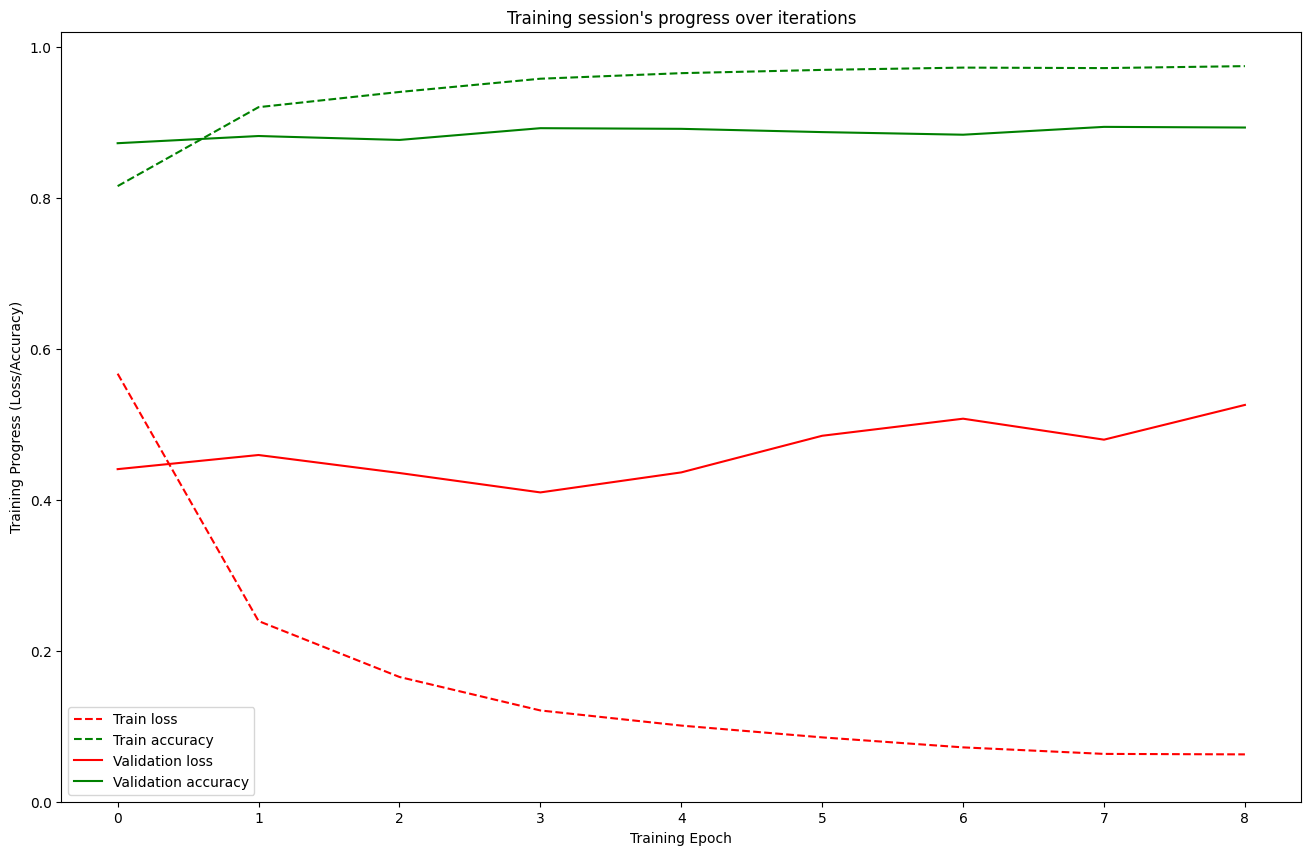

75/75 [==============================] - 0s 2ms/step


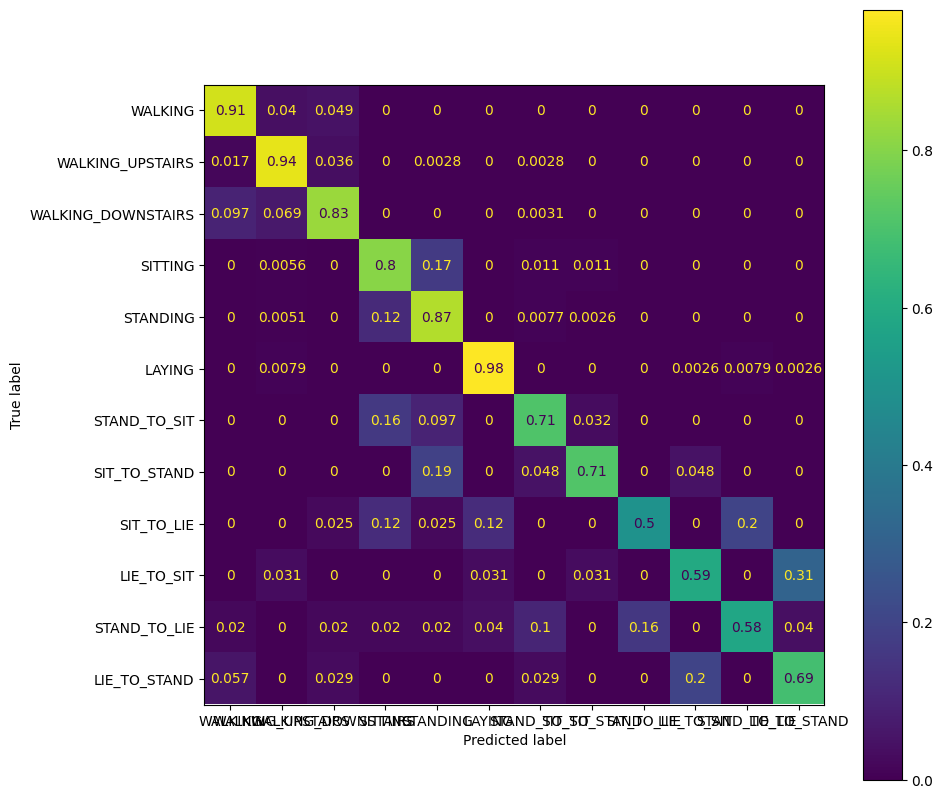

                    precision    recall  f1-score   support

           WALKING       0.89      0.91      0.90       350
  WALKING_UPSTAIRS       0.88      0.94      0.91       359
WALKING_DOWNSTAIRS       0.89      0.83      0.86       320
           SITTING       0.83      0.80      0.82       358
          STANDING       0.83      0.87      0.85       392
            LAYING       0.98      0.98      0.98       382
      STAND_TO_SIT       0.58      0.71      0.64        31
      SIT_TO_STAND       0.68      0.71      0.70        21
        SIT_TO_LIE       0.71      0.50      0.59        40
        LIE_TO_SIT       0.68      0.59      0.63        32
      STAND_TO_LIE       0.72      0.58      0.64        50
      LIE_TO_STAND       0.65      0.69      0.67        35

          accuracy                           0.87      2370
         macro avg       0.78      0.76      0.77      2370
      weighted avg       0.87      0.87      0.87      2370

----32, (4, 4)-----
Model: "sequentia

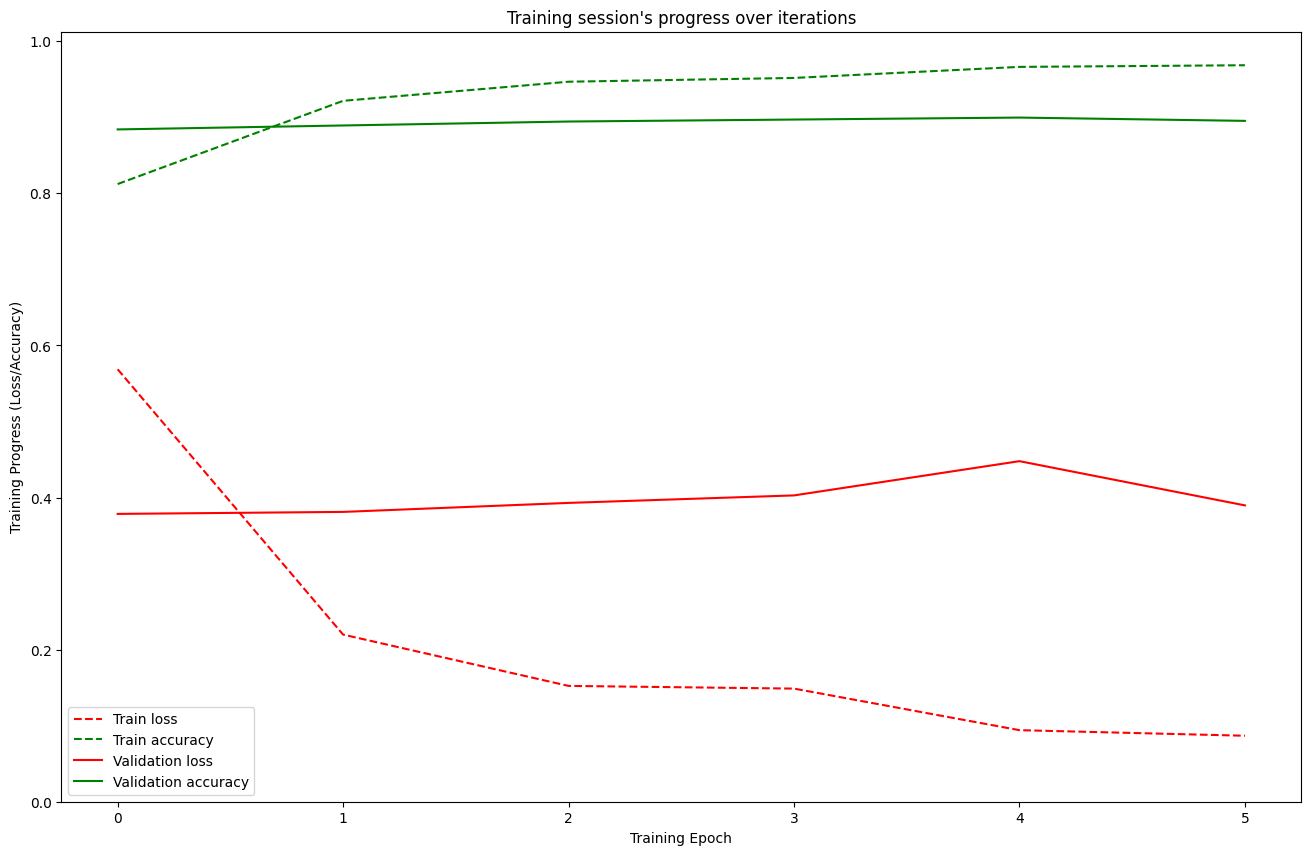

75/75 [==============================] - 0s 2ms/step


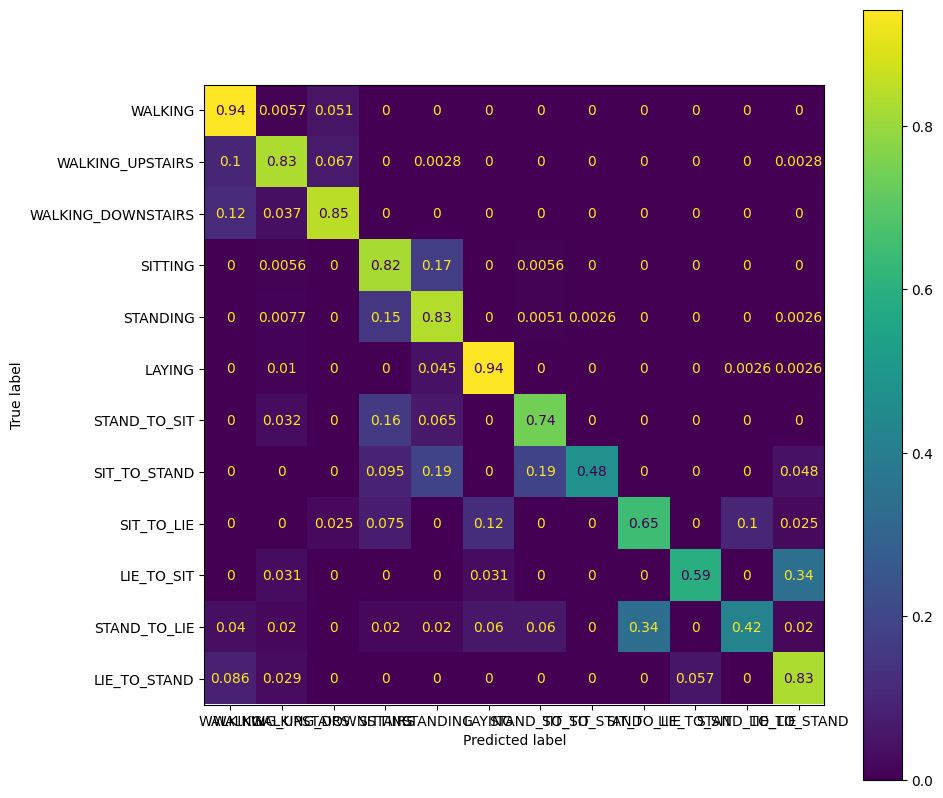

                    precision    recall  f1-score   support

           WALKING       0.81      0.94      0.87       350
  WALKING_UPSTAIRS       0.92      0.83      0.87       359
WALKING_DOWNSTAIRS       0.86      0.85      0.85       320
           SITTING       0.81      0.82      0.81       358
          STANDING       0.79      0.83      0.81       392
            LAYING       0.98      0.94      0.96       382
      STAND_TO_SIT       0.68      0.74      0.71        31
      SIT_TO_STAND       0.91      0.48      0.62        21
        SIT_TO_LIE       0.60      0.65      0.63        40
        LIE_TO_SIT       0.90      0.59      0.72        32
      STAND_TO_LIE       0.81      0.42      0.55        50
      LIE_TO_STAND       0.63      0.83      0.72        35

          accuracy                           0.85      2370
         macro avg       0.81      0.74      0.76      2370
      weighted avg       0.85      0.85      0.84      2370

----32, (5, 5)-----
Model: "sequentia

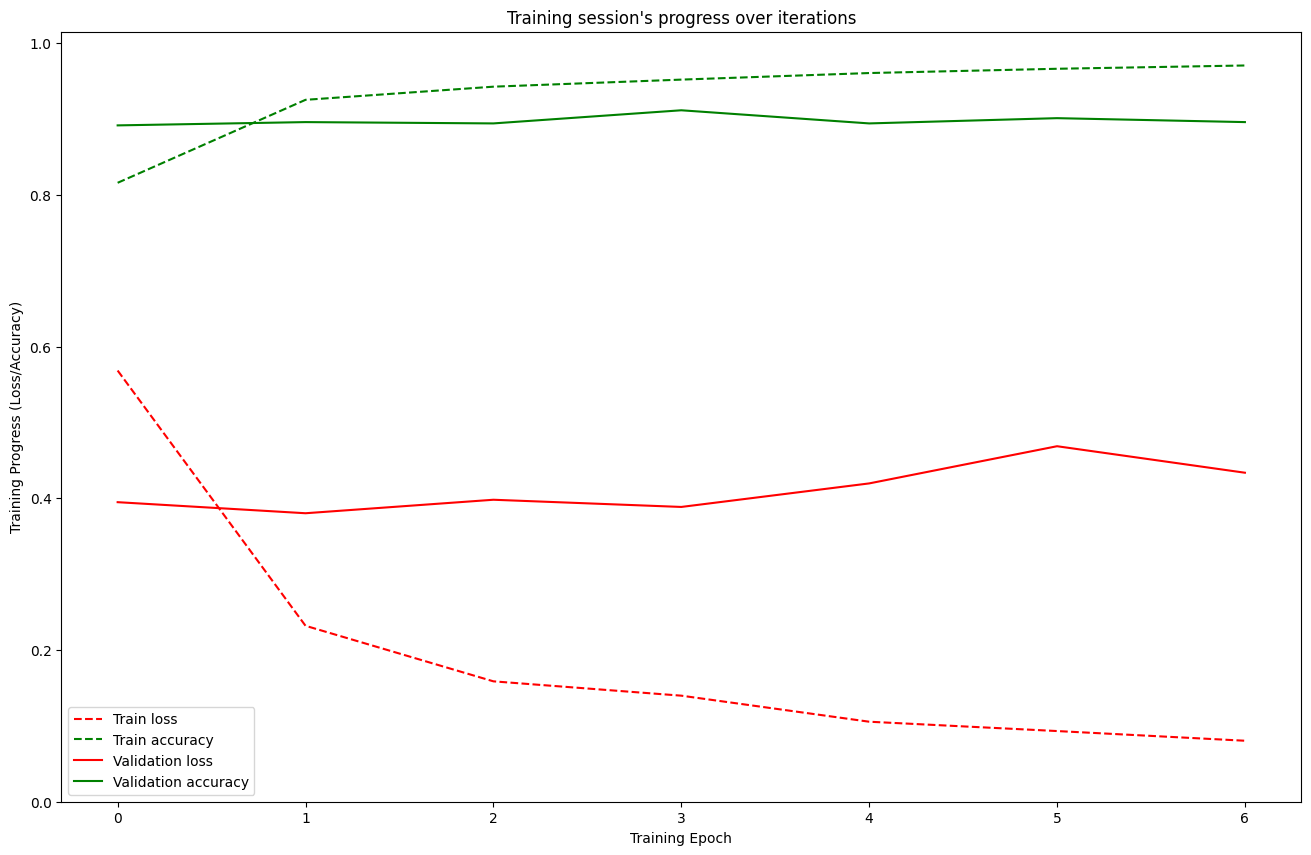

75/75 [==============================] - 0s 2ms/step


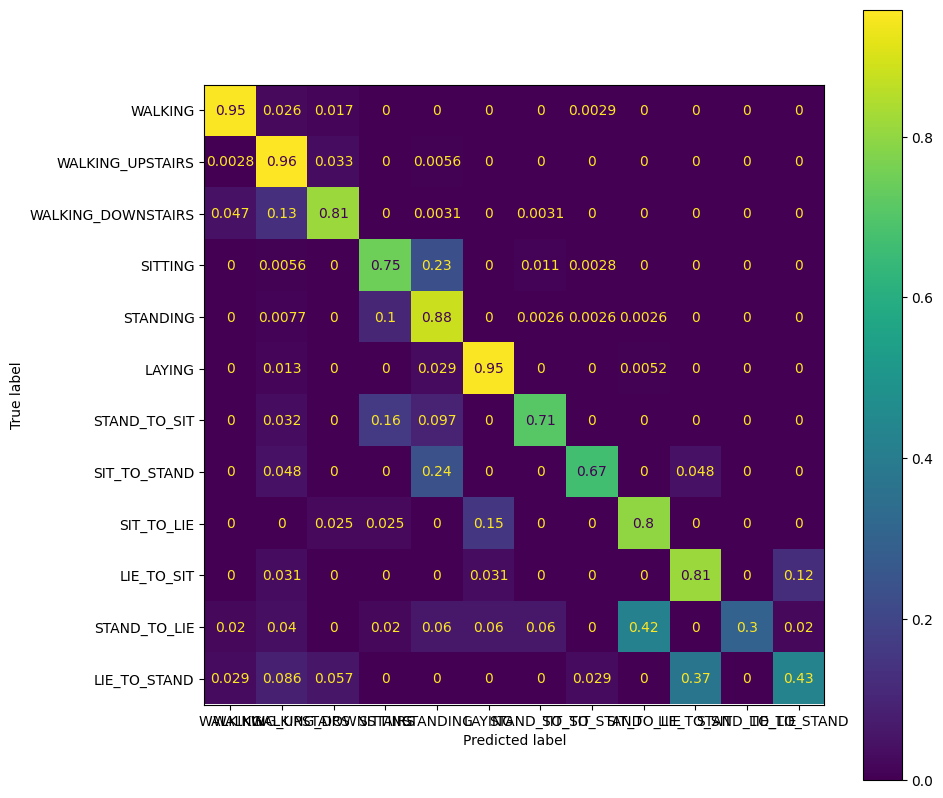

                    precision    recall  f1-score   support

           WALKING       0.95      0.95      0.95       350
  WALKING_UPSTAIRS       0.83      0.96      0.89       359
WALKING_DOWNSTAIRS       0.93      0.81      0.87       320
           SITTING       0.85      0.75      0.79       358
          STANDING       0.76      0.88      0.82       392
            LAYING       0.97      0.95      0.96       382
      STAND_TO_SIT       0.71      0.71      0.71        31
      SIT_TO_STAND       0.78      0.67      0.72        21
        SIT_TO_LIE       0.57      0.80      0.67        40
        LIE_TO_SIT       0.65      0.81      0.72        32
      STAND_TO_LIE       1.00      0.30      0.46        50
      LIE_TO_STAND       0.75      0.43      0.55        35

          accuracy                           0.86      2370
         macro avg       0.81      0.75      0.76      2370
      weighted avg       0.87      0.86      0.86      2370

----32, (6, 6)-----
Model: "sequentia

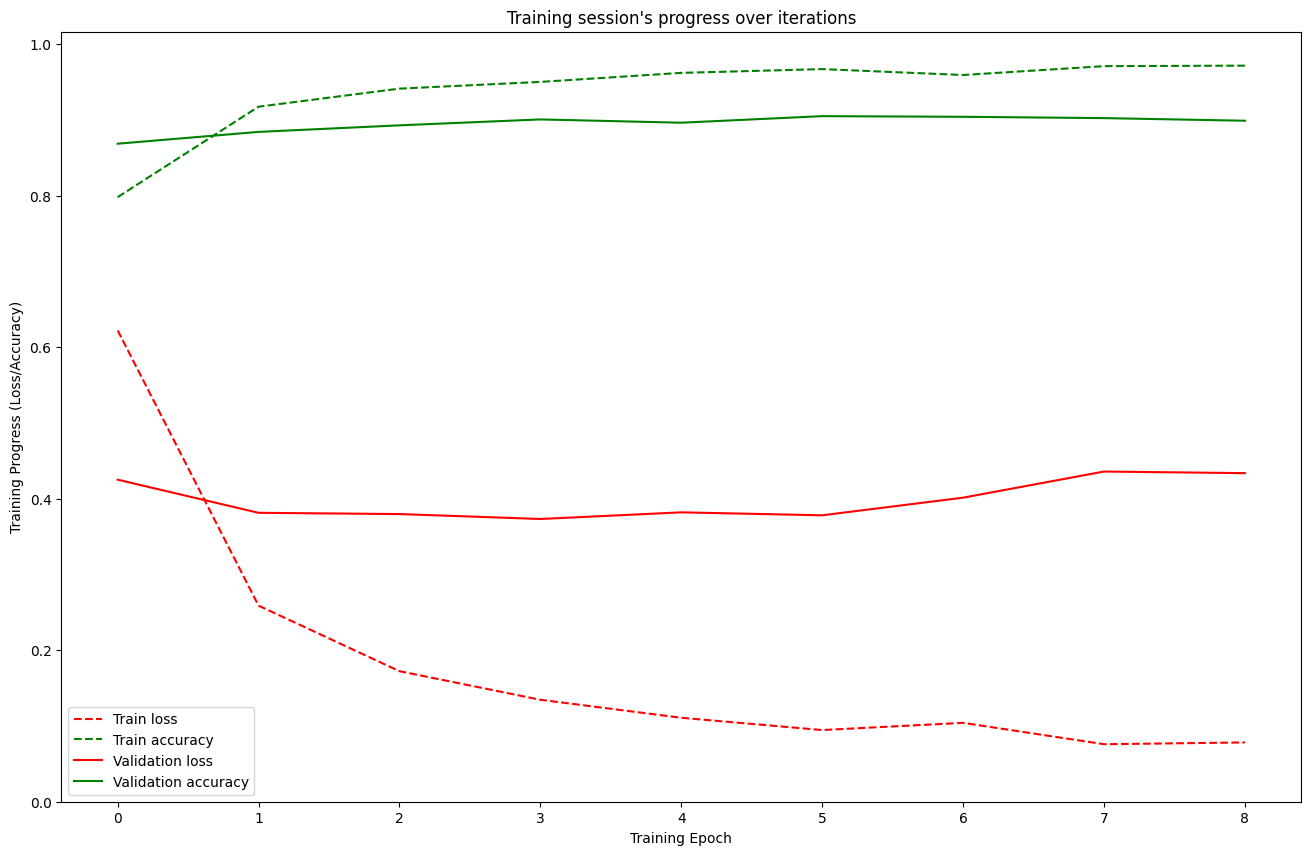

75/75 [==============================] - 0s 2ms/step


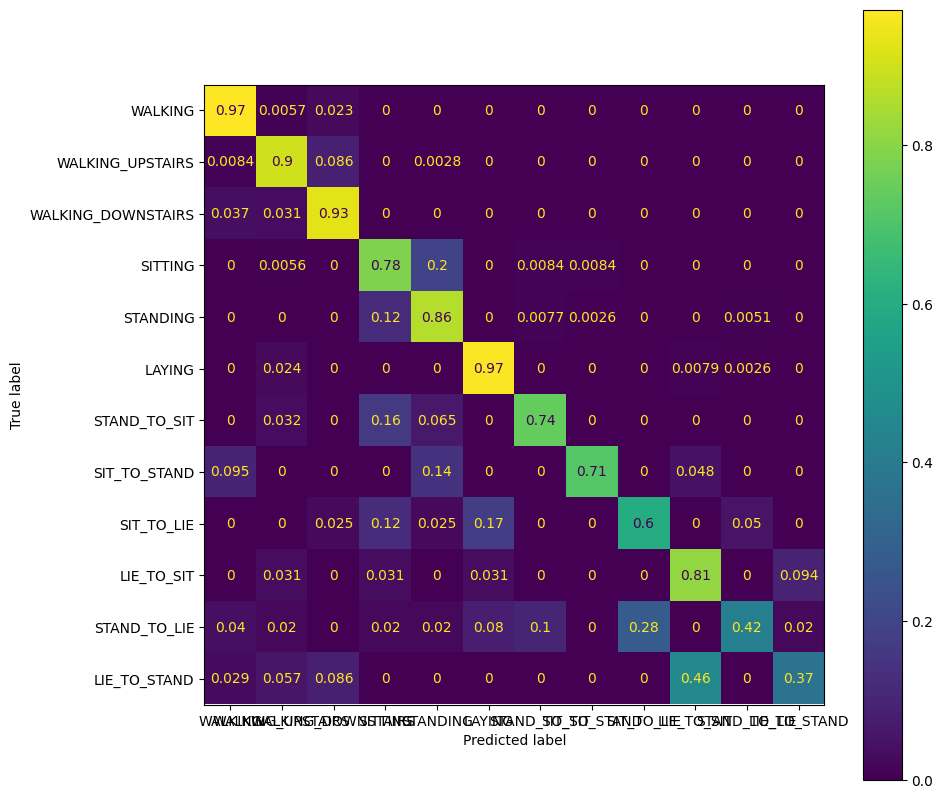

                    precision    recall  f1-score   support

           WALKING       0.94      0.97      0.96       350
  WALKING_UPSTAIRS       0.92      0.90      0.91       359
WALKING_DOWNSTAIRS       0.87      0.93      0.90       320
           SITTING       0.83      0.78      0.80       358
          STANDING       0.81      0.86      0.84       392
            LAYING       0.97      0.97      0.97       382
      STAND_TO_SIT       0.68      0.74      0.71        31
      SIT_TO_STAND       0.79      0.71      0.75        21
        SIT_TO_LIE       0.63      0.60      0.62        40
        LIE_TO_SIT       0.57      0.81      0.67        32
      STAND_TO_LIE       0.81      0.42      0.55        50
      LIE_TO_STAND       0.76      0.37      0.50        35

          accuracy                           0.87      2370
         macro avg       0.80      0.76      0.76      2370
      weighted avg       0.87      0.87      0.87      2370



In [ ]:
#Testing filters + kernel with base layer
filters=[4,8,16,32]
kernels=[(2,2),(3,3),(4,4),(5,5),(6,6)]

for f in filters:
    for k in kernels:
        print(f"----{f}, {k}-----")
        model = Sequential()

        model.add(Conv2D(filters=f, kernel_size=k, activation='relu', input_shape=x_train[0].shape))

        model.add(Flatten())

        model.add(Dense(13, activation='softmax'))

        model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',
                        metrics=['accuracy'])
        print(model.summary())

        #----------------------------------
        history = model.fit(x_train, y_train, epochs=epoch, validation_split=0.2, verbose=1, callbacks = callback)
        plot_learningCurve(history)
        show_confusion_mat(model)

----0.1-----
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 198, 4, 16)        160       
                                                                 
 dropout_4 (Dropout)         (None, 198, 4, 16)        0         
                                                                 
 flatten_37 (Flatten)        (None, 12672)             0         
                                                                 
 dense_37 (Dense)            (None, 13)                164749    
                                                                 
Total params: 164,909
Trainable params: 164,909
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
145/145 [==============================] - 1s 5ms/step - loss: 0.6019 - accuracy: 0.7996 - val_loss: 0.4220 - val_accuracy: 0.8779
Epoch 2/20
145/145 

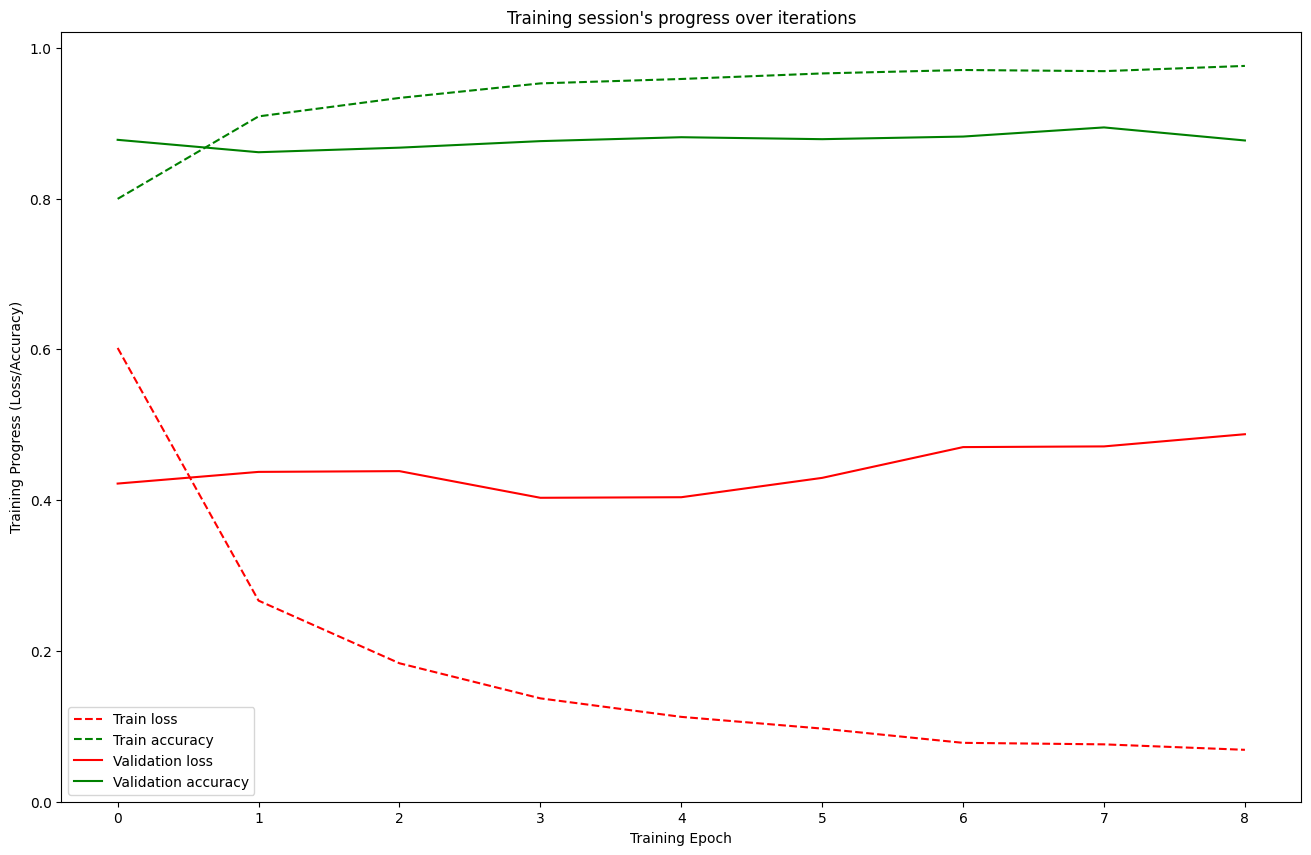

75/75 [==============================] - 0s 3ms/step


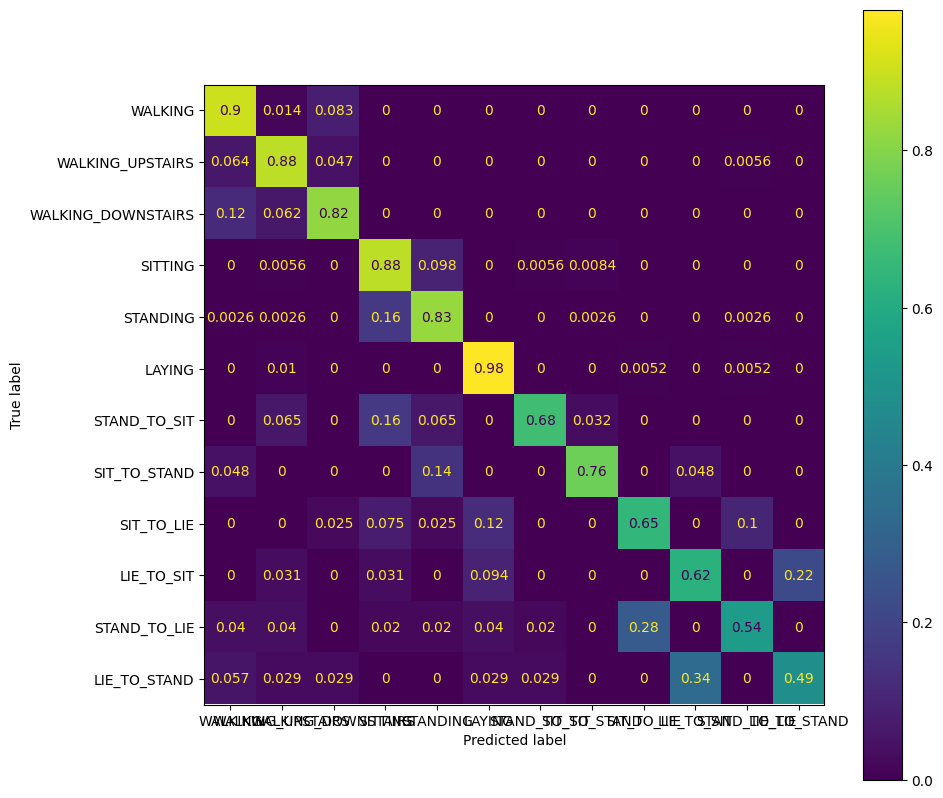

                    precision    recall  f1-score   support

           WALKING       0.83      0.90      0.86       350
  WALKING_UPSTAIRS       0.89      0.88      0.89       359
WALKING_DOWNSTAIRS       0.85      0.82      0.83       320
           SITTING       0.81      0.88      0.85       358
          STANDING       0.89      0.83      0.86       392
            LAYING       0.97      0.98      0.98       382
      STAND_TO_SIT       0.84      0.68      0.75        31
      SIT_TO_STAND       0.76      0.76      0.76        21
        SIT_TO_LIE       0.62      0.65      0.63        40
        LIE_TO_SIT       0.61      0.62      0.62        32
      STAND_TO_LIE       0.75      0.54      0.63        50
      LIE_TO_STAND       0.71      0.49      0.58        35

          accuracy                           0.86      2370
         macro avg       0.79      0.75      0.77      2370
      weighted avg       0.86      0.86      0.86      2370

----0.2-----
Model: "sequential_38"
_

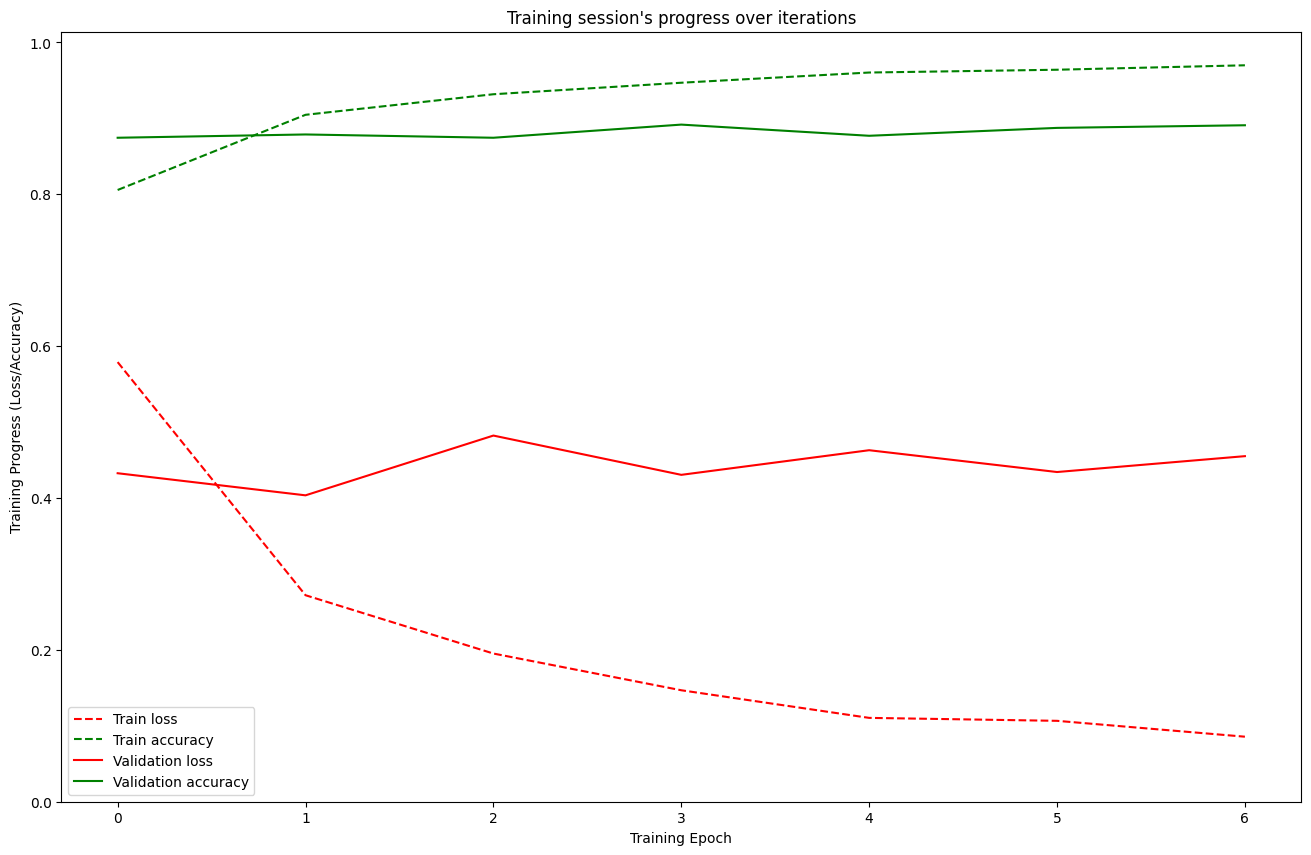

75/75 [==============================] - 0s 1ms/step


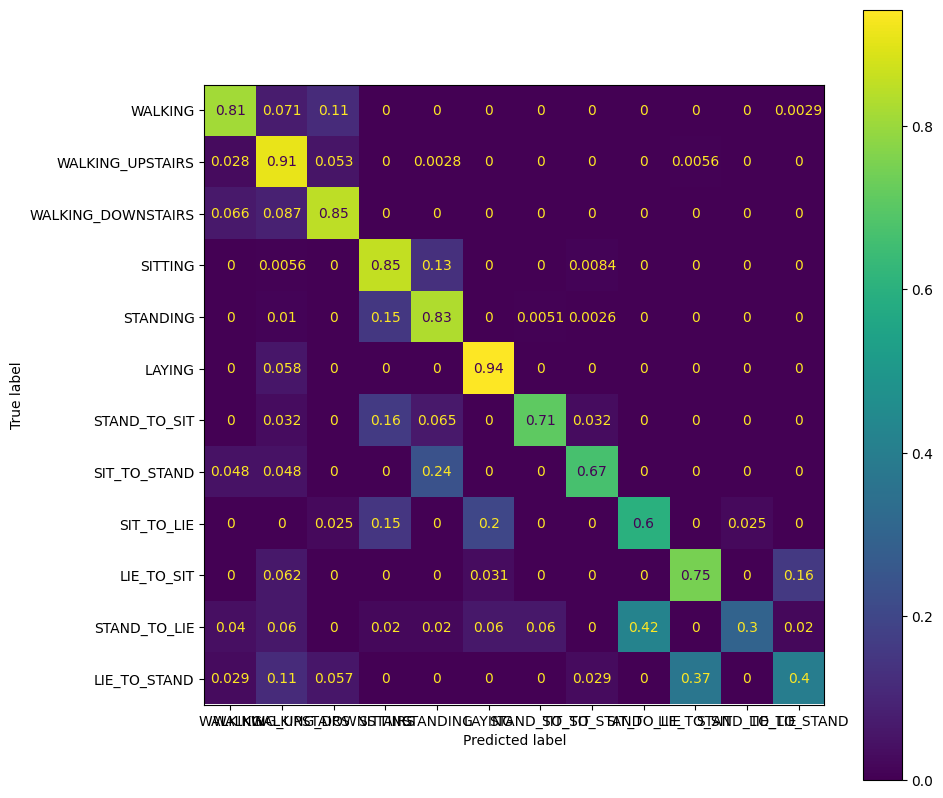

                    precision    recall  f1-score   support

           WALKING       0.89      0.81      0.85       350
  WALKING_UPSTAIRS       0.78      0.91      0.84       359
WALKING_DOWNSTAIRS       0.81      0.85      0.83       320
           SITTING       0.81      0.85      0.83       358
          STANDING       0.85      0.83      0.84       392
            LAYING       0.97      0.94      0.95       382
      STAND_TO_SIT       0.81      0.71      0.76        31
      SIT_TO_STAND       0.70      0.67      0.68        21
        SIT_TO_LIE       0.53      0.60      0.56        40
        LIE_TO_SIT       0.62      0.75      0.68        32
      STAND_TO_LIE       0.94      0.30      0.45        50
      LIE_TO_STAND       0.67      0.40      0.50        35

          accuracy                           0.84      2370
         macro avg       0.78      0.72      0.73      2370
      weighted avg       0.84      0.84      0.83      2370

----0.4-----
Model: "sequential_39"
_

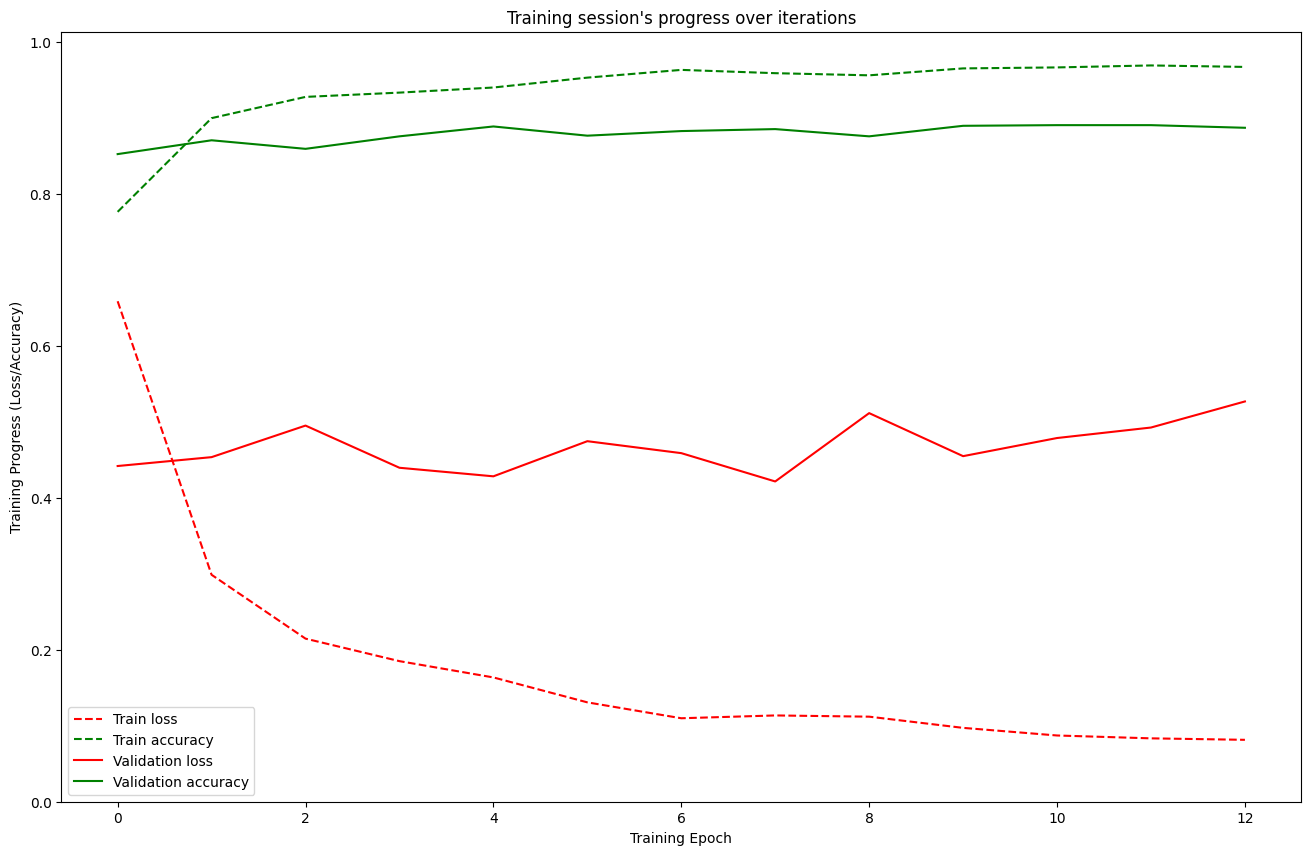

75/75 [==============================] - 0s 1ms/step


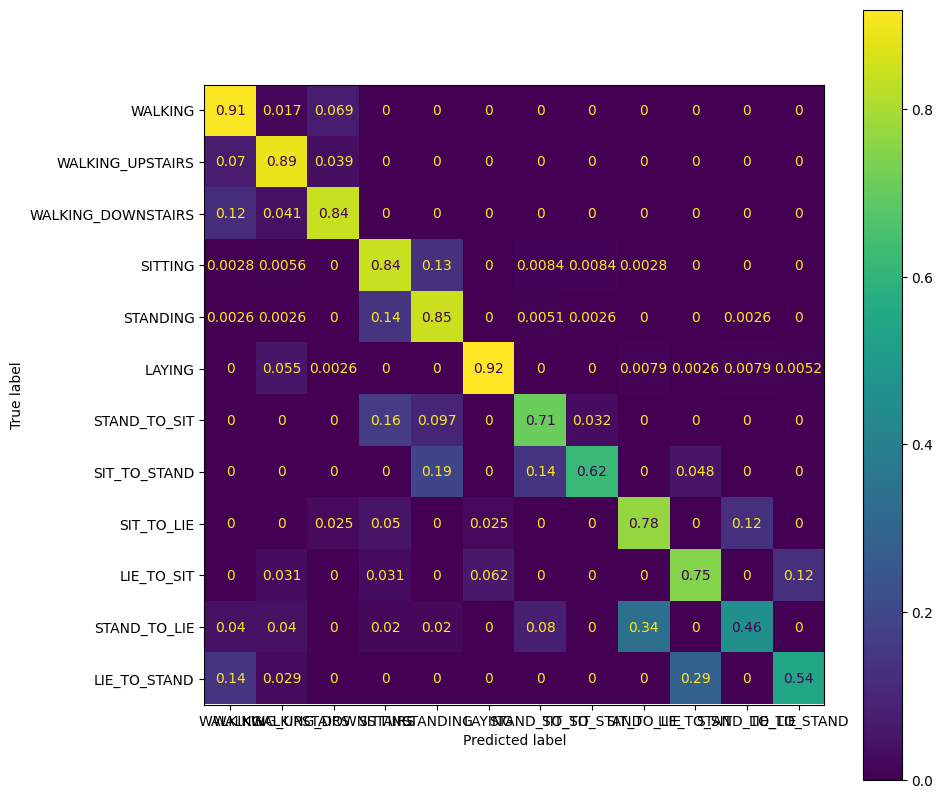

                    precision    recall  f1-score   support

           WALKING       0.82      0.91      0.86       350
  WALKING_UPSTAIRS       0.87      0.89      0.88       359
WALKING_DOWNSTAIRS       0.87      0.84      0.86       320
           SITTING       0.83      0.84      0.83       358
          STANDING       0.86      0.85      0.85       392
            LAYING       0.99      0.92      0.95       382
      STAND_TO_SIT       0.65      0.71      0.68        31
      SIT_TO_STAND       0.72      0.62      0.67        21
        SIT_TO_LIE       0.60      0.78      0.67        40
        LIE_TO_SIT       0.67      0.75      0.71        32
      STAND_TO_LIE       0.72      0.46      0.56        50
      LIE_TO_STAND       0.76      0.54      0.63        35

          accuracy                           0.85      2370
         macro avg       0.78      0.76      0.76      2370
      weighted avg       0.86      0.85      0.85      2370

----0.5-----
Model: "sequential_40"
_

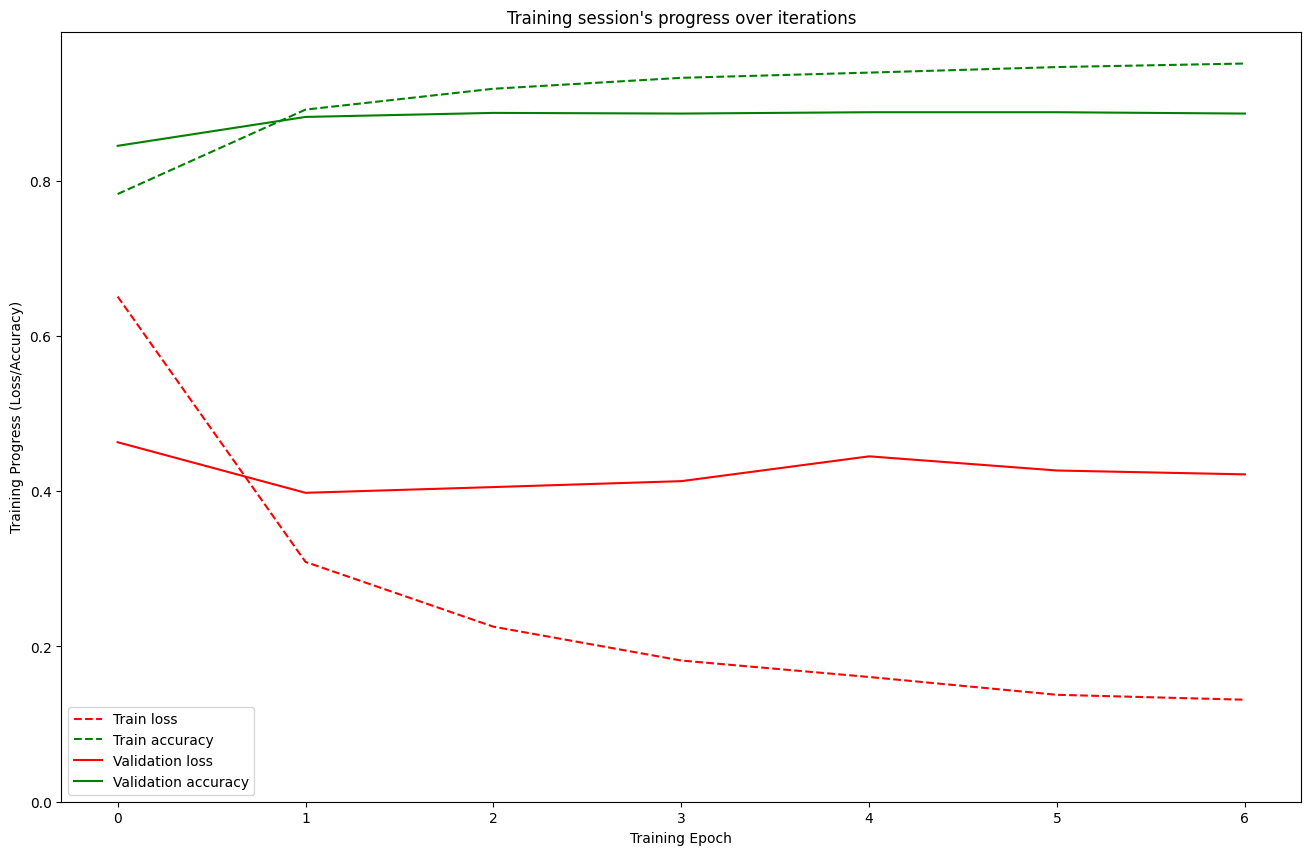

75/75 [==============================] - 0s 2ms/step


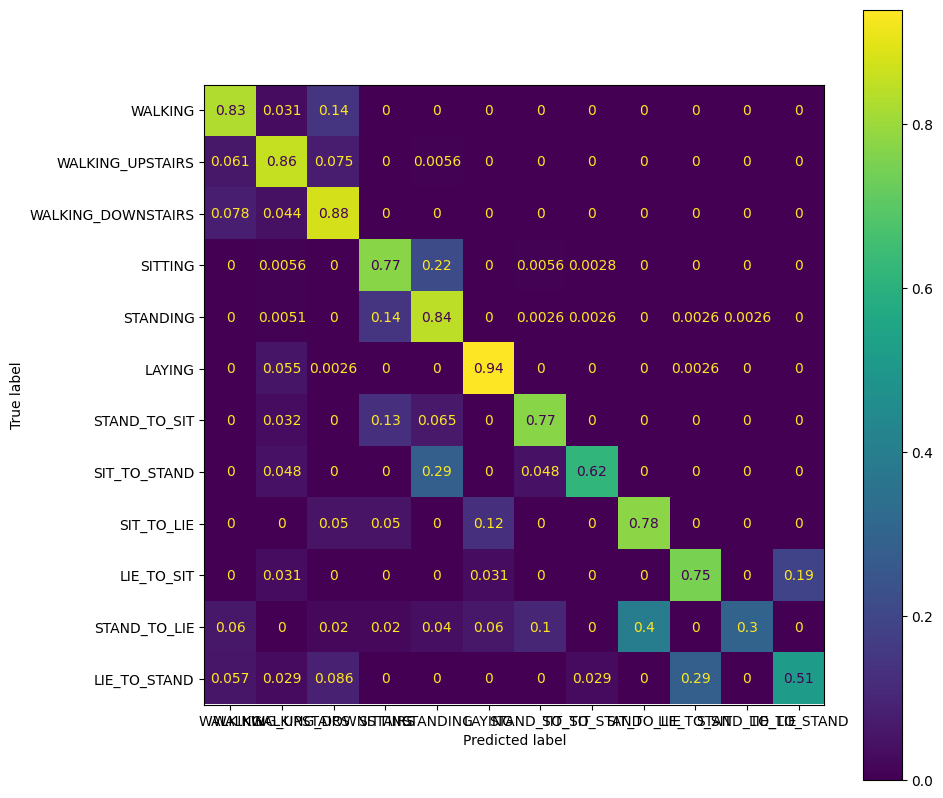

                    precision    recall  f1-score   support

           WALKING       0.85      0.83      0.84       350
  WALKING_UPSTAIRS       0.85      0.86      0.85       359
WALKING_DOWNSTAIRS       0.77      0.88      0.82       320
           SITTING       0.82      0.77      0.79       358
          STANDING       0.79      0.84      0.82       392
            LAYING       0.98      0.94      0.96       382
      STAND_TO_SIT       0.73      0.77      0.75        31
      SIT_TO_STAND       0.81      0.62      0.70        21
        SIT_TO_LIE       0.61      0.78      0.68        40
        LIE_TO_SIT       0.67      0.75      0.71        32
      STAND_TO_LIE       0.94      0.30      0.45        50
      LIE_TO_STAND       0.75      0.51      0.61        35

          accuracy                           0.83      2370
         macro avg       0.80      0.74      0.75      2370
      weighted avg       0.84      0.83      0.83      2370



In [ ]:
#Testing filters with 2 layers
dropout=[0.1,0.2,0.4,0.5]

for d in dropout:
    print(f"----{d}-----")
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=x_train[0].shape))
    model.add(Dropout(d))

    model.add(Flatten())

    model.add(Dense(13, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',
                    metrics=['accuracy'])
    print(model.summary())

    #----------------------------------
    history = model.fit(x_train, y_train, epochs=epoch, validation_split=0.2, verbose=1, callbacks = callback)
    plot_learningCurve(history)
    show_confusion_mat(model)

## Gridsearch

### Processed, 1D gridsearch

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 200, 4, 16)        64        
                                                                 
 dropout_8 (Dropout)         (None, 200, 4, 16)        0         
                                                                 
 conv1d_1 (Conv1D)           (None, 200, 2, 16)        784       
                                                                 
 dropout_9 (Dropout)         (None, 200, 2, 16)        0         
                                                                 
 flatten_41 (Flatten)        (None, 6400)              0         
                                                                 
 dense_41 (Dense)            (None, 64)                409664    
                                                                 
 dropout_10 (Dropout)        (None, 64)              

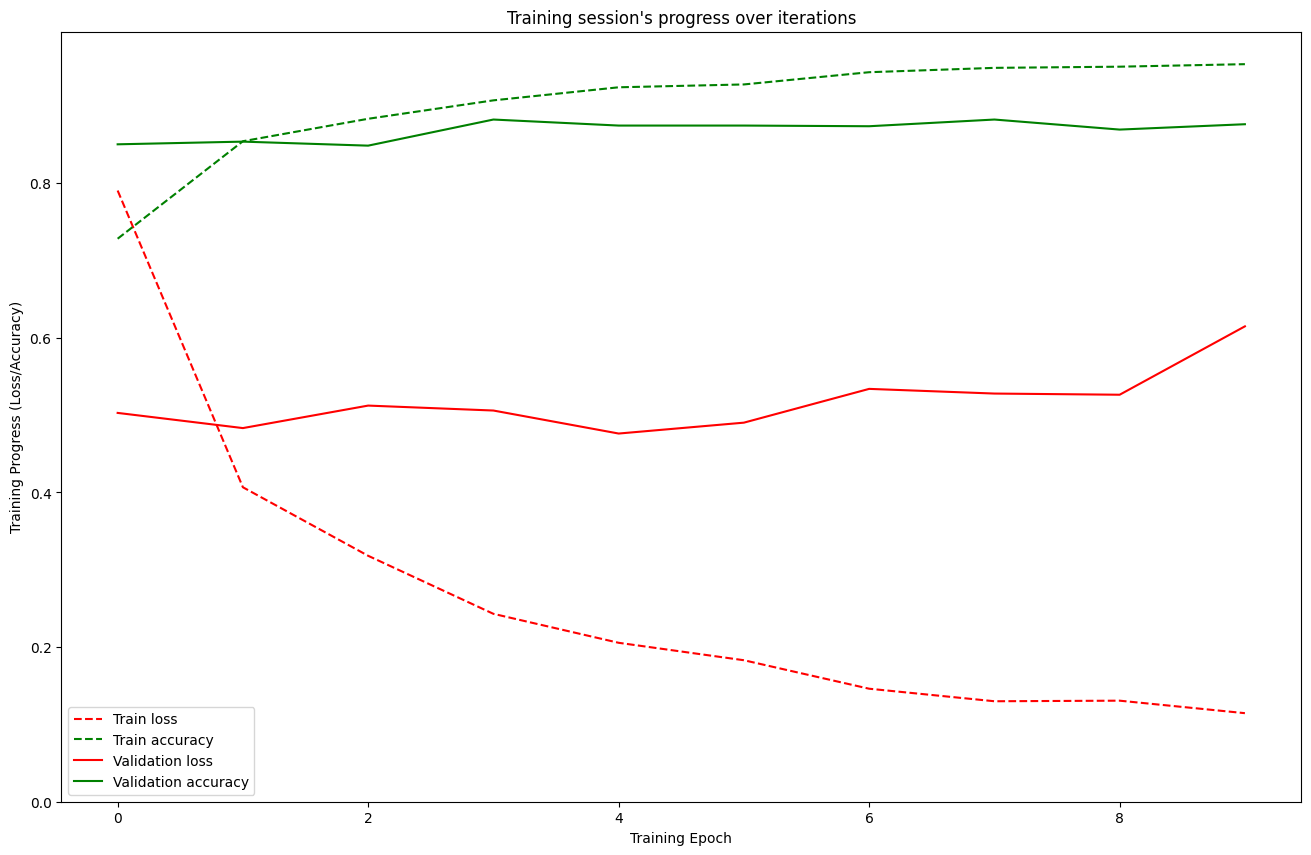

75/75 [==============================] - 0s 3ms/step


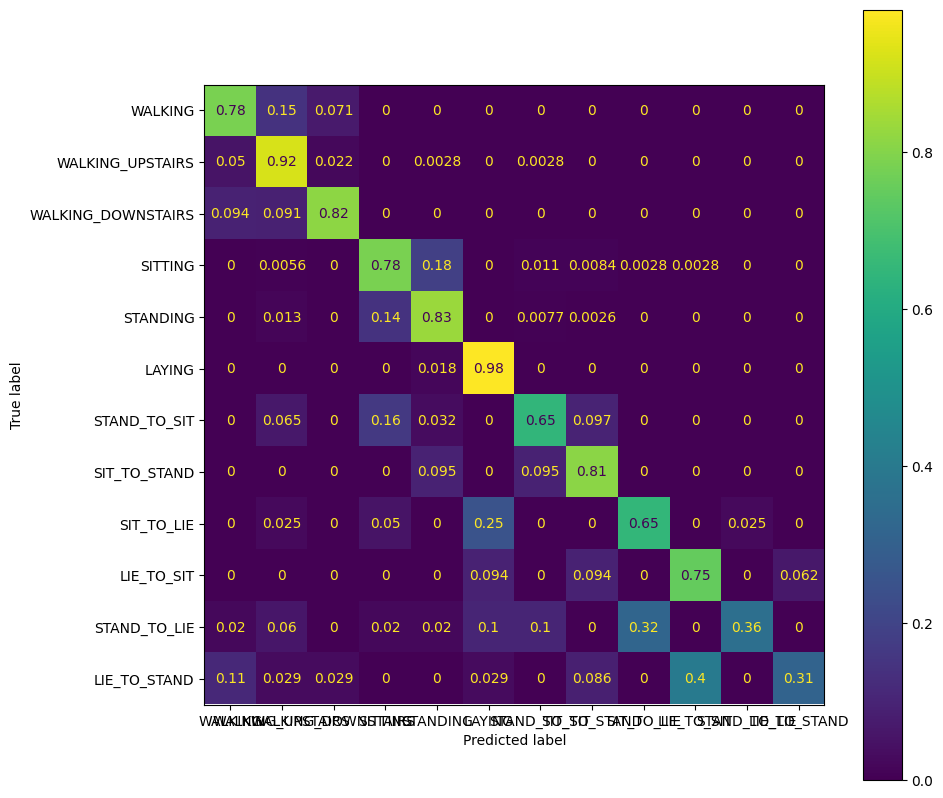

                    precision    recall  f1-score   support

           WALKING       0.84      0.78      0.81       350
  WALKING_UPSTAIRS       0.78      0.92      0.84       359
WALKING_DOWNSTAIRS       0.88      0.82      0.85       320
           SITTING       0.81      0.78      0.80       358
          STANDING       0.81      0.83      0.82       392
            LAYING       0.95      0.98      0.97       382
      STAND_TO_SIT       0.57      0.65      0.61        31
      SIT_TO_STAND       0.57      0.81      0.67        21
        SIT_TO_LIE       0.60      0.65      0.63        40
        LIE_TO_SIT       0.62      0.75      0.68        32
      STAND_TO_LIE       0.95      0.36      0.52        50
      LIE_TO_STAND       0.85      0.31      0.46        35

          accuracy                           0.83      2370
         macro avg       0.77      0.72      0.72      2370
      weighted avg       0.83      0.83      0.83      2370



In [ ]:
filters_first=16
filters_second=16
neurons=64
dropout_first=0.1
dropout_second=0.1
dropout_third=0.2
kernel_first=3
kernel_second=3


processed1D = Sequential()
processed1D.add(Conv1D(filters=filters_first, kernel_size=kernel_first, activation='relu', input_shape=x_train[0].shape))
processed1D.add(Dropout(dropout_first))

if (filters_second != 0):
    processed1D.add(Conv1D(filters_second, kernel_second, activation='relu'))
    processed1D.add(Dropout(dropout_second))

processed1D.add(Flatten())

if (neurons != 0):
    processed1D.add(Dense(neurons, activation = 'relu'))
    processed1D.add(Dropout(dropout_third))

processed1D.add(Dense(13, activation='softmax'))

# Compile model
processed1D.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(processed1D.summary())

#----------------------------------
processed1D_history = processed1D.fit(x_train, y_train, epochs=epoch, validation_split=0.2, verbose=1, callbacks = callback)
plot_learningCurve(processed1D_history)
show_confusion_mat(processed1D)

### Raw 2D gridsearch

In [ ]:
epoch = 20    #<---
lr    = 0.001 #<---
#-------------modify the layers-----------
def create_model(filters_first, filters_second=0, neurons=0, dropout_first=0, dropout_second=0, dropout_third=0):
  # create model
    model = Sequential()
    model.add(Conv2D(filters=filters_first, kernel_size=(2,2), activation='relu', input_shape=x_train[0].shape))
    model.add(Dropout(dropout_first))

    if (filters_second != 0):
        model.add(Conv2D(filters_second, (2, 2), activation='relu'))
        model.add(Dropout(dropout_second))

    model.add(Flatten())
  
    if (neurons != 0):
        model.add(Dense(neurons, activation = 'relu'))
        model.add(Dropout(dropout_third))

    model.add(Dense(13, activation='softmax'))
  
  # Compile model
    model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(model=create_model, epochs=20, verbose=0)

filters_first=[8, 16]
filters_second=[0, 8, 16]
neurons=[0, 32, 64]
dropout_first=[0, 0.1]
dropout_second=[0, 0.2, 0.5]
dropout_third=[0, 0.2, 0.5]

param_grid = dict(model__filters_first=filters_first, model__filters_second=filters_second, model__neurons=neurons, model__dropout_first=dropout_first, model__dropout_second=dropout_second, model__dropout_third=dropout_third)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, error_score='raise', verbose=2)
fit_parameters = {"callbacks" : [callback]}
grid_result = grid.fit(x_train, y_train, **fit_parameters)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0, model__filters_first=8, model__filters_second=0, model__neurons=0; total time=  10.3s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0, model__filters_first=8, model__filters_second=0, model__neurons=0; total time=  10.7s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0, model__filters_first=8, model__filters_second=0, model__neurons=0; total time=  12.6s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0, model__filters_first=8, model__filters_second=0, model__neurons=0; total time=  12.2s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0, model__filters_first=8, model__filters_second=0, model__neurons=0; total time=  11.1s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0, model__filters

[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0, model__filters_first=16, model__filters_second=0, model__neurons=0; total time=  11.2s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0, model__filters_first=16, model__filters_second=0, model__neurons=32; total time=  12.3s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0, model__filters_first=16, model__filters_second=0, model__neurons=32; total time=  12.0s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0, model__filters_first=16, model__filters_second=0, model__neurons=32; total time=  12.0s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0, model__filters_first=16, model__filters_second=0, model__neurons=32; total time=  12.1s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0, model__filters_first=16, model__filters_second=0, model__neurons=32; 

[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=8, model__filters_second=0, model__neurons=32; total time=  12.5s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=8, model__filters_second=0, model__neurons=32; total time=  12.6s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=8, model__filters_second=0, model__neurons=64; total time=  13.6s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=8, model__filters_second=0, model__neurons=64; total time=  13.6s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=8, model__filters_second=0, model__neurons=64; total time=  13.3s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=8, model__filters_second=0, model__neuro

[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=16, model__filters_second=0, model__neurons=64; total time=  10.7s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=16, model__filters_second=0, model__neurons=64; total time=  10.8s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=16, model__filters_second=0, model__neurons=64; total time=  10.9s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=16, model__filters_second=0, model__neurons=64; total time=  10.9s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=16, model__filters_second=8, model__neurons=0; total time=  12.4s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=16, model__filters_second=8, model__

[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=8, model__filters_second=0, model__neurons=64; total time=  13.8s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=8, model__filters_second=8, model__neurons=0; total time=  12.6s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=8, model__filters_second=8, model__neurons=0; total time=  12.8s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=8, model__filters_second=8, model__neurons=0; total time=  12.9s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=8, model__filters_second=8, model__neurons=0; total time=  13.0s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=8, model__filters_second=8, model__neurons=0

[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=16, model__filters_second=8, model__neurons=0; total time=  11.9s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=16, model__filters_second=8, model__neurons=0; total time=  11.9s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=16, model__filters_second=8, model__neurons=0; total time=  11.8s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=16, model__filters_second=8, model__neurons=32; total time=  13.4s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=16, model__filters_second=8, model__neurons=32; total time=  13.0s
[CV] END model__dropout_first=0, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=16, model__filters_second=8, model__ne

[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=8, model__filters_second=8, model__neurons=32; total time=  12.9s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=8, model__filters_second=8, model__neurons=32; total time=  12.9s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=8, model__filters_second=8, model__neurons=32; total time=  12.4s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=8, model__filters_second=8, model__neurons=32; total time=  12.4s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=8, model__filters_second=8, model__neurons=32; total time=  13.1s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=8, model__filters_second=8, model__neuro

[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=16, model__filters_second=8, model__neurons=32; total time=  13.4s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=16, model__filters_second=8, model__neurons=32; total time=  13.4s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=16, model__filters_second=8, model__neurons=64; total time=  11.6s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=16, model__filters_second=8, model__neurons=64; total time=  15.0s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=16, model__filters_second=8, model__neurons=64; total time=  14.6s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=16, model__filters_second=8, model_

[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=8, model__filters_second=8, model__neurons=64; total time=  13.5s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=8, model__filters_second=8, model__neurons=64; total time=  13.2s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=8, model__filters_second=8, model__neurons=64; total time=  13.2s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=8, model__filters_second=8, model__neurons=64; total time=  13.2s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=8, model__filters_second=16, model__neurons=0; total time=  11.1s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=8, model__filters_second=16,

[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=16, model__filters_second=8, model__neurons=64; total time=  14.5s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=16, model__filters_second=16, model__neurons=0; total time=  12.1s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=16, model__filters_second=16, model__neurons=0; total time=  12.0s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=16, model__filters_second=16, model__neurons=0; total time=  11.9s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=16, model__filters_second=16, model__neurons=0; total time=  11.8s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=16, model__filters_seco

[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=8, model__filters_second=16, model__neurons=0; total time=  11.1s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=8, model__filters_second=16, model__neurons=0; total time=  11.2s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=8, model__filters_second=16, model__neurons=0; total time=  11.2s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=8, model__filters_second=16, model__neurons=32; total time=  12.3s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=8, model__filters_second=16, model__neurons=32; total time=  12.2s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=8, model__filters_second=1

[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=16, model__filters_second=16, model__neurons=32; total time=  12.5s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=16, model__filters_second=16, model__neurons=32; total time=  12.4s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=16, model__filters_second=16, model__neurons=32; total time=  12.3s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=16, model__filters_second=16, model__neurons=32; total time=  12.3s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=16, model__filters_second=16, model__neurons=32; total time=  12.8s
[CV] END model__dropout_first=0, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=16, model__filters

[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0, model__filters_first=8, model__filters_second=16, model__neurons=32; total time=  11.2s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0, model__filters_first=8, model__filters_second=16, model__neurons=32; total time=  11.4s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0, model__filters_first=8, model__filters_second=16, model__neurons=64; total time=  11.8s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0, model__filters_first=8, model__filters_second=16, model__neurons=64; total time=  11.8s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0, model__filters_first=8, model__filters_second=16, model__neurons=64; total time=  11.9s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0, model__filters_first=8, model__filters_second=16, model_

[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0, model__filters_first=16, model__filters_second=16, model__neurons=64; total time=  12.2s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0, model__filters_first=16, model__filters_second=16, model__neurons=64; total time=  12.1s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0, model__filters_first=16, model__filters_second=16, model__neurons=64; total time=  12.6s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0, model__filters_first=16, model__filters_second=16, model__neurons=64; total time=  12.2s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0.2, model__filters_first=8, model__filters_second=0, model__neurons=0; total time=   9.6s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0.2, model__filters_first=8, model__filters_second=0, m

[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0.2, model__filters_first=8, model__filters_second=16, model__neurons=64; total time=  12.1s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0.2, model__filters_first=16, model__filters_second=0, model__neurons=0; total time=   8.5s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0.2, model__filters_first=16, model__filters_second=0, model__neurons=0; total time=  10.3s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0.2, model__filters_first=16, model__filters_second=0, model__neurons=0; total time=  10.3s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0.2, model__filters_first=16, model__filters_second=0, model__neurons=0; total time=  10.3s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0.2, model__filters_first=16, model__filters_second=0

[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=8, model__filters_second=0, model__neurons=0; total time=  10.5s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=8, model__filters_second=0, model__neurons=0; total time=  10.6s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=8, model__filters_second=0, model__neurons=0; total time=  10.9s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=8, model__filters_second=0, model__neurons=32; total time=  12.7s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=8, model__filters_second=0, model__neurons=32; total time=  12.6s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=8, model__filters_second=0, mod

[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=16, model__filters_second=0, model__neurons=32; total time=  10.6s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=16, model__filters_second=0, model__neurons=32; total time=   9.8s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=16, model__filters_second=0, model__neurons=32; total time=   9.7s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=16, model__filters_second=0, model__neurons=32; total time=  10.0s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=16, model__filters_second=0, model__neurons=32; total time=   9.9s
[CV] END model__dropout_first=0, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=16, model__filters_seco

[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0, model__filters_first=8, model__filters_second=0, model__neurons=32; total time=  12.2s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0, model__filters_first=8, model__filters_second=0, model__neurons=32; total time=  11.5s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0, model__filters_first=8, model__filters_second=0, model__neurons=64; total time=  11.7s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0, model__filters_first=8, model__filters_second=0, model__neurons=64; total time=  11.6s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0, model__filters_first=8, model__filters_second=0, model__neurons=64; total time=  11.4s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0, model__filters_first=8, model__filters_second=0, model__neuro

[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0, model__filters_first=16, model__filters_second=0, model__neurons=64; total time=  10.5s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0, model__filters_first=16, model__filters_second=0, model__neurons=64; total time=  10.4s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0, model__filters_first=16, model__filters_second=0, model__neurons=64; total time=  10.6s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0, model__filters_first=16, model__filters_second=0, model__neurons=64; total time=  10.9s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0, model__filters_first=16, model__filters_second=8, model__neurons=0; total time=  11.1s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0, model__filters_first=16, model__filters_second=8, model__

[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=8, model__filters_second=0, model__neurons=64; total time=  12.9s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=8, model__filters_second=8, model__neurons=0; total time=  12.0s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=8, model__filters_second=8, model__neurons=0; total time=  12.9s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=8, model__filters_second=8, model__neurons=0; total time=  12.4s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=8, model__filters_second=8, model__neurons=0; total time=  11.9s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=8, model__filters_second=8, mode

[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=16, model__filters_second=8, model__neurons=0; total time=  12.1s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=16, model__filters_second=8, model__neurons=0; total time=  11.5s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=16, model__filters_second=8, model__neurons=0; total time=  11.4s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=16, model__filters_second=8, model__neurons=32; total time=  12.6s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=16, model__filters_second=8, model__neurons=32; total time=  12.4s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.2, model__filters_first=16, model__filters_second=

[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=8, model__filters_second=8, model__neurons=32; total time=  13.3s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=8, model__filters_second=8, model__neurons=32; total time=  13.1s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=8, model__filters_second=8, model__neurons=32; total time=  13.0s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=8, model__filters_second=8, model__neurons=32; total time=  13.1s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=8, model__filters_second=8, model__neurons=32; total time=  14.2s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=8, model__filters_second=8, 

[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=16, model__filters_second=8, model__neurons=32; total time=  12.2s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=16, model__filters_second=8, model__neurons=32; total time=  12.2s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=16, model__filters_second=8, model__neurons=64; total time=  12.5s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=16, model__filters_second=8, model__neurons=64; total time=  12.0s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=16, model__filters_second=8, model__neurons=64; total time=  12.1s
[CV] END model__dropout_first=0.1, model__dropout_second=0, model__dropout_third=0.5, model__filters_first=16, model__filters_seco

[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=8, model__filters_second=8, model__neurons=64; total time=  13.6s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=8, model__filters_second=8, model__neurons=64; total time=  13.8s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=8, model__filters_second=8, model__neurons=64; total time=  13.9s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=8, model__filters_second=8, model__neurons=64; total time=  13.7s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=8, model__filters_second=16, model__neurons=0; total time=  11.8s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=8, model__filters_second=16,

[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=16, model__filters_second=8, model__neurons=64; total time=  12.6s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=16, model__filters_second=16, model__neurons=0; total time=  12.6s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=16, model__filters_second=16, model__neurons=0; total time=  12.5s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=16, model__filters_second=16, model__neurons=0; total time=  12.4s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=16, model__filters_second=16, model__neurons=0; total time=  12.5s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0, model__filters_first=16, model__filters_seco

[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=8, model__filters_second=16, model__neurons=0; total time=  11.3s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=8, model__filters_second=16, model__neurons=0; total time=  11.3s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=8, model__filters_second=16, model__neurons=0; total time=  11.5s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=8, model__filters_second=16, model__neurons=0; total time=  11.5s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=8, model__filters_second=16, model__neurons=32; total time=  12.4s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=8, model__filte

[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=16, model__filters_second=16, model__neurons=0; total time=  12.0s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=16, model__filters_second=16, model__neurons=0; total time=  12.4s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=16, model__filters_second=16, model__neurons=32; total time=  13.5s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=16, model__filters_second=16, model__neurons=32; total time=  13.4s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=16, model__filters_second=16, model__neurons=32; total time=  13.2s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.2, model__filters_first=16, mode

[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=8, model__filters_second=16, model__neurons=32; total time=  12.4s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=8, model__filters_second=16, model__neurons=32; total time=  13.1s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=8, model__filters_second=16, model__neurons=32; total time=  12.9s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=8, model__filters_second=16, model__neurons=32; total time=  12.9s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=8, model__filters_second=16, model__neurons=32; total time=  12.5s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=8, model__f

[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=16, model__filters_second=16, model__neurons=32; total time=  13.4s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=16, model__filters_second=16, model__neurons=32; total time=  13.6s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=16, model__filters_second=16, model__neurons=32; total time=  13.6s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=16, model__filters_second=16, model__neurons=64; total time=  13.8s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=16, model__filters_second=16, model__neurons=64; total time=  13.8s
[CV] END model__dropout_first=0.1, model__dropout_second=0.2, model__dropout_third=0.5, model__filters_first=16, mo

[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0, model__filters_first=8, model__filters_second=16, model__neurons=64; total time=  12.6s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0, model__filters_first=8, model__filters_second=16, model__neurons=64; total time=  12.6s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0, model__filters_first=8, model__filters_second=16, model__neurons=64; total time=  12.6s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0, model__filters_first=8, model__filters_second=16, model__neurons=64; total time=  12.5s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0, model__filters_first=8, model__filters_second=16, model__neurons=64; total time=  12.8s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0, model__filters_first=16, model__filters_seco

[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0, model__filters_first=16, model__filters_second=16, model__neurons=64; total time=  13.2s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0, model__filters_first=16, model__filters_second=16, model__neurons=64; total time=  13.1s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0.2, model__filters_first=8, model__filters_second=0, model__neurons=0; total time=   9.8s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0.2, model__filters_first=8, model__filters_second=0, model__neurons=0; total time=  11.2s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0.2, model__filters_first=8, model__filters_second=0, model__neurons=0; total time=  11.0s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0.2, model__filters_first=8, model__filters_s

[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0.2, model__filters_first=16, model__filters_second=0, model__neurons=0; total time=   9.7s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0.2, model__filters_first=16, model__filters_second=0, model__neurons=0; total time=  10.1s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0.2, model__filters_first=16, model__filters_second=0, model__neurons=0; total time=   9.6s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0.2, model__filters_first=16, model__filters_second=0, model__neurons=0; total time=   9.6s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0.2, model__filters_first=16, model__filters_second=0, model__neurons=0; total time=   9.8s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0.2, model__filters_first=16, model__filte

[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=8, model__filters_second=0, model__neurons=0; total time=  11.4s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=8, model__filters_second=0, model__neurons=0; total time=  11.2s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=8, model__filters_second=0, model__neurons=0; total time=  12.6s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=8, model__filters_second=0, model__neurons=32; total time=  14.1s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=8, model__filters_second=0, model__neurons=32; total time=  14.5s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=8, model__filters_s

[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=16, model__filters_second=0, model__neurons=0; total time=  10.3s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=16, model__filters_second=0, model__neurons=32; total time=  11.8s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=16, model__filters_second=0, model__neurons=32; total time=  11.3s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=16, model__filters_second=0, model__neurons=32; total time=  11.4s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=16, model__filters_second=0, model__neurons=32; total time=  11.8s
[CV] END model__dropout_first=0.1, model__dropout_second=0.5, model__dropout_third=0.5, model__filters_first=16, model__f

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.887889 using {'model__dropout_first': 0.1, 'model__dropout_second': 0.5, 'model__dropout_third': 0.2, 'model__filters_first': 16, 'model__filters_second': 8, 'model__neurons': 64}
0.845605 (0.019719) with: {'model__dropout_first': 0, 'model__dropout_second': 0, 'model__dropout_third': 0, 'model__filters_first': 8, 'model__filters_second': 0, 'model__neurons': 0}
0.860855 (0.014781) with: {'model__dropout_first': 0, 'model__dropout_second': 0, 'model__dropout_third': 0, 'model__filters_first': 8, 'model__filters_second': 0, 'model__neurons': 32}
0.843174 (0.040380) with: {'model__dropout_first': 0, 'model__dropout_second': 0, 'model__dropout_third': 0, 'model__filters_first': 8, 'model__filters_second': 0, 'model__neurons': 64}
0.875240 (0.021374) with: {'model__dropout_first': 0, 'model__dropout_second': 0, 'model__dropout_third': 0, 'model__filters_first': 8, 'model__filters_second': 8, 'model__neurons': 0}
0.876803 (0.019624) with: {'model__dropout_first': 0, 'model__dropout_

### Testing best tune

Model: "sequential_1880"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3106 (Conv2D)        (None, 199, 5, 16)        80        
                                                                 
 dropout_4330 (Dropout)      (None, 199, 5, 16)        0         
                                                                 
 conv2d_3107 (Conv2D)        (None, 198, 4, 8)         520       
                                                                 
 dropout_4331 (Dropout)      (None, 198, 4, 8)         0         
                                                                 
 flatten_1880 (Flatten)      (None, 6336)              0         
                                                                 
 dense_3126 (Dense)          (None, 64)                405568    
                                                                 
 dropout_4332 (Dropout)      (None, 64)            

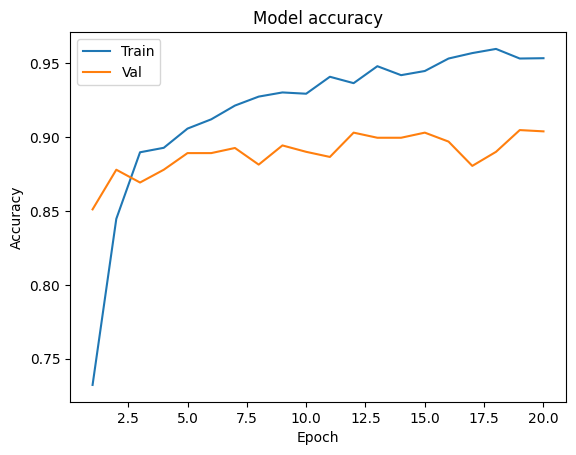

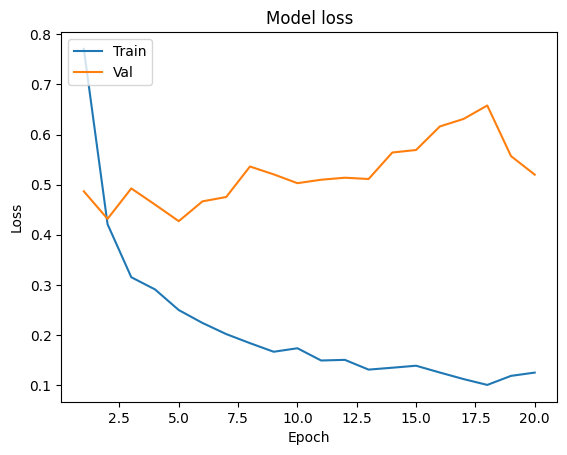

75/75 [==============================] - 0s 2ms/step


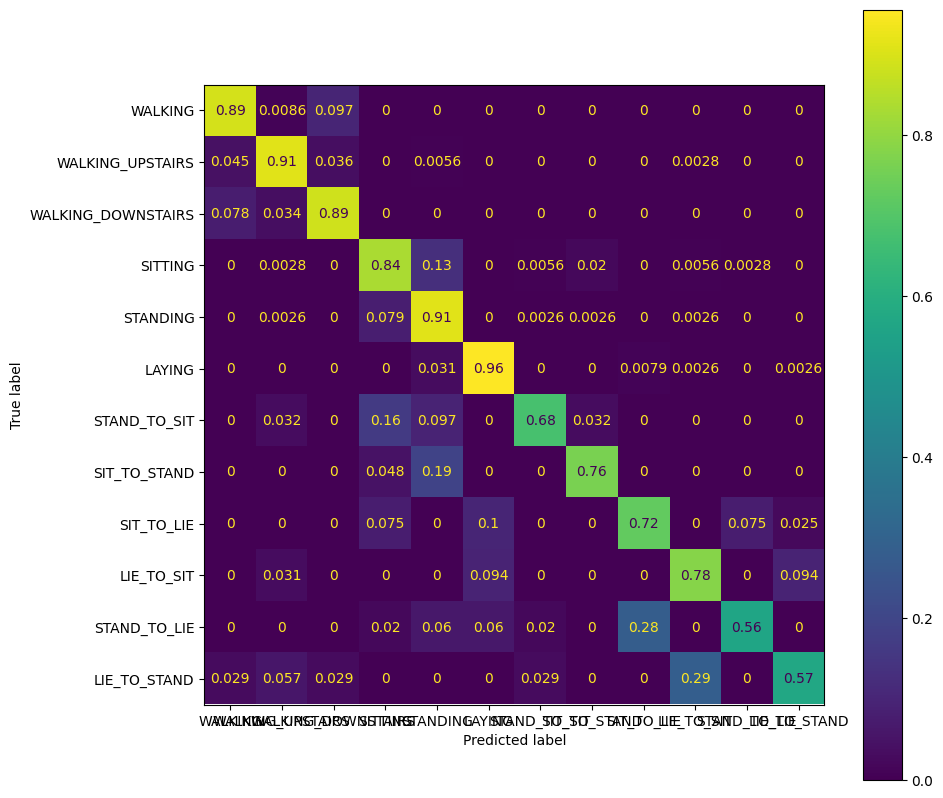

                    precision    recall  f1-score   support

           WALKING       0.88      0.89      0.89       350
  WALKING_UPSTAIRS       0.94      0.91      0.93       359
WALKING_DOWNSTAIRS       0.86      0.89      0.87       320
           SITTING       0.88      0.84      0.86       358
          STANDING       0.84      0.91      0.87       392
            LAYING       0.97      0.96      0.96       382
      STAND_TO_SIT       0.81      0.68      0.74        31
      SIT_TO_STAND       0.64      0.76      0.70        21
        SIT_TO_LIE       0.63      0.72      0.67        40
        LIE_TO_SIT       0.62      0.78      0.69        32
      STAND_TO_LIE       0.88      0.56      0.68        50
      LIE_TO_STAND       0.80      0.57      0.67        35

          accuracy                           0.88      2370
         macro avg       0.81      0.79      0.79      2370
      weighted avg       0.88      0.88      0.88      2370



In [ ]:
##Running the model
# Conv2d(16, (2,2), relu) + drop(0.1) + Conv2d(8, (2,2), relu) + drop(0.5) + flatten() + Dense(64, relu) + drop(0.2) + Dense(13, softmax)
#-------------------copy this code------------------------
epoch = 20    #<---
lr    = 0.001 #<---
#-------------modify the layers-----------
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(2,2), activation='relu', input_shape=x_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(8, (2, 2), activation='relu'))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(13, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())
#------------------------------------------
# early stopping

history = model.fit(x_train, y_train, epochs=epoch, validation_split=0.2, verbose=0)
plot_learningCurve(history, epoch)
y_pred = np.argmax(model.predict(x_test), axis=-1)
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', ax=ax, display_labels=list(label_dict_rev.keys()))
plt.show()
#-----------------------------------------------------------
print(classification_report(y_test, y_pred, target_names=label_dict_rev.keys()))

# Test on processed dataset

In [ ]:
# Load data
x_train = pd.read_csv(r'x_train.csv')
y_train = pd.read_csv(r'y_train.csv')
x_test= pd.read_csv(r'x_test.csv')
y_test = pd.read_csv(r'y_test.csv')

In [ ]:
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)

In [ ]:
## Load labels
columns = ['user', 'activity', 'time', 'ax','ay','az', 'gx', 'gy', 'gz']
label_dict = {1: "WALKING",
              2: "WALKING_UPSTAIRS",
              3: "WALKING_DOWNSTAIRS",
              4: "SITTING",
              5: "STANDING",
              6: "LAYING",
              7: "STAND_TO_SIT",
              8: "SIT_TO_STAND", 
              9: "SIT_TO_LIE", 
              10: "LIE_TO_SIT",
              11: "STAND_TO_LIE",
              12: "LIE_TO_STAND"}
label_dict_rev = {v: k for k, v in label_dict.items()}
label_list = list(label_dict.values())

In [ ]:
# declare early stopping callback
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True)

In [ ]:
def plot_learning_curve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

## Gridsearch over processed dataset

In [ ]:
# Gridsearch

epoch = 20    #<---
lr    = 0.001 #<---
#-------------modify the layers-----------
def create_model(filters_first, filters_second=0, neurons=0, dropout_first=0, dropout_second=0, dropout_third=0, kernel_first=3, kernel_second=3):
  # create model
  model = Sequential()
  model.add(Conv1D(filters=filters_first, kernel_size=kernel_first, activation='relu', input_shape=x_train[0].shape))
  model.add(Dropout(dropout_first))

  if (filters_second != 0):
    model.add(Conv1D(filters_second, kernel_second, activation='relu'))
    model.add(Dropout(dropout_second))

  model.add(Flatten())
  
  if (neurons != 0):
    model.add(Dense(neurons, activation = 'relu'))
    model.add(Dropout(dropout_third))

  model.add(Dense(13, activation='softmax'))
  
  # Compile model
  model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

# create model
model = KerasClassifier(model=create_model, epochs=20, verbose=0)

filters_first=[8, 16]
filters_second=[0, 8, 16]
neurons=[0, 32, 64]
dropout_first=[0, 0.1]
dropout_second=[0.1, 0.2]
dropout_third=[0.2, 0.5]
kernel_first=[3]
kernel_second=[3]
param_grid = dict(model__filters_first=filters_first, model__filters_second=filters_second, model__neurons=neurons, model__dropout_first=dropout_first, model__dropout_second=dropout_second, model__dropout_third=dropout_third, model__kernel_first=kernel_first, model__kernel_second=kernel_second)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=3, error_score='raise', verbose=0)
fit_parameters = {"callbacks" : [earlystopping]}
grid_result = grid.fit(x_train, y_train, **fit_parameters)

In [ ]:
# save results
with open('cv_results.pickle', 'wb') as handle:
    pickle.dump(grid_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# reload results
# the file is found inside gdrive inside the data set folder
with open('cv_results.pickle', 'rb') as handle:
    cv_results = pickle.load(handle)

In [ ]:
## print the results of the gridsearch

pd_grid_result = pd.DataFrame([[mean, stdev, param] for mean, stdev, param in zip(cv_results['mean_test_score'], cv_results['std_test_score'], cv_results['params'])], columns=["means", "stds", "params"])

means = pd_grid_result['means']
stds = pd_grid_result['stds']
params = pd_grid_result['params']
print("Best: %f using %s" % (pd_grid_result.sort_values(by=['means'], ascending=False).iloc[0, 0], pd_grid_result.sort_values(by=['means'], ascending=False).iloc[0, 2]))
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.936660 using {'model__dropout_first': 0, 'model__dropout_second': 0.2, 'model__dropout_third': 0.2, 'model__filters_first': 8, 'model__filters_second': 16, 'model__kernel_first': 3, 'model__kernel_second': 3, 'model__neurons': 64}


## Final Results on Processed dataset

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 559, 8)            32        
                                                                 
 conv1d_1 (Conv1D)           (None, 557, 16)           400       
                                                                 
 dropout (Dropout)           (None, 557, 16)           0         
                                                                 
 flatten (Flatten)           (None, 8912)              0         
                                                                 
 dense (Dense)               (None, 64)                570432    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 13)               

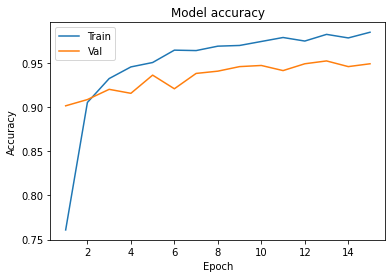

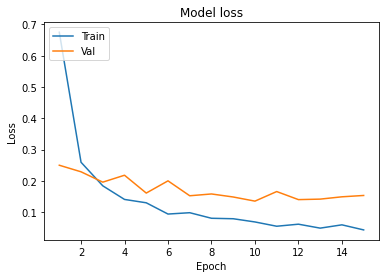

99/99 [==============================] - 1s 5ms/step


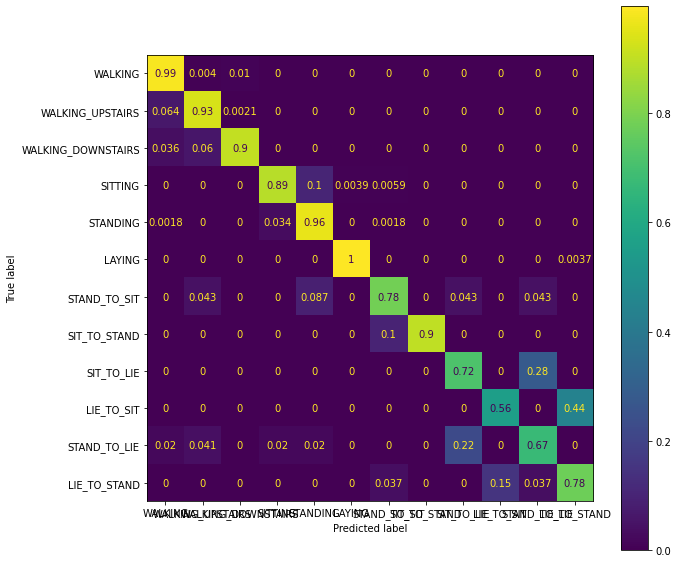

                    precision    recall  f1-score   support

           WALKING       0.91      0.99      0.95       496
  WALKING_UPSTAIRS       0.94      0.93      0.94       471
WALKING_DOWNSTAIRS       0.98      0.90      0.94       420
           SITTING       0.96      0.89      0.92       508
          STANDING       0.91      0.96      0.93       556
            LAYING       1.00      1.00      1.00       545
      STAND_TO_SIT       0.75      0.78      0.77        23
      SIT_TO_STAND       1.00      0.90      0.95        10
        SIT_TO_LIE       0.66      0.72      0.69        32
        LIE_TO_SIT       0.78      0.56      0.65        25
      STAND_TO_LIE       0.75      0.67      0.71        49
      LIE_TO_STAND       0.62      0.78      0.69        27

          accuracy                           0.93      3162
         macro avg       0.85      0.84      0.84      3162
      weighted avg       0.94      0.93      0.93      3162



In [ ]:
# Results of running model on preprocessed dataset with gridsearched parameters

epoch = 30    #<---
lr    = 0.001 #<---
#------------------------------------------
model = Sequential()

model.add(Conv1D(filters=8, kernel_size=3, activation='relu', input_shape=x_train[0].shape))
model.add(Conv1D(16, 3, activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(13, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())
#------------------------------------------


history = model.fit(x_train, y_train, epochs=epoch, validation_split=0.2, verbose=1, callbacks=[earlystopping])
plot_learning_curve(history, earlystopping.stopped_epoch + 1)
y_pred = np.argmax(model.predict(x_test), axis=-1)
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', ax=ax, display_labels=list(label_dict_rev.keys()))
plt.show()
#-----------------------------------------------------------
print(classification_report(y_test, y_pred, target_names=label_dict_rev.keys()))